In [28]:
pip install torch optuna pandas numpy scikit-learn

Note: you may need to restart the kernel to use updated packages.


Setup and Project Root & Import Libraries

In [29]:
import sys, os
import shutil

# Set paths
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(project_root)
model_save_path = os.path.join(project_root, "Models", "Weights", "RNN")

# Check if the directory exists before attempting to delete it
if os.path.exists(model_save_path):
    shutil.rmtree(model_save_path)  # Delete the directory and all its contents
    print(f"Deleted the directory: {model_save_path}")
else:
    print(f"Directory {model_save_path} does not exist.")

import pickle
import matplotlib.pyplot as plt
from pathlib import Path

import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from Models.RNN import RNNModel
from Training.Helper.PyTorchModular import optuna_tune_and_train_pytorch, split_params  # Import Optuna function
from Training.Helper.dataPreprocessing import make_predictions, create_sequences_with_horizon, add_lagged_features, add_rolling_features, add_time_features, add_dimension, TRAIN_DATA_SPLIT
from Evaluation.Helper.evaluation_helpers import calc_metrics_arrays, make_evaluation_predictions

Deleted the directory: c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\RNN


Load and Prepare Data & Feature Engineering

In [30]:
# ==== Load & Prepare CSV ====
train_file = os.path.join(project_root, "Data", "Train", "train1990s.csv")
df = pd.read_csv(train_file)
df['ds'] = pd.to_datetime(df['observation_date'], format='%m/%Y')
df = df.rename(columns={'fred_PCEPI': 'y'})


# ==== Feature Engineering ====

# Adding time-based features
df = add_time_features(df, date_col='ds')

# Adding sine and cosine monthly features of various wavelengths (seasonality features)
for k in range(1, 4):
    df[f'sin_{k}'] = np.sin(2 * np.pi * k * df['month'] / 12)
    df[f'cos_{k}'] = np.cos(2 * np.pi * k * df['month'] / 12)

# Adding lag features
df = add_lagged_features(df, target_cols=['y'], lags=[1, 3, 6])

# Adding rolling features
df = add_rolling_features(df, target_col='y', windows=[3, 6, 12])

df = df.dropna().reset_index(drop=True)


2025-04-24 20:01:27,475 - INFO - Added time features: year, month, quarter. DataFrame shape: (408, 363)
2025-04-24 20:01:27,491 - INFO - Added lagged features with lags [1, 3, 6] to target columns ['y']. DataFrame shape: (408, 372)
2025-04-24 20:01:27,503 - INFO - Added rolling mean and standard deviation features to target column y. DataFrame shape: (408, 378)


Scaling and Sequence Preparation & DataLoaders

In [31]:
# ==== Scaling ====
feature_cols = ['y'] + [col for col in df.columns if col.startswith(('sin_', 'cos_', 'y_lag_', 'rolling_'))]
scaler = StandardScaler()

scaled = scaler.fit_transform(df[feature_cols])
scaled_df = pd.DataFrame(scaled, columns=feature_cols)

Set Device and Train with Optuna & Prediction Logic

In [32]:
# ==== Device & Save Path ==== 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs(model_save_path, exist_ok=True)

# Pass input_size dynamically based on the number of features
model_invariates = {'input_size': len(feature_cols), 'output_size': 1}
model_search_space = {"hidden_size": (int, 32, 512), "num_layers": (int, 1, 6)}
optim_search_space = {"lr": (float, 1e-5, 1e-1)}

sequence_length = 12
batch_size = 32

# Function to plot and save the loss curve for each horizon
def plot_and_save_loss_curve(train_losses, valid_losses, horizon, save_path):
    # Ensure the directory exists before saving the plot
    save_dir = os.path.dirname(save_path)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label="Training Loss", color='blue')
    plt.plot(valid_losses, label="Validation Loss", color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f"RNN Best Model Final Training vs. Validation Loss (Horizon {horizon})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(save_path)  # Save the plot as an image
    plt.close()  # Close the plot to avoid displaying it immediately



# After training for each horizon, the metadata should contain the losses.
for horizon in [1, 3, 6, 12]:
    print(f"\n===== Processing Horizon {horizon} =====")

    # ==== Sequence Preparation (pass horizon here) ====
    X, y = create_sequences_with_horizon(
        scaled_df[feature_cols].values,
        scaled_df['y'].values,
        seq_len=sequence_length,
        horizon=horizon,
        config={'use_fft': False, 'use_exog': False}  # or your real config
    )

    X = X.reshape((-1, sequence_length, len(feature_cols)))

    # ==== Train/Val Split ====
    split_idx = int(TRAIN_DATA_SPLIT * len(X))
    X_train, y_train = X[:split_idx], y[:split_idx]
    X_val, y_val = X[split_idx:], y[split_idx:]

    # Ensure target shape matches (N, horizon)
    if y_train.ndim == 1:
        y_train = y_train.reshape(-1, 1)
    if y_val.ndim == 1:
        y_val = y_val.reshape(-1, 1)

    # If output_size == 1, no change needed
    # If output_size > 1 but target is shape (N,), something's off in y creation
    expected_train_len = X_train.shape[0]
    expected_val_len = X_val.shape[0]

    if y_train.shape[0] != expected_train_len:
        y_train = y_train[:expected_train_len]
    if y_val.shape[0] != expected_val_len:
        y_val = y_val[:expected_val_len]

    # ==== DataLoaders ====
    train_dataset = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).float())
    val_dataset = TensorDataset(torch.tensor(X_val).float(), torch.tensor(y_val).float())
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # ==== Save paths per horizon ====
    model_save_path = os.path.join(project_root, 'Models', 'Weights', 'RNN', f'RNN_H{horizon}')
    os.makedirs(model_save_path, exist_ok=True)

    # ==== Train ====
    model_invariates = {'input_size': len(feature_cols), 'output_size': horizon}

    best_model, metadata, study = optuna_tune_and_train_pytorch(
        model_class=RNNModel,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device,
        model_search_space=model_search_space,
        model_invariates=model_invariates,
        optim_search_space=optim_search_space,
        max_epochs=50,
        model_save_path=model_save_path,
        model_name=f"RNN_exog_Optuna_H{horizon}",  # unique name per horizon
        n_trials=200,
        return_study=True,
        verbose=True
    )

    print("Training completed. Best hyperparameters:", study.best_params)

    best_model_params, best_optimiser_params = split_params(
        study.best_params, model_search_space, optim_search_space
    )

    # Save metadata after training
    metadata_file = os.path.join(model_save_path, f"metadata.pkl")
    with open(metadata_file, 'wb') as f:
        pickle.dump(metadata, f)

    # ==== Make and Save Combined Predictions ====
    y_val_orig, y_pred_orig = make_predictions(
        model=best_model,
        X_val=X_val,
        y_val=y_val,
        scaler=scaler,
        feature_cols=feature_cols,
        device=device
    )

    # For multi-horizon, ensure correct stacking
    if y_val_orig.ndim == 1:
        combined_preds = np.column_stack((y_val_orig, y_pred_orig))  # (N, 2)
    else:
        combined_preds = np.concatenate([y_val_orig, y_pred_orig], axis=1)  # (N, 2*H)

    # Save compactly
    pred_dir = os.path.join(project_root, "Predictions", f"Horizon{horizon}")
    os.makedirs(pred_dir, exist_ok=True)
    filename = os.path.join(pred_dir, f"RNN1990_horizon_{horizon}.npy")
    np.save(filename, combined_preds)
    print(f"Saved combined predictions to: {filename} with shape {combined_preds.shape}")

    # ==== Save the loss curve plot ====
    # Define the save path for the plot image
    save_path = Path(project_root) / "Plots" / "RNN" / f"RNN_vs_Loss_H{horizon}_TRAIN.png"
    plot_and_save_loss_curve(metadata['trainLoss'], metadata['validLoss'], horizon, save_path)
    print(f"Saved the loss curve plot to: {save_path}")


[I 2025-04-24 20:01:27,594] A new study created in memory with name: RNN_exog_Optuna_H1_hyperparameter_optimisation



===== Processing Horizon 1 =====
Running Optuna hyperparameter tuning...


Best trial: 0. Best value: 4.42469:   0%|          | 1/200 [00:12<41:29, 12.51s/it]

[I 2025-04-24 20:01:40,100] Trial 0 finished with value: 4.424693014714625 and parameters: {'hidden_size': 126, 'num_layers': 6, 'lr': 0.0284321223983222}. Best is trial 0 with value: 4.424693014714625.


Best trial: 1. Best value: 1.5278:   1%|          | 2/200 [00:14<19:59,  6.06s/it] 

[I 2025-04-24 20:01:41,642] Trial 1 finished with value: 1.5278023187216225 and parameters: {'hidden_size': 302, 'num_layers': 1, 'lr': 0.032641706301214955}. Best is trial 1 with value: 1.5278023187216225.


Best trial: 1. Best value: 1.5278:   2%|▏         | 3/200 [00:17<16:28,  5.02s/it]

[I 2025-04-24 20:01:45,421] Trial 2 pruned. 


Best trial: 1. Best value: 1.5278:   2%|▏         | 4/200 [00:20<13:15,  4.06s/it]

[I 2025-04-24 20:01:48,005] Trial 3 finished with value: 1.9402769943336389 and parameters: {'hidden_size': 307, 'num_layers': 1, 'lr': 0.028553543487143236}. Best is trial 1 with value: 1.5278023187216225.


Best trial: 1. Best value: 1.5278:   2%|▎         | 5/200 [00:28<17:28,  5.37s/it]

[I 2025-04-24 20:01:55,717] Trial 4 finished with value: 2.100354696249033 and parameters: {'hidden_size': 370, 'num_layers': 3, 'lr': 0.022197253442437646}. Best is trial 1 with value: 1.5278023187216225.


Best trial: 1. Best value: 1.5278:   3%|▎         | 6/200 [00:29<13:03,  4.04s/it]

[I 2025-04-24 20:01:57,163] Trial 5 pruned. 


Best trial: 6. Best value: 0.0799727:   4%|▎         | 7/200 [00:31<11:03,  3.44s/it]

[I 2025-04-24 20:01:59,368] Trial 6 finished with value: 0.07997265303289736 and parameters: {'hidden_size': 66, 'num_layers': 2, 'lr': 0.0017006925590379593}. Best is trial 6 with value: 0.07997265303289736.


Best trial: 6. Best value: 0.0799727:   4%|▍         | 8/200 [00:35<11:29,  3.59s/it]

[I 2025-04-24 20:02:03,284] Trial 7 pruned. 


Best trial: 6. Best value: 0.0799727:   4%|▍         | 9/200 [00:37<09:11,  2.89s/it]

[I 2025-04-24 20:02:04,622] Trial 8 pruned. 


Best trial: 6. Best value: 0.0799727:   5%|▌         | 10/200 [00:38<08:05,  2.56s/it]

[I 2025-04-24 20:02:06,439] Trial 9 pruned. 


Best trial: 10. Best value: 0.0507948:   6%|▌         | 11/200 [00:58<24:32,  7.79s/it]

[I 2025-04-24 20:02:26,090] Trial 10 finished with value: 0.050794781415493456 and parameters: {'hidden_size': 499, 'num_layers': 5, 'lr': 0.00011535640203833974}. Best is trial 10 with value: 0.050794781415493456.


Best trial: 10. Best value: 0.0507948:   6%|▌         | 12/200 [01:05<23:42,  7.57s/it]

[I 2025-04-24 20:02:33,150] Trial 11 pruned. 


Best trial: 10. Best value: 0.0507948:   6%|▋         | 13/200 [01:09<20:15,  6.50s/it]

[I 2025-04-24 20:02:37,201] Trial 12 finished with value: 0.2642532811536417 and parameters: {'hidden_size': 57, 'num_layers': 5, 'lr': 0.0027502691051490397}. Best is trial 10 with value: 0.050794781415493456.


Best trial: 10. Best value: 0.0507948:   7%|▋         | 14/200 [01:10<15:16,  4.93s/it]

[I 2025-04-24 20:02:38,484] Trial 13 pruned. 


Best trial: 10. Best value: 0.0507948:   8%|▊         | 15/200 [01:16<15:52,  5.15s/it]

[I 2025-04-24 20:02:44,145] Trial 14 pruned. 


Best trial: 10. Best value: 0.0507948:   8%|▊         | 16/200 [01:18<12:36,  4.11s/it]

[I 2025-04-24 20:02:45,847] Trial 15 pruned. 


Best trial: 10. Best value: 0.0507948:   8%|▊         | 17/200 [01:32<22:11,  7.27s/it]

[I 2025-04-24 20:03:00,478] Trial 16 pruned. 


Best trial: 10. Best value: 0.0507948:   9%|▉         | 18/200 [01:35<17:49,  5.87s/it]

[I 2025-04-24 20:03:03,090] Trial 17 pruned. 


Best trial: 10. Best value: 0.0507948:  10%|▉         | 19/200 [01:36<13:00,  4.31s/it]

[I 2025-04-24 20:03:03,762] Trial 18 pruned. 


Best trial: 10. Best value: 0.0507948:  10%|█         | 20/200 [01:40<12:44,  4.25s/it]

[I 2025-04-24 20:03:07,862] Trial 19 pruned. 


Best trial: 10. Best value: 0.0507948:  10%|█         | 21/200 [02:02<28:30,  9.56s/it]

[I 2025-04-24 20:03:29,798] Trial 20 pruned. 


Best trial: 10. Best value: 0.0507948:  11%|█         | 22/200 [02:03<21:11,  7.14s/it]

[I 2025-04-24 20:03:31,307] Trial 21 pruned. 


Best trial: 10. Best value: 0.0507948:  12%|█▏        | 23/200 [02:07<18:26,  6.25s/it]

[I 2025-04-24 20:03:35,486] Trial 22 pruned. 


Best trial: 10. Best value: 0.0507948:  12%|█▏        | 24/200 [02:09<14:08,  4.82s/it]

[I 2025-04-24 20:03:36,962] Trial 23 pruned. 


Best trial: 10. Best value: 0.0507948:  12%|█▎        | 25/200 [02:10<10:56,  3.75s/it]

[I 2025-04-24 20:03:38,221] Trial 24 pruned. 


Best trial: 10. Best value: 0.0507948:  13%|█▎        | 26/200 [02:11<08:16,  2.85s/it]

[I 2025-04-24 20:03:38,985] Trial 25 pruned. 


Best trial: 10. Best value: 0.0507948:  14%|█▎        | 27/200 [02:15<09:27,  3.28s/it]

[I 2025-04-24 20:03:43,258] Trial 26 finished with value: 0.17611696038927352 and parameters: {'hidden_size': 66, 'num_layers': 4, 'lr': 0.0014712536367736757}. Best is trial 10 with value: 0.050794781415493456.


Best trial: 10. Best value: 0.0507948:  14%|█▍        | 28/200 [02:17<07:55,  2.77s/it]

[I 2025-04-24 20:03:44,821] Trial 27 pruned. 


Best trial: 10. Best value: 0.0507948:  14%|█▍        | 29/200 [02:18<06:12,  2.18s/it]

[I 2025-04-24 20:03:45,629] Trial 28 pruned. 


Best trial: 10. Best value: 0.0507948:  15%|█▌        | 30/200 [02:19<05:43,  2.02s/it]

[I 2025-04-24 20:03:47,279] Trial 29 pruned. 


Best trial: 10. Best value: 0.0507948:  16%|█▌        | 31/200 [02:28<11:24,  4.05s/it]

[I 2025-04-24 20:03:56,066] Trial 30 pruned. 


Best trial: 10. Best value: 0.0507948:  16%|█▌        | 32/200 [02:30<09:26,  3.37s/it]

[I 2025-04-24 20:03:57,860] Trial 31 pruned. 


Best trial: 10. Best value: 0.0507948:  16%|█▋        | 33/200 [02:31<07:21,  2.64s/it]

[I 2025-04-24 20:03:58,800] Trial 32 pruned. 


Best trial: 10. Best value: 0.0507948:  17%|█▋        | 34/200 [02:32<06:01,  2.18s/it]

[I 2025-04-24 20:03:59,901] Trial 33 pruned. 


Best trial: 10. Best value: 0.0507948:  18%|█▊        | 35/200 [02:35<06:33,  2.38s/it]

[I 2025-04-24 20:04:02,763] Trial 34 pruned. 


Best trial: 10. Best value: 0.0507948:  18%|█▊        | 36/200 [02:35<05:00,  1.83s/it]

[I 2025-04-24 20:04:03,297] Trial 35 pruned. 


Best trial: 10. Best value: 0.0507948:  18%|█▊        | 37/200 [02:40<07:44,  2.85s/it]

[I 2025-04-24 20:04:08,518] Trial 36 pruned. 


Best trial: 10. Best value: 0.0507948:  19%|█▉        | 38/200 [02:45<09:25,  3.49s/it]

[I 2025-04-24 20:04:13,507] Trial 37 finished with value: 0.05988692434190156 and parameters: {'hidden_size': 182, 'num_layers': 3, 'lr': 0.00018502609418109264}. Best is trial 10 with value: 0.050794781415493456.


Best trial: 10. Best value: 0.0507948:  20%|█▉        | 39/200 [02:46<07:01,  2.62s/it]

[I 2025-04-24 20:04:14,101] Trial 38 pruned. 


Best trial: 10. Best value: 0.0507948:  20%|██        | 40/200 [02:47<05:48,  2.18s/it]

[I 2025-04-24 20:04:15,246] Trial 39 pruned. 


Best trial: 10. Best value: 0.0507948:  20%|██        | 41/200 [02:50<05:55,  2.24s/it]

[I 2025-04-24 20:04:17,625] Trial 40 pruned. 


Best trial: 10. Best value: 0.0507948:  21%|██        | 42/200 [02:52<06:19,  2.40s/it]

[I 2025-04-24 20:04:20,401] Trial 41 pruned. 


Best trial: 10. Best value: 0.0507948:  22%|██▏       | 43/200 [02:56<07:03,  2.70s/it]

[I 2025-04-24 20:04:23,794] Trial 42 pruned. 


Best trial: 43. Best value: 0.0214939:  22%|██▏       | 44/200 [02:58<06:32,  2.51s/it]

[I 2025-04-24 20:04:25,882] Trial 43 finished with value: 0.021493872119621796 and parameters: {'hidden_size': 254, 'num_layers': 1, 'lr': 0.0006093181466813502}. Best is trial 43 with value: 0.021493872119621796.


Best trial: 43. Best value: 0.0214939:  22%|██▎       | 45/200 [02:59<05:11,  2.01s/it]

[I 2025-04-24 20:04:26,706] Trial 44 pruned. 


Best trial: 43. Best value: 0.0214939:  23%|██▎       | 46/200 [02:59<04:04,  1.59s/it]

[I 2025-04-24 20:04:27,317] Trial 45 pruned. 


Best trial: 43. Best value: 0.0214939:  24%|██▎       | 47/200 [03:05<07:23,  2.90s/it]

[I 2025-04-24 20:04:33,273] Trial 46 finished with value: 0.025652655146338722 and parameters: {'hidden_size': 318, 'num_layers': 2, 'lr': 9.406025469977102e-05}. Best is trial 43 with value: 0.021493872119621796.


Best trial: 43. Best value: 0.0214939:  24%|██▍       | 48/200 [03:08<07:32,  2.98s/it]

[I 2025-04-24 20:04:36,435] Trial 47 pruned. 


Best trial: 43. Best value: 0.0214939:  24%|██▍       | 49/200 [03:13<08:49,  3.51s/it]

[I 2025-04-24 20:04:41,175] Trial 48 pruned. 


Best trial: 43. Best value: 0.0214939:  25%|██▌       | 50/200 [03:14<07:05,  2.83s/it]

[I 2025-04-24 20:04:42,442] Trial 49 pruned. 


Best trial: 43. Best value: 0.0214939:  26%|██▌       | 51/200 [03:15<05:28,  2.20s/it]

[I 2025-04-24 20:04:43,169] Trial 50 pruned. 


Best trial: 51. Best value: 0.0179233:  26%|██▌       | 52/200 [03:22<09:10,  3.72s/it]

[I 2025-04-24 20:04:50,434] Trial 51 finished with value: 0.017923319591330242 and parameters: {'hidden_size': 470, 'num_layers': 2, 'lr': 0.000853651995079926}. Best is trial 51 with value: 0.017923319591330242.


Best trial: 51. Best value: 0.0179233:  26%|██▋       | 53/200 [03:26<08:45,  3.57s/it]

[I 2025-04-24 20:04:53,658] Trial 52 pruned. 


Best trial: 53. Best value: 0.0139011:  27%|██▋       | 54/200 [03:35<13:05,  5.38s/it]

[I 2025-04-24 20:05:03,260] Trial 53 finished with value: 0.01390106650674111 and parameters: {'hidden_size': 504, 'num_layers': 2, 'lr': 0.0005473137733545562}. Best is trial 53 with value: 0.01390106650674111.


Best trial: 53. Best value: 0.0139011:  28%|██▊       | 55/200 [03:38<11:02,  4.57s/it]

[I 2025-04-24 20:05:05,934] Trial 54 pruned. 


Best trial: 53. Best value: 0.0139011:  28%|██▊       | 56/200 [03:39<08:19,  3.47s/it]

[I 2025-04-24 20:05:06,832] Trial 55 pruned. 


Best trial: 53. Best value: 0.0139011:  28%|██▊       | 57/200 [03:42<08:09,  3.42s/it]

[I 2025-04-24 20:05:10,156] Trial 56 pruned. 


Best trial: 53. Best value: 0.0139011:  29%|██▉       | 58/200 [03:50<11:23,  4.81s/it]

[I 2025-04-24 20:05:18,204] Trial 57 pruned. 


Best trial: 53. Best value: 0.0139011:  30%|██▉       | 59/200 [03:51<08:41,  3.70s/it]

[I 2025-04-24 20:05:19,307] Trial 58 pruned. 


Best trial: 53. Best value: 0.0139011:  30%|███       | 60/200 [03:56<09:16,  3.98s/it]

[I 2025-04-24 20:05:23,938] Trial 59 pruned. 


Best trial: 53. Best value: 0.0139011:  30%|███       | 61/200 [03:57<07:25,  3.21s/it]

[I 2025-04-24 20:05:25,345] Trial 60 pruned. 


Best trial: 53. Best value: 0.0139011:  31%|███       | 62/200 [04:03<08:58,  3.90s/it]

[I 2025-04-24 20:05:30,870] Trial 61 finished with value: 0.01653808917753495 and parameters: {'hidden_size': 483, 'num_layers': 2, 'lr': 0.00016517829896500218}. Best is trial 53 with value: 0.01390106650674111.


Best trial: 53. Best value: 0.0139011:  32%|███▏      | 63/200 [04:05<07:47,  3.41s/it]

[I 2025-04-24 20:05:33,130] Trial 62 pruned. 


Best trial: 63. Best value: 0.010794:  32%|███▏      | 64/200 [04:10<08:55,  3.94s/it] 

[I 2025-04-24 20:05:38,307] Trial 63 finished with value: 0.010793978826130753 and parameters: {'hidden_size': 467, 'num_layers': 2, 'lr': 0.00013716781384081066}. Best is trial 63 with value: 0.010793978826130753.


Best trial: 63. Best value: 0.010794:  32%|███▎      | 65/200 [04:11<06:34,  2.92s/it]

[I 2025-04-24 20:05:38,851] Trial 64 pruned. 


Best trial: 63. Best value: 0.010794:  33%|███▎      | 66/200 [04:12<05:10,  2.31s/it]

[I 2025-04-24 20:05:39,751] Trial 65 pruned. 


Best trial: 63. Best value: 0.010794:  34%|███▎      | 67/200 [04:13<04:24,  1.99s/it]

[I 2025-04-24 20:05:40,986] Trial 66 pruned. 


Best trial: 63. Best value: 0.010794:  34%|███▍      | 68/200 [04:15<04:26,  2.02s/it]

[I 2025-04-24 20:05:43,065] Trial 67 finished with value: 0.03089667245286045 and parameters: {'hidden_size': 437, 'num_layers': 1, 'lr': 8.520136332422525e-05}. Best is trial 63 with value: 0.010793978826130753.


Best trial: 63. Best value: 0.010794:  34%|███▍      | 69/200 [04:16<03:46,  1.73s/it]

[I 2025-04-24 20:05:44,121] Trial 68 pruned. 


Best trial: 63. Best value: 0.010794:  35%|███▌      | 70/200 [04:18<04:06,  1.90s/it]

[I 2025-04-24 20:05:46,407] Trial 69 finished with value: 0.1105891845443032 and parameters: {'hidden_size': 435, 'num_layers': 1, 'lr': 0.003882023407205835}. Best is trial 63 with value: 0.010793978826130753.


Best trial: 63. Best value: 0.010794:  36%|███▌      | 71/200 [04:21<04:16,  1.99s/it]

[I 2025-04-24 20:05:48,612] Trial 70 pruned. 


Best trial: 63. Best value: 0.010794:  36%|███▌      | 72/200 [04:26<06:22,  2.99s/it]

[I 2025-04-24 20:05:53,937] Trial 71 finished with value: 0.016628845086829228 and parameters: {'hidden_size': 495, 'num_layers': 2, 'lr': 0.0006287771821174883}. Best is trial 63 with value: 0.010793978826130753.


Best trial: 63. Best value: 0.010794:  36%|███▋      | 73/200 [04:31<07:45,  3.67s/it]

[I 2025-04-24 20:05:59,191] Trial 72 pruned. 


Best trial: 63. Best value: 0.010794:  37%|███▋      | 74/200 [04:36<08:45,  4.17s/it]

[I 2025-04-24 20:06:04,530] Trial 73 pruned. 


Best trial: 63. Best value: 0.010794:  38%|███▊      | 75/200 [04:37<06:28,  3.11s/it]

[I 2025-04-24 20:06:05,150] Trial 74 pruned. 


Best trial: 63. Best value: 0.010794:  38%|███▊      | 76/200 [04:42<07:46,  3.76s/it]

[I 2025-04-24 20:06:10,445] Trial 75 pruned. 


Best trial: 63. Best value: 0.010794:  38%|███▊      | 77/200 [04:43<05:56,  2.90s/it]

[I 2025-04-24 20:06:11,329] Trial 76 pruned. 


Best trial: 63. Best value: 0.010794:  39%|███▉      | 78/200 [04:44<04:50,  2.38s/it]

[I 2025-04-24 20:06:12,510] Trial 77 pruned. 


Best trial: 63. Best value: 0.010794:  40%|███▉      | 79/200 [04:46<04:07,  2.04s/it]

[I 2025-04-24 20:06:13,761] Trial 78 pruned. 


Best trial: 63. Best value: 0.010794:  40%|████      | 80/200 [04:46<03:14,  1.62s/it]

[I 2025-04-24 20:06:14,403] Trial 79 pruned. 


Best trial: 63. Best value: 0.010794:  40%|████      | 81/200 [04:47<02:40,  1.35s/it]

[I 2025-04-24 20:06:15,116] Trial 80 pruned. 


Best trial: 63. Best value: 0.010794:  41%|████      | 82/200 [04:56<06:52,  3.50s/it]

[I 2025-04-24 20:06:23,617] Trial 81 finished with value: 0.021141876696379153 and parameters: {'hidden_size': 475, 'num_layers': 3, 'lr': 0.00028861858383779385}. Best is trial 63 with value: 0.010793978826130753.


Best trial: 63. Best value: 0.010794:  42%|████▏     | 83/200 [05:04<09:42,  4.98s/it]

[I 2025-04-24 20:06:32,045] Trial 82 finished with value: 0.03413937688357644 and parameters: {'hidden_size': 482, 'num_layers': 3, 'lr': 1.5592199115012627e-05}. Best is trial 63 with value: 0.010793978826130753.


Best trial: 63. Best value: 0.010794:  42%|████▏     | 84/200 [05:05<07:21,  3.80s/it]

[I 2025-04-24 20:06:33,115] Trial 83 pruned. 


Best trial: 63. Best value: 0.010794:  42%|████▎     | 85/200 [05:08<06:59,  3.64s/it]

[I 2025-04-24 20:06:36,388] Trial 84 pruned. 


Best trial: 63. Best value: 0.010794:  43%|████▎     | 86/200 [05:13<07:31,  3.96s/it]

[I 2025-04-24 20:06:41,088] Trial 85 finished with value: 0.0703662945465608 and parameters: {'hidden_size': 412, 'num_layers': 2, 'lr': 0.0025654438011355283}. Best is trial 63 with value: 0.010793978826130753.


Best trial: 63. Best value: 0.010794:  44%|████▎     | 87/200 [05:15<06:29,  3.45s/it]

[I 2025-04-24 20:06:43,336] Trial 86 pruned. 


Best trial: 63. Best value: 0.010794:  44%|████▍     | 88/200 [05:16<04:57,  2.66s/it]

[I 2025-04-24 20:06:44,147] Trial 87 pruned. 


Best trial: 63. Best value: 0.010794:  44%|████▍     | 89/200 [05:17<03:55,  2.12s/it]

[I 2025-04-24 20:06:45,023] Trial 88 pruned. 


Best trial: 63. Best value: 0.010794:  45%|████▌     | 90/200 [05:19<03:55,  2.14s/it]

[I 2025-04-24 20:06:47,217] Trial 89 finished with value: 0.02780763674285505 and parameters: {'hidden_size': 447, 'num_layers': 1, 'lr': 0.0018613463255823773}. Best is trial 63 with value: 0.010793978826130753.


Best trial: 63. Best value: 0.010794:  46%|████▌     | 91/200 [05:20<02:56,  1.62s/it]

[I 2025-04-24 20:06:47,614] Trial 90 pruned. 


Best trial: 63. Best value: 0.010794:  46%|████▌     | 92/200 [05:22<03:15,  1.81s/it]

[I 2025-04-24 20:06:49,860] Trial 91 pruned. 


Best trial: 63. Best value: 0.010794:  46%|████▋     | 93/200 [05:24<03:30,  1.97s/it]

[I 2025-04-24 20:06:52,203] Trial 92 finished with value: 0.09289203951885174 and parameters: {'hidden_size': 469, 'num_layers': 1, 'lr': 0.002239673222448144}. Best is trial 63 with value: 0.010793978826130753.


Best trial: 63. Best value: 0.010794:  47%|████▋     | 94/200 [05:27<03:42,  2.10s/it]

[I 2025-04-24 20:06:54,615] Trial 93 pruned. 


Best trial: 63. Best value: 0.010794:  48%|████▊     | 95/200 [05:28<03:13,  1.84s/it]

[I 2025-04-24 20:06:55,849] Trial 94 pruned. 


Best trial: 63. Best value: 0.010794:  48%|████▊     | 96/200 [05:29<02:45,  1.59s/it]

[I 2025-04-24 20:06:56,844] Trial 95 pruned. 


Best trial: 63. Best value: 0.010794:  48%|████▊     | 97/200 [05:30<02:21,  1.37s/it]

[I 2025-04-24 20:06:57,708] Trial 96 pruned. 


Best trial: 63. Best value: 0.010794:  49%|████▉     | 98/200 [05:35<04:37,  2.72s/it]

[I 2025-04-24 20:07:03,573] Trial 97 pruned. 


Best trial: 63. Best value: 0.010794:  50%|████▉     | 99/200 [05:36<03:25,  2.04s/it]

[I 2025-04-24 20:07:04,026] Trial 98 pruned. 


Best trial: 63. Best value: 0.010794:  50%|█████     | 100/200 [05:37<02:49,  1.70s/it]

[I 2025-04-24 20:07:04,931] Trial 99 pruned. 


Best trial: 63. Best value: 0.010794:  50%|█████     | 101/200 [05:39<03:07,  1.90s/it]

[I 2025-04-24 20:07:07,290] Trial 100 pruned. 


Best trial: 63. Best value: 0.010794:  51%|█████     | 102/200 [05:47<05:56,  3.64s/it]

[I 2025-04-24 20:07:15,003] Trial 101 pruned. 


Best trial: 63. Best value: 0.010794:  52%|█████▏    | 103/200 [05:55<07:51,  4.86s/it]

[I 2025-04-24 20:07:22,708] Trial 102 pruned. 


Best trial: 63. Best value: 0.010794:  52%|█████▏    | 104/200 [06:02<09:07,  5.71s/it]

[I 2025-04-24 20:07:30,394] Trial 103 finished with value: 0.03422726746406648 and parameters: {'hidden_size': 445, 'num_layers': 3, 'lr': 0.0001760671815187021}. Best is trial 63 with value: 0.010793978826130753.


Best trial: 63. Best value: 0.010794:  52%|█████▎    | 105/200 [06:13<11:37,  7.35s/it]

[I 2025-04-24 20:07:41,558] Trial 104 pruned. 


Best trial: 63. Best value: 0.010794:  53%|█████▎    | 106/200 [06:16<09:12,  5.88s/it]

[I 2025-04-24 20:07:44,012] Trial 105 pruned. 


Best trial: 63. Best value: 0.010794:  54%|█████▎    | 107/200 [06:18<07:12,  4.65s/it]

[I 2025-04-24 20:07:45,782] Trial 106 pruned. 


Best trial: 63. Best value: 0.010794:  54%|█████▍    | 108/200 [06:20<05:54,  3.85s/it]

[I 2025-04-24 20:07:47,786] Trial 107 pruned. 


Best trial: 63. Best value: 0.010794:  55%|█████▍    | 109/200 [06:21<04:31,  2.98s/it]

[I 2025-04-24 20:07:48,721] Trial 108 pruned. 


Best trial: 63. Best value: 0.010794:  55%|█████▌    | 110/200 [06:21<03:18,  2.20s/it]

[I 2025-04-24 20:07:49,116] Trial 109 pruned. 


Best trial: 63. Best value: 0.010794:  56%|█████▌    | 111/200 [06:22<02:44,  1.85s/it]

[I 2025-04-24 20:07:50,128] Trial 110 pruned. 


Best trial: 63. Best value: 0.010794:  56%|█████▌    | 112/200 [06:29<04:58,  3.40s/it]

[I 2025-04-24 20:07:57,143] Trial 111 finished with value: 0.01826304985911815 and parameters: {'hidden_size': 445, 'num_layers': 3, 'lr': 0.00021642300121981476}. Best is trial 63 with value: 0.010793978826130753.


Best trial: 63. Best value: 0.010794:  56%|█████▋    | 113/200 [06:31<04:16,  2.95s/it]

[I 2025-04-24 20:07:59,040] Trial 112 pruned. 


Best trial: 63. Best value: 0.010794:  57%|█████▋    | 114/200 [06:41<07:11,  5.02s/it]

[I 2025-04-24 20:08:08,899] Trial 113 pruned. 


Best trial: 63. Best value: 0.010794:  57%|█████▊    | 115/200 [06:47<07:37,  5.38s/it]

[I 2025-04-24 20:08:15,109] Trial 114 pruned. 


Best trial: 63. Best value: 0.010794:  58%|█████▊    | 116/200 [06:52<07:25,  5.31s/it]

[I 2025-04-24 20:08:20,251] Trial 115 finished with value: 0.1039368285761251 and parameters: {'hidden_size': 500, 'num_layers': 2, 'lr': 0.0016527905171796315}. Best is trial 63 with value: 0.010793978826130753.


Best trial: 63. Best value: 0.010794:  58%|█████▊    | 117/200 [06:55<06:22,  4.61s/it]

[I 2025-04-24 20:08:23,249] Trial 116 pruned. 


Best trial: 63. Best value: 0.010794:  59%|█████▉    | 118/200 [06:57<05:09,  3.78s/it]

[I 2025-04-24 20:08:25,070] Trial 117 finished with value: 0.03344249289918255 and parameters: {'hidden_size': 283, 'num_layers': 1, 'lr': 0.003534666404582896}. Best is trial 63 with value: 0.010793978826130753.


Best trial: 63. Best value: 0.010794:  60%|█████▉    | 119/200 [06:58<03:49,  2.83s/it]

[I 2025-04-24 20:08:25,705] Trial 118 pruned. 


Best trial: 63. Best value: 0.010794:  60%|██████    | 120/200 [06:58<02:55,  2.20s/it]

[I 2025-04-24 20:08:26,416] Trial 119 pruned. 


Best trial: 63. Best value: 0.010794:  60%|██████    | 121/200 [06:59<02:10,  1.65s/it]

[I 2025-04-24 20:08:26,780] Trial 120 pruned. 


Best trial: 63. Best value: 0.010794:  61%|██████    | 122/200 [06:59<01:45,  1.35s/it]

[I 2025-04-24 20:08:27,451] Trial 121 pruned. 


Best trial: 63. Best value: 0.010794:  62%|██████▏   | 123/200 [07:02<02:19,  1.82s/it]

[I 2025-04-24 20:08:30,348] Trial 122 pruned. 


Best trial: 63. Best value: 0.010794:  62%|██████▏   | 124/200 [07:04<02:18,  1.82s/it]

[I 2025-04-24 20:08:32,178] Trial 123 pruned. 


Best trial: 63. Best value: 0.010794:  62%|██████▎   | 125/200 [07:05<02:04,  1.66s/it]

[I 2025-04-24 20:08:33,467] Trial 124 pruned. 


Best trial: 63. Best value: 0.010794:  63%|██████▎   | 126/200 [07:07<02:06,  1.71s/it]

[I 2025-04-24 20:08:35,299] Trial 125 finished with value: 0.09120792073088807 and parameters: {'hidden_size': 302, 'num_layers': 1, 'lr': 0.003816892446953956}. Best is trial 63 with value: 0.010793978826130753.


Best trial: 63. Best value: 0.010794:  64%|██████▎   | 127/200 [07:13<03:23,  2.79s/it]

[I 2025-04-24 20:08:40,613] Trial 126 pruned. 


Best trial: 63. Best value: 0.010794:  64%|██████▍   | 128/200 [07:14<03:01,  2.53s/it]

[I 2025-04-24 20:08:42,518] Trial 127 pruned. 


Best trial: 63. Best value: 0.010794:  64%|██████▍   | 129/200 [07:16<02:41,  2.28s/it]

[I 2025-04-24 20:08:44,206] Trial 128 finished with value: 0.0415933695561313 and parameters: {'hidden_size': 262, 'num_layers': 1, 'lr': 0.0003212159526053857}. Best is trial 63 with value: 0.010793978826130753.


Best trial: 63. Best value: 0.010794:  65%|██████▌   | 130/200 [07:17<02:04,  1.77s/it]

[I 2025-04-24 20:08:44,811] Trial 129 pruned. 


Best trial: 63. Best value: 0.010794:  66%|██████▌   | 131/200 [07:20<02:39,  2.30s/it]

[I 2025-04-24 20:08:48,354] Trial 130 pruned. 


Best trial: 63. Best value: 0.010794:  66%|██████▌   | 132/200 [07:23<02:54,  2.56s/it]

[I 2025-04-24 20:08:51,524] Trial 131 pruned. 


Best trial: 63. Best value: 0.010794:  66%|██████▋   | 133/200 [07:26<03:01,  2.71s/it]

[I 2025-04-24 20:08:54,579] Trial 132 pruned. 


Best trial: 63. Best value: 0.010794:  67%|██████▋   | 134/200 [07:28<02:39,  2.42s/it]

[I 2025-04-24 20:08:56,329] Trial 133 pruned. 


Best trial: 63. Best value: 0.010794:  68%|██████▊   | 135/200 [07:34<03:35,  3.32s/it]

[I 2025-04-24 20:09:01,745] Trial 134 pruned. 


Best trial: 63. Best value: 0.010794:  68%|██████▊   | 136/200 [07:35<02:56,  2.76s/it]

[I 2025-04-24 20:09:03,211] Trial 135 pruned. 


Best trial: 63. Best value: 0.010794:  68%|██████▊   | 137/200 [07:40<03:32,  3.38s/it]

[I 2025-04-24 20:09:08,030] Trial 136 finished with value: 0.021252918165999574 and parameters: {'hidden_size': 472, 'num_layers': 2, 'lr': 6.823340678806478e-05}. Best is trial 63 with value: 0.010793978826130753.


Best trial: 63. Best value: 0.010794:  69%|██████▉   | 138/200 [07:45<03:58,  3.85s/it]

[I 2025-04-24 20:09:12,960] Trial 137 pruned. 


Best trial: 63. Best value: 0.010794:  70%|██████▉   | 139/200 [07:46<03:04,  3.03s/it]

[I 2025-04-24 20:09:14,074] Trial 138 pruned. 


Best trial: 63. Best value: 0.010794:  70%|███████   | 140/200 [07:48<02:44,  2.74s/it]

[I 2025-04-24 20:09:16,155] Trial 139 pruned. 


Best trial: 63. Best value: 0.010794:  70%|███████   | 141/200 [07:53<03:26,  3.49s/it]

[I 2025-04-24 20:09:21,396] Trial 140 finished with value: 0.028443509930527057 and parameters: {'hidden_size': 496, 'num_layers': 2, 'lr': 3.1037163994542915e-05}. Best is trial 63 with value: 0.010793978826130753.


Best trial: 63. Best value: 0.010794:  71%|███████   | 142/200 [08:00<04:13,  4.36s/it]

[I 2025-04-24 20:09:27,794] Trial 141 pruned. 


Best trial: 63. Best value: 0.010794:  72%|███████▏  | 143/200 [08:05<04:22,  4.61s/it]

[I 2025-04-24 20:09:32,990] Trial 142 pruned. 


Best trial: 63. Best value: 0.010794:  72%|███████▏  | 144/200 [08:11<04:39,  4.99s/it]

[I 2025-04-24 20:09:38,849] Trial 143 finished with value: 0.02109004015272314 and parameters: {'hidden_size': 480, 'num_layers': 2, 'lr': 0.00018936993850049433}. Best is trial 63 with value: 0.010793978826130753.


Best trial: 63. Best value: 0.010794:  72%|███████▎  | 145/200 [08:19<05:26,  5.94s/it]

[I 2025-04-24 20:09:47,022] Trial 144 pruned. 


Best trial: 63. Best value: 0.010794:  73%|███████▎  | 146/200 [08:21<04:10,  4.63s/it]

[I 2025-04-24 20:09:48,599] Trial 145 pruned. 


Best trial: 63. Best value: 0.010794:  74%|███████▎  | 147/200 [08:22<03:20,  3.78s/it]

[I 2025-04-24 20:09:50,385] Trial 146 pruned. 


Best trial: 63. Best value: 0.010794:  74%|███████▍  | 148/200 [08:25<02:59,  3.45s/it]

[I 2025-04-24 20:09:53,061] Trial 147 pruned. 


Best trial: 63. Best value: 0.010794:  74%|███████▍  | 149/200 [08:26<02:25,  2.86s/it]

[I 2025-04-24 20:09:54,551] Trial 148 pruned. 


Best trial: 63. Best value: 0.010794:  75%|███████▌  | 150/200 [08:28<01:59,  2.38s/it]

[I 2025-04-24 20:09:55,816] Trial 149 pruned. 


Best trial: 63. Best value: 0.010794:  76%|███████▌  | 151/200 [08:30<01:57,  2.40s/it]

[I 2025-04-24 20:09:58,241] Trial 150 pruned. 


Best trial: 151. Best value: 0.00744301:  76%|███████▌  | 152/200 [08:38<03:10,  3.97s/it]

[I 2025-04-24 20:10:05,893] Trial 151 finished with value: 0.007443014949608546 and parameters: {'hidden_size': 486, 'num_layers': 2, 'lr': 0.00029387273312806524}. Best is trial 151 with value: 0.007443014949608546.


Best trial: 151. Best value: 0.00744301:  76%|███████▋  | 153/200 [08:47<04:13,  5.40s/it]

[I 2025-04-24 20:10:14,623] Trial 152 finished with value: 0.022808773443102837 and parameters: {'hidden_size': 489, 'num_layers': 2, 'lr': 0.00011780701708664055}. Best is trial 151 with value: 0.007443014949608546.


Best trial: 151. Best value: 0.00744301:  77%|███████▋  | 154/200 [08:55<04:48,  6.28s/it]

[I 2025-04-24 20:10:22,948] Trial 153 pruned. 


Best trial: 151. Best value: 0.00744301:  78%|███████▊  | 155/200 [09:04<05:16,  7.03s/it]

[I 2025-04-24 20:10:31,721] Trial 154 finished with value: 0.025715216994285583 and parameters: {'hidden_size': 479, 'num_layers': 2, 'lr': 3.920791845147742e-05}. Best is trial 151 with value: 0.007443014949608546.


Best trial: 151. Best value: 0.00744301:  78%|███████▊  | 156/200 [09:07<04:15,  5.80s/it]

[I 2025-04-24 20:10:34,658] Trial 155 pruned. 


Best trial: 151. Best value: 0.00744301:  78%|███████▊  | 157/200 [09:16<04:51,  6.78s/it]

[I 2025-04-24 20:10:43,740] Trial 156 pruned. 


Best trial: 151. Best value: 0.00744301:  79%|███████▉  | 158/200 [09:17<03:40,  5.25s/it]

[I 2025-04-24 20:10:45,418] Trial 157 pruned. 


Best trial: 151. Best value: 0.00744301:  80%|███████▉  | 159/200 [09:25<04:06,  6.02s/it]

[I 2025-04-24 20:10:53,222] Trial 158 finished with value: 0.02450261903660638 and parameters: {'hidden_size': 506, 'num_layers': 2, 'lr': 6.449723326567617e-05}. Best is trial 151 with value: 0.007443014949608546.


Best trial: 151. Best value: 0.00744301:  80%|████████  | 160/200 [09:27<03:15,  4.89s/it]

[I 2025-04-24 20:10:55,469] Trial 159 pruned. 


Best trial: 151. Best value: 0.00744301:  80%|████████  | 161/200 [09:30<02:47,  4.30s/it]

[I 2025-04-24 20:10:58,386] Trial 160 pruned. 


Best trial: 151. Best value: 0.00744301:  81%|████████  | 162/200 [09:38<03:18,  5.22s/it]

[I 2025-04-24 20:11:05,775] Trial 161 finished with value: 0.013564094997845687 and parameters: {'hidden_size': 504, 'num_layers': 2, 'lr': 0.00020374392712883138}. Best is trial 151 with value: 0.007443014949608546.


Best trial: 151. Best value: 0.00744301:  82%|████████▏ | 163/200 [09:40<02:37,  4.26s/it]

[I 2025-04-24 20:11:07,796] Trial 162 pruned. 


Best trial: 151. Best value: 0.00744301:  82%|████████▏ | 164/200 [09:46<02:51,  4.77s/it]

[I 2025-04-24 20:11:13,741] Trial 163 pruned. 


Best trial: 151. Best value: 0.00744301:  82%|████████▎ | 165/200 [09:48<02:18,  3.97s/it]

[I 2025-04-24 20:11:15,840] Trial 164 pruned. 


Best trial: 151. Best value: 0.00744301:  83%|████████▎ | 166/200 [09:53<02:31,  4.46s/it]

[I 2025-04-24 20:11:21,451] Trial 165 finished with value: 0.013546553990718994 and parameters: {'hidden_size': 506, 'num_layers': 2, 'lr': 0.00010167794004273027}. Best is trial 151 with value: 0.007443014949608546.


Best trial: 151. Best value: 0.00744301:  84%|████████▎ | 167/200 [09:55<02:04,  3.76s/it]

[I 2025-04-24 20:11:23,587] Trial 166 pruned. 


Best trial: 151. Best value: 0.00744301:  84%|████████▍ | 168/200 [09:57<01:36,  3.02s/it]

[I 2025-04-24 20:11:24,881] Trial 167 pruned. 


Best trial: 151. Best value: 0.00744301:  84%|████████▍ | 169/200 [09:58<01:19,  2.58s/it]

[I 2025-04-24 20:11:26,427] Trial 168 pruned. 


Best trial: 151. Best value: 0.00744301:  85%|████████▌ | 170/200 [10:04<01:43,  3.45s/it]

[I 2025-04-24 20:11:31,898] Trial 169 finished with value: 0.010307508635685428 and parameters: {'hidden_size': 511, 'num_layers': 2, 'lr': 0.00016503986822606465}. Best is trial 151 with value: 0.007443014949608546.


Best trial: 151. Best value: 0.00744301:  86%|████████▌ | 171/200 [10:06<01:31,  3.16s/it]

[I 2025-04-24 20:11:34,399] Trial 170 pruned. 


Best trial: 151. Best value: 0.00744301:  86%|████████▌ | 172/200 [10:11<01:44,  3.75s/it]

[I 2025-04-24 20:11:39,503] Trial 171 finished with value: 0.009962060833470775 and parameters: {'hidden_size': 483, 'num_layers': 2, 'lr': 0.00024378889983347479}. Best is trial 151 with value: 0.007443014949608546.


Best trial: 151. Best value: 0.00744301:  86%|████████▋ | 173/200 [10:13<01:20,  2.98s/it]

[I 2025-04-24 20:11:40,712] Trial 172 pruned. 


Best trial: 151. Best value: 0.00744301:  87%|████████▋ | 174/200 [10:18<01:38,  3.79s/it]

[I 2025-04-24 20:11:46,380] Trial 173 finished with value: 0.016993957453758105 and parameters: {'hidden_size': 512, 'num_layers': 2, 'lr': 0.0001308599405709834}. Best is trial 151 with value: 0.007443014949608546.


Best trial: 151. Best value: 0.00744301:  88%|████████▊ | 175/200 [10:21<01:24,  3.36s/it]

[I 2025-04-24 20:11:48,745] Trial 174 pruned. 


Best trial: 151. Best value: 0.00744301:  88%|████████▊ | 176/200 [10:25<01:31,  3.80s/it]

[I 2025-04-24 20:11:53,573] Trial 175 finished with value: 0.05610645765608007 and parameters: {'hidden_size': 488, 'num_layers': 2, 'lr': 0.0019622530457113203}. Best is trial 151 with value: 0.007443014949608546.


Best trial: 151. Best value: 0.00744301:  88%|████████▊ | 177/200 [10:31<01:36,  4.18s/it]

[I 2025-04-24 20:11:58,620] Trial 176 finished with value: 0.02633271579231535 and parameters: {'hidden_size': 512, 'num_layers': 2, 'lr': 4.9884487809437794e-05}. Best is trial 151 with value: 0.007443014949608546.


Best trial: 151. Best value: 0.00744301:  89%|████████▉ | 178/200 [10:32<01:11,  3.24s/it]

[I 2025-04-24 20:11:59,688] Trial 177 pruned. 


Best trial: 151. Best value: 0.00744301:  90%|████████▉ | 179/200 [10:33<00:54,  2.60s/it]

[I 2025-04-24 20:12:00,770] Trial 178 pruned. 


Best trial: 151. Best value: 0.00744301:  90%|█████████ | 180/200 [10:35<00:49,  2.48s/it]

[I 2025-04-24 20:12:02,995] Trial 179 pruned. 


Best trial: 151. Best value: 0.00744301:  90%|█████████ | 181/200 [10:36<00:38,  2.04s/it]

[I 2025-04-24 20:12:04,004] Trial 180 pruned. 


Best trial: 151. Best value: 0.00744301:  91%|█████████ | 182/200 [10:38<00:36,  2.05s/it]

[I 2025-04-24 20:12:06,070] Trial 181 pruned. 


Best trial: 151. Best value: 0.00744301:  92%|█████████▏| 183/200 [10:43<00:51,  3.03s/it]

[I 2025-04-24 20:12:11,392] Trial 182 finished with value: 0.012746820643592578 and parameters: {'hidden_size': 512, 'num_layers': 2, 'lr': 0.00011465323062640557}. Best is trial 151 with value: 0.007443014949608546.


Best trial: 151. Best value: 0.00744301:  92%|█████████▏| 184/200 [10:49<00:59,  3.73s/it]

[I 2025-04-24 20:12:16,755] Trial 183 pruned. 


Best trial: 151. Best value: 0.00744301:  92%|█████████▎| 185/200 [10:50<00:44,  2.95s/it]

[I 2025-04-24 20:12:17,876] Trial 184 pruned. 


Best trial: 151. Best value: 0.00744301:  93%|█████████▎| 186/200 [10:51<00:34,  2.44s/it]

[I 2025-04-24 20:12:19,115] Trial 185 pruned. 


Best trial: 151. Best value: 0.00744301:  94%|█████████▎| 187/200 [10:53<00:27,  2.15s/it]

[I 2025-04-24 20:12:20,612] Trial 186 pruned. 


Best trial: 151. Best value: 0.00744301:  94%|█████████▍| 188/200 [10:54<00:22,  1.84s/it]

[I 2025-04-24 20:12:21,722] Trial 187 pruned. 


Best trial: 151. Best value: 0.00744301:  94%|█████████▍| 189/200 [10:59<00:30,  2.81s/it]

[I 2025-04-24 20:12:26,779] Trial 188 finished with value: 0.02679607378584998 and parameters: {'hidden_size': 461, 'num_layers': 2, 'lr': 0.0016424451825200973}. Best is trial 151 with value: 0.007443014949608546.


Best trial: 151. Best value: 0.00744301:  95%|█████████▌| 190/200 [11:01<00:26,  2.66s/it]

[I 2025-04-24 20:12:29,099] Trial 189 pruned. 


Best trial: 151. Best value: 0.00744301:  96%|█████████▌| 191/200 [11:02<00:19,  2.20s/it]

[I 2025-04-24 20:12:30,221] Trial 190 pruned. 


Best trial: 151. Best value: 0.00744301:  96%|█████████▌| 192/200 [11:07<00:25,  3.14s/it]

[I 2025-04-24 20:12:35,555] Trial 191 finished with value: 0.04594510406642765 and parameters: {'hidden_size': 487, 'num_layers': 2, 'lr': 0.001724310044654431}. Best is trial 151 with value: 0.007443014949608546.


Best trial: 151. Best value: 0.00744301:  96%|█████████▋| 193/200 [11:10<00:20,  2.88s/it]

[I 2025-04-24 20:12:37,824] Trial 192 finished with value: 0.05995145217551814 and parameters: {'hidden_size': 167, 'num_layers': 2, 'lr': 6.527454717804857e-05}. Best is trial 151 with value: 0.007443014949608546.


Best trial: 151. Best value: 0.00744301:  97%|█████████▋| 194/200 [11:15<00:22,  3.69s/it]

[I 2025-04-24 20:12:43,401] Trial 193 pruned. 


Best trial: 151. Best value: 0.00744301:  98%|█████████▊| 195/200 [11:20<00:19,  3.96s/it]

[I 2025-04-24 20:12:47,992] Trial 194 pruned. 


Best trial: 151. Best value: 0.00744301:  98%|█████████▊| 196/200 [11:25<00:17,  4.39s/it]

[I 2025-04-24 20:12:53,390] Trial 195 finished with value: 0.01295616425114212 and parameters: {'hidden_size': 493, 'num_layers': 2, 'lr': 0.00014381673092467013}. Best is trial 151 with value: 0.007443014949608546.


Best trial: 151. Best value: 0.00744301:  98%|█████████▊| 197/200 [11:31<00:14,  4.67s/it]

[I 2025-04-24 20:12:58,704] Trial 196 pruned. 


Best trial: 151. Best value: 0.00744301:  99%|█████████▉| 198/200 [11:33<00:07,  3.89s/it]

[I 2025-04-24 20:13:00,781] Trial 197 pruned. 


Best trial: 151. Best value: 0.00744301: 100%|█████████▉| 199/200 [11:35<00:03,  3.36s/it]

[I 2025-04-24 20:13:02,894] Trial 198 pruned. 


Best trial: 151. Best value: 0.00744301: 100%|██████████| 200/200 [11:36<00:00,  3.48s/it]


[I 2025-04-24 20:13:04,072] Trial 199 pruned. 
Best hyperparameters found:
{'hidden_size': 486, 'num_layers': 2, 'lr': 0.00029387273312806524}


Training Progress:   2%|▏         | 1/50 [00:00<00:25,  1.96it/s]

Epoch 1/50 - Train Loss: 0.249967, Val Loss: 0.031906
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\RNN\RNN_H1\RNN_exog_Optuna_H1_BEST_STOPPED_AT_1.pth (Epoch 1)


Training Progress:   4%|▍         | 2/50 [00:01<00:25,  1.92it/s]

Epoch 2/50 - Train Loss: 0.015453, Val Loss: 0.004960
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\RNN\RNN_H1\RNN_exog_Optuna_H1_BEST_STOPPED_AT_2.pth (Epoch 2)


Training Progress:   6%|▌         | 3/50 [00:01<00:24,  1.88it/s]

Epoch 3/50 - Train Loss: 0.004416, Val Loss: 0.031162


Training Progress:   8%|▊         | 4/50 [00:02<00:24,  1.91it/s]

Epoch 4/50 - Train Loss: 0.002492, Val Loss: 0.009421


Training Progress:  10%|█         | 5/50 [00:02<00:24,  1.83it/s]

Epoch 5/50 - Train Loss: 0.001219, Val Loss: 0.006601


Training Progress:  12%|█▏        | 6/50 [00:03<00:29,  1.48it/s]

Epoch 6/50 - Train Loss: 0.000873, Val Loss: 0.010078


Training Progress:  14%|█▍        | 7/50 [00:04<00:27,  1.59it/s]

Epoch 7/50 - Train Loss: 0.000770, Val Loss: 0.006612


Training Progress:  16%|█▌        | 8/50 [00:04<00:25,  1.62it/s]

Epoch 8/50 - Train Loss: 0.000540, Val Loss: 0.011370


Training Progress:  18%|█▊        | 9/50 [00:05<00:25,  1.62it/s]

Epoch 9/50 - Train Loss: 0.000577, Val Loss: 0.006224


Training Progress:  20%|██        | 10/50 [00:05<00:23,  1.69it/s]

Epoch 10/50 - Train Loss: 0.000551, Val Loss: 0.008950


Training Progress:  22%|██▏       | 11/50 [00:06<00:23,  1.68it/s]

Epoch 11/50 - Train Loss: 0.000547, Val Loss: 0.009139


Training Progress:  24%|██▍       | 12/50 [00:07<00:22,  1.68it/s]

Epoch 12/50 - Train Loss: 0.000537, Val Loss: 0.008308


Training Progress:  26%|██▌       | 13/50 [00:07<00:21,  1.73it/s]

Epoch 13/50 - Train Loss: 0.000589, Val Loss: 0.007333


Training Progress:  28%|██▊       | 14/50 [00:08<00:21,  1.66it/s]

Epoch 14/50 - Train Loss: 0.000608, Val Loss: 0.012559


Training Progress:  30%|███       | 15/50 [00:08<00:21,  1.66it/s]

Epoch 15/50 - Train Loss: 0.000516, Val Loss: 0.007253


Training Progress:  32%|███▏      | 16/50 [00:09<00:20,  1.69it/s]

Epoch 16/50 - Train Loss: 0.000656, Val Loss: 0.004165
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\RNN\RNN_H1\RNN_exog_Optuna_H1_BEST_STOPPED_AT_16.pth (Epoch 16)


Training Progress:  34%|███▍      | 17/50 [00:10<00:19,  1.66it/s]

Epoch 17/50 - Train Loss: 0.000734, Val Loss: 0.003648
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\RNN\RNN_H1\RNN_exog_Optuna_H1_BEST_STOPPED_AT_17.pth (Epoch 17)


Training Progress:  36%|███▌      | 18/50 [00:10<00:19,  1.67it/s]

Epoch 18/50 - Train Loss: 0.001065, Val Loss: 0.013717


Training Progress:  38%|███▊      | 19/50 [00:11<00:17,  1.73it/s]

Epoch 19/50 - Train Loss: 0.001129, Val Loss: 0.018087


Training Progress:  40%|████      | 20/50 [00:11<00:17,  1.70it/s]

Epoch 20/50 - Train Loss: 0.001519, Val Loss: 0.019915


Training Progress:  42%|████▏     | 21/50 [00:12<00:17,  1.68it/s]

Epoch 21/50 - Train Loss: 0.001204, Val Loss: 0.010579


Training Progress:  44%|████▍     | 22/50 [00:12<00:16,  1.72it/s]

Epoch 22/50 - Train Loss: 0.000858, Val Loss: 0.006165


Training Progress:  46%|████▌     | 23/50 [00:13<00:16,  1.66it/s]

Epoch 23/50 - Train Loss: 0.000796, Val Loss: 0.006785


Training Progress:  48%|████▊     | 24/50 [00:14<00:15,  1.68it/s]

Epoch 24/50 - Train Loss: 0.000816, Val Loss: 0.006154


Training Progress:  50%|█████     | 25/50 [00:14<00:14,  1.73it/s]

Epoch 25/50 - Train Loss: 0.000795, Val Loss: 0.003588
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\RNN\RNN_H1\RNN_exog_Optuna_H1_BEST_STOPPED_AT_25.pth (Epoch 25)


Training Progress:  52%|█████▏    | 26/50 [00:15<00:14,  1.68it/s]

Epoch 26/50 - Train Loss: 0.000622, Val Loss: 0.004911


Training Progress:  54%|█████▍    | 27/50 [00:15<00:13,  1.74it/s]

Epoch 27/50 - Train Loss: 0.000905, Val Loss: 0.008048


Training Progress:  56%|█████▌    | 28/50 [00:16<00:13,  1.60it/s]

Epoch 28/50 - Train Loss: 0.000951, Val Loss: 0.006298


Training Progress:  58%|█████▊    | 29/50 [00:17<00:13,  1.59it/s]

Epoch 29/50 - Train Loss: 0.000925, Val Loss: 0.010783


Training Progress:  60%|██████    | 30/50 [00:17<00:11,  1.67it/s]

Epoch 30/50 - Train Loss: 0.000591, Val Loss: 0.007988


Training Progress:  62%|██████▏   | 31/50 [00:18<00:10,  1.75it/s]

Epoch 31/50 - Train Loss: 0.000692, Val Loss: 0.007380


Training Progress:  62%|██████▏   | 31/50 [00:18<00:11,  1.64it/s]

Epoch 32/50 - Train Loss: 0.000732, Val Loss: 0.003678
Early stopping. counter: 15
Best weights restored.
Early stopping at epoch 32. Best model restored.
Model training complete and saved!
Training completed. Best hyperparameters: {'hidden_size': 486, 'num_layers': 2, 'lr': 0.00029387273312806524}
Saved combined predictions to: c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Predictions\Horizon1\RNN1990_horizon_1.npy with shape (77, 2)



[I 2025-04-24 20:13:23,593] A new study created in memory with name: RNN_exog_Optuna_H3_hyperparameter_optimisation


Saved the loss curve plot to: c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Plots\RNN\RNN_vs_Loss_H1_TRAIN.png

===== Processing Horizon 3 =====
Running Optuna hyperparameter tuning...


Best trial: 0. Best value: 0.731479:   0%|          | 1/200 [00:00<03:16,  1.01it/s]

[I 2025-04-24 20:13:24,578] Trial 0 finished with value: 0.731479313466456 and parameters: {'hidden_size': 65, 'num_layers': 1, 'lr': 0.04206843186977313}. Best is trial 0 with value: 0.731479313466456.


Best trial: 0. Best value: 0.731479:   1%|          | 2/200 [00:09<18:28,  5.60s/it]

[I 2025-04-24 20:13:33,401] Trial 1 finished with value: 3.186315264020647 and parameters: {'hidden_size': 428, 'num_layers': 4, 'lr': 0.08259467195703456}. Best is trial 0 with value: 0.731479313466456.


Best trial: 0. Best value: 0.731479:   2%|▏         | 3/200 [00:23<29:48,  9.08s/it]

[I 2025-04-24 20:13:46,628] Trial 2 finished with value: 4.566679186635203 and parameters: {'hidden_size': 457, 'num_layers': 5, 'lr': 0.06382918977635954}. Best is trial 0 with value: 0.731479313466456.


Best trial: 0. Best value: 0.731479:   2%|▏         | 4/200 [00:23<18:39,  5.71s/it]

[I 2025-04-24 20:13:47,172] Trial 3 pruned. 


Best trial: 0. Best value: 0.731479:   2%|▎         | 5/200 [00:32<21:53,  6.74s/it]

[I 2025-04-24 20:13:55,732] Trial 4 finished with value: 2.6423659510426707 and parameters: {'hidden_size': 237, 'num_layers': 6, 'lr': 0.06617933350134014}. Best is trial 0 with value: 0.731479313466456.


Best trial: 0. Best value: 0.731479:   3%|▎         | 6/200 [00:35<17:39,  5.46s/it]

[I 2025-04-24 20:13:58,723] Trial 5 pruned. 


Best trial: 0. Best value: 0.731479:   4%|▎         | 7/200 [00:36<12:59,  4.04s/it]

[I 2025-04-24 20:13:59,819] Trial 6 pruned. 


Best trial: 0. Best value: 0.731479:   4%|▍         | 8/200 [00:40<13:34,  4.24s/it]

[I 2025-04-24 20:14:04,496] Trial 7 finished with value: 1.3515424078161067 and parameters: {'hidden_size': 137, 'num_layers': 5, 'lr': 0.08023972162109756}. Best is trial 0 with value: 0.731479313466456.


Best trial: 0. Best value: 0.731479:   4%|▍         | 9/200 [00:45<13:40,  4.29s/it]

[I 2025-04-24 20:14:08,910] Trial 8 finished with value: 2.540296845621877 and parameters: {'hidden_size': 427, 'num_layers': 2, 'lr': 0.05602880469525261}. Best is trial 0 with value: 0.731479313466456.


Best trial: 0. Best value: 0.731479:   5%|▌         | 10/200 [00:47<11:18,  3.57s/it]

[I 2025-04-24 20:14:10,858] Trial 9 finished with value: 1.849212240863156 and parameters: {'hidden_size': 327, 'num_layers': 1, 'lr': 0.02039253967653777}. Best is trial 0 with value: 0.731479313466456.


Best trial: 10. Best value: 0.575302:   6%|▌         | 11/200 [00:48<09:10,  2.91s/it]

[I 2025-04-24 20:14:12,287] Trial 10 finished with value: 0.57530174317298 and parameters: {'hidden_size': 37, 'num_layers': 2, 'lr': 0.030280113095493146}. Best is trial 10 with value: 0.57530174317298.


Best trial: 10. Best value: 0.575302:   6%|▌         | 12/200 [00:49<06:58,  2.22s/it]

[I 2025-04-24 20:14:12,931] Trial 11 pruned. 


Best trial: 10. Best value: 0.575302:   6%|▋         | 13/200 [00:50<05:39,  1.81s/it]

[I 2025-04-24 20:14:13,802] Trial 12 pruned. 


Best trial: 13. Best value: 0.218158:   7%|▋         | 14/200 [00:52<06:25,  2.07s/it]

[I 2025-04-24 20:14:16,473] Trial 13 finished with value: 0.2181584606697033 and parameters: {'hidden_size': 115, 'num_layers': 3, 'lr': 0.006012609364294971}. Best is trial 13 with value: 0.2181584606697033.


Best trial: 14. Best value: 0.128343:   8%|▊         | 15/200 [00:56<07:22,  2.39s/it]

[I 2025-04-24 20:14:19,603] Trial 14 finished with value: 0.12834299733112384 and parameters: {'hidden_size': 135, 'num_layers': 3, 'lr': 0.00022068826446171742}. Best is trial 14 with value: 0.12834299733112384.


Best trial: 15. Best value: 0.107775:   8%|▊         | 16/200 [00:58<07:44,  2.53s/it]

[I 2025-04-24 20:14:22,442] Trial 15 finished with value: 0.10777461915821224 and parameters: {'hidden_size': 152, 'num_layers': 3, 'lr': 0.0024316360702060272}. Best is trial 15 with value: 0.10777461915821224.


Best trial: 16. Best value: 0.0486238:   8%|▊         | 17/200 [01:02<08:20,  2.74s/it]

[I 2025-04-24 20:14:25,671] Trial 16 finished with value: 0.04862376779027573 and parameters: {'hidden_size': 190, 'num_layers': 3, 'lr': 0.0020684334149909034}. Best is trial 16 with value: 0.04862376779027573.


Best trial: 16. Best value: 0.0486238:   9%|▉         | 18/200 [01:03<06:44,  2.22s/it]

[I 2025-04-24 20:14:26,690] Trial 17 pruned. 


Best trial: 16. Best value: 0.0486238:  10%|▉         | 19/200 [01:04<05:34,  1.85s/it]

[I 2025-04-24 20:14:27,677] Trial 18 pruned. 


Best trial: 16. Best value: 0.0486238:  10%|█         | 20/200 [01:04<04:30,  1.50s/it]

[I 2025-04-24 20:14:28,371] Trial 19 pruned. 


Best trial: 16. Best value: 0.0486238:  10%|█         | 21/200 [01:06<04:29,  1.50s/it]

[I 2025-04-24 20:14:29,875] Trial 20 pruned. 


Best trial: 16. Best value: 0.0486238:  11%|█         | 22/200 [01:09<05:57,  2.01s/it]

[I 2025-04-24 20:14:33,058] Trial 21 finished with value: 0.10593465009292999 and parameters: {'hidden_size': 177, 'num_layers': 3, 'lr': 0.003134159887684974}. Best is trial 16 with value: 0.04862376779027573.


Best trial: 16. Best value: 0.0486238:  12%|█▏        | 23/200 [01:11<05:33,  1.88s/it]

[I 2025-04-24 20:14:34,648] Trial 22 pruned. 


Best trial: 16. Best value: 0.0486238:  12%|█▏        | 24/200 [01:14<07:18,  2.49s/it]

[I 2025-04-24 20:14:38,554] Trial 23 pruned. 


Best trial: 16. Best value: 0.0486238:  12%|█▎        | 25/200 [01:15<05:33,  1.91s/it]

[I 2025-04-24 20:14:39,101] Trial 24 pruned. 


Best trial: 16. Best value: 0.0486238:  13%|█▎        | 26/200 [01:19<07:24,  2.55s/it]

[I 2025-04-24 20:14:43,164] Trial 25 finished with value: 0.09472551651589282 and parameters: {'hidden_size': 172, 'num_layers': 4, 'lr': 0.0007383429993406555}. Best is trial 16 with value: 0.04862376779027573.


Best trial: 16. Best value: 0.0486238:  14%|█▎        | 27/200 [01:20<05:58,  2.07s/it]

[I 2025-04-24 20:14:44,111] Trial 26 pruned. 


Best trial: 16. Best value: 0.0486238:  14%|█▍        | 28/200 [01:22<05:44,  2.00s/it]

[I 2025-04-24 20:14:45,947] Trial 27 pruned. 


Best trial: 16. Best value: 0.0486238:  14%|█▍        | 29/200 [01:24<05:55,  2.08s/it]

[I 2025-04-24 20:14:48,211] Trial 28 pruned. 


Best trial: 16. Best value: 0.0486238:  15%|█▌        | 30/200 [01:25<05:10,  1.82s/it]

[I 2025-04-24 20:14:49,440] Trial 29 pruned. 


Best trial: 16. Best value: 0.0486238:  16%|█▌        | 31/200 [01:26<04:06,  1.46s/it]

[I 2025-04-24 20:14:50,040] Trial 30 pruned. 


Best trial: 16. Best value: 0.0486238:  16%|█▌        | 32/200 [01:29<05:28,  1.96s/it]

[I 2025-04-24 20:14:53,162] Trial 31 finished with value: 0.07961367718972169 and parameters: {'hidden_size': 162, 'num_layers': 3, 'lr': 0.00038750349638566584}. Best is trial 16 with value: 0.04862376779027573.


Best trial: 16. Best value: 0.0486238:  16%|█▋        | 33/200 [01:30<04:26,  1.59s/it]

[I 2025-04-24 20:14:53,913] Trial 32 pruned. 


Best trial: 16. Best value: 0.0486238:  17%|█▋        | 34/200 [01:32<05:11,  1.87s/it]

[I 2025-04-24 20:14:56,442] Trial 33 pruned. 


Best trial: 16. Best value: 0.0486238:  18%|█▊        | 35/200 [01:33<04:19,  1.58s/it]

[I 2025-04-24 20:14:57,316] Trial 34 pruned. 


Best trial: 16. Best value: 0.0486238:  18%|█▊        | 36/200 [01:38<06:44,  2.47s/it]

[I 2025-04-24 20:15:01,864] Trial 35 finished with value: 0.08715730828124207 and parameters: {'hidden_size': 209, 'num_layers': 4, 'lr': 0.0015503846751438743}. Best is trial 16 with value: 0.04862376779027573.


Best trial: 16. Best value: 0.0486238:  18%|█▊        | 37/200 [01:40<06:48,  2.50s/it]

[I 2025-04-24 20:15:04,456] Trial 36 pruned. 


Best trial: 16. Best value: 0.0486238:  19%|█▉        | 38/200 [01:41<05:32,  2.05s/it]

[I 2025-04-24 20:15:05,447] Trial 37 pruned. 


Best trial: 16. Best value: 0.0486238:  20%|█▉        | 39/200 [01:44<05:34,  2.08s/it]

[I 2025-04-24 20:15:07,593] Trial 38 pruned. 


Best trial: 16. Best value: 0.0486238:  20%|██        | 40/200 [01:45<04:45,  1.79s/it]

[I 2025-04-24 20:15:08,694] Trial 39 pruned. 


Best trial: 16. Best value: 0.0486238:  20%|██        | 41/200 [01:46<04:30,  1.70s/it]

[I 2025-04-24 20:15:10,193] Trial 40 pruned. 


Best trial: 16. Best value: 0.0486238:  21%|██        | 42/200 [01:47<03:44,  1.42s/it]

[I 2025-04-24 20:15:10,973] Trial 41 pruned. 


Best trial: 16. Best value: 0.0486238:  22%|██▏       | 43/200 [01:48<03:43,  1.42s/it]

[I 2025-04-24 20:15:12,398] Trial 42 pruned. 


Best trial: 16. Best value: 0.0486238:  22%|██▏       | 44/200 [01:50<04:14,  1.63s/it]

[I 2025-04-24 20:15:14,506] Trial 43 pruned. 


Best trial: 44. Best value: 0.0415235:  22%|██▎       | 45/200 [01:52<03:57,  1.53s/it]

[I 2025-04-24 20:15:15,810] Trial 44 finished with value: 0.041523516444223266 and parameters: {'hidden_size': 127, 'num_layers': 1, 'lr': 0.005798566907575454}. Best is trial 44 with value: 0.041523516444223266.


Best trial: 44. Best value: 0.0415235:  23%|██▎       | 46/200 [01:52<03:16,  1.28s/it]

[I 2025-04-24 20:15:16,486] Trial 45 pruned. 


Best trial: 44. Best value: 0.0415235:  24%|██▎       | 47/200 [01:54<03:50,  1.51s/it]

[I 2025-04-24 20:15:18,539] Trial 46 pruned. 


Best trial: 44. Best value: 0.0415235:  24%|██▍       | 48/200 [01:57<04:24,  1.74s/it]

[I 2025-04-24 20:15:20,813] Trial 47 pruned. 


Best trial: 44. Best value: 0.0415235:  24%|██▍       | 49/200 [01:59<04:27,  1.77s/it]

[I 2025-04-24 20:15:22,663] Trial 48 pruned. 


Best trial: 44. Best value: 0.0415235:  25%|██▌       | 50/200 [02:00<03:56,  1.58s/it]

[I 2025-04-24 20:15:23,796] Trial 49 finished with value: 0.0938400768420913 and parameters: {'hidden_size': 118, 'num_layers': 1, 'lr': 0.01299752714331574}. Best is trial 44 with value: 0.041523516444223266.


Best trial: 44. Best value: 0.0415235:  26%|██▌       | 51/200 [02:01<03:27,  1.39s/it]

[I 2025-04-24 20:15:24,748] Trial 50 finished with value: 0.04740233883842245 and parameters: {'hidden_size': 54, 'num_layers': 1, 'lr': 0.013105246679093073}. Best is trial 44 with value: 0.041523516444223266.


Best trial: 44. Best value: 0.0415235:  26%|██▌       | 52/200 [02:01<02:45,  1.12s/it]

[I 2025-04-24 20:15:25,224] Trial 51 pruned. 


Best trial: 44. Best value: 0.0415235:  26%|██▋       | 53/200 [02:02<02:37,  1.07s/it]

[I 2025-04-24 20:15:26,190] Trial 52 finished with value: 0.10533049509122774 and parameters: {'hidden_size': 55, 'num_layers': 1, 'lr': 0.02128970015341194}. Best is trial 44 with value: 0.041523516444223266.


Best trial: 44. Best value: 0.0415235:  27%|██▋       | 54/200 [02:02<02:02,  1.19it/s]

[I 2025-04-24 20:15:26,495] Trial 53 pruned. 


Best trial: 44. Best value: 0.0415235:  28%|██▊       | 55/200 [02:04<02:14,  1.08it/s]

[I 2025-04-24 20:15:27,624] Trial 54 finished with value: 0.04830558278730938 and parameters: {'hidden_size': 114, 'num_layers': 1, 'lr': 0.005248407539404477}. Best is trial 44 with value: 0.041523516444223266.


Best trial: 44. Best value: 0.0415235:  28%|██▊       | 56/200 [02:05<02:40,  1.12s/it]

[I 2025-04-24 20:15:29,178] Trial 55 pruned. 


Best trial: 44. Best value: 0.0415235:  28%|██▊       | 57/200 [02:06<02:40,  1.13s/it]

[I 2025-04-24 20:15:30,327] Trial 56 finished with value: 0.0623517454444588 and parameters: {'hidden_size': 87, 'num_layers': 1, 'lr': 0.003997240005393482}. Best is trial 44 with value: 0.041523516444223266.


Best trial: 44. Best value: 0.0415235:  29%|██▉       | 58/200 [02:07<02:37,  1.11s/it]

[I 2025-04-24 20:15:31,404] Trial 57 finished with value: 0.04658551117429485 and parameters: {'hidden_size': 90, 'num_layers': 1, 'lr': 0.005439454015859319}. Best is trial 44 with value: 0.041523516444223266.


Best trial: 44. Best value: 0.0415235:  30%|██▉       | 59/200 [02:08<02:35,  1.10s/it]

[I 2025-04-24 20:15:32,494] Trial 58 finished with value: 0.04808737047306903 and parameters: {'hidden_size': 86, 'num_layers': 1, 'lr': 0.008830904135051896}. Best is trial 44 with value: 0.041523516444223266.


Best trial: 44. Best value: 0.0415235:  30%|███       | 60/200 [02:10<02:36,  1.12s/it]

[I 2025-04-24 20:15:33,635] Trial 59 pruned. 


Best trial: 44. Best value: 0.0415235:  30%|███       | 61/200 [02:10<02:04,  1.11it/s]

[I 2025-04-24 20:15:34,028] Trial 60 pruned. 


Best trial: 44. Best value: 0.0415235:  31%|███       | 62/200 [02:11<02:11,  1.05it/s]

[I 2025-04-24 20:15:35,108] Trial 61 finished with value: 0.04550480871618568 and parameters: {'hidden_size': 77, 'num_layers': 1, 'lr': 0.008007689504103202}. Best is trial 44 with value: 0.041523516444223266.


Best trial: 44. Best value: 0.0415235:  32%|███▏      | 63/200 [02:12<02:11,  1.04it/s]

[I 2025-04-24 20:15:36,096] Trial 62 finished with value: 0.05415958862800103 and parameters: {'hidden_size': 71, 'num_layers': 1, 'lr': 0.00775360510622211}. Best is trial 44 with value: 0.041523516444223266.


Best trial: 44. Best value: 0.0415235:  32%|███▏      | 64/200 [02:13<01:54,  1.19it/s]

[I 2025-04-24 20:15:36,646] Trial 63 pruned. 


Best trial: 64. Best value: 0.0405711:  32%|███▎      | 65/200 [02:14<02:09,  1.04it/s]

[I 2025-04-24 20:15:37,884] Trial 64 finished with value: 0.040571060805738746 and parameters: {'hidden_size': 53, 'num_layers': 1, 'lr': 0.011334830975229316}. Best is trial 64 with value: 0.040571060805738746.


Best trial: 64. Best value: 0.0405711:  33%|███▎      | 66/200 [02:15<02:11,  1.02it/s]

[I 2025-04-24 20:15:38,910] Trial 65 pruned. 


Best trial: 64. Best value: 0.0405711:  34%|███▎      | 67/200 [02:15<01:45,  1.26it/s]

[I 2025-04-24 20:15:39,271] Trial 66 pruned. 


Best trial: 64. Best value: 0.0405711:  34%|███▍      | 68/200 [02:16<01:49,  1.21it/s]

[I 2025-04-24 20:15:40,177] Trial 67 pruned. 


Best trial: 68. Best value: 0.0363168:  34%|███▍      | 69/200 [02:17<01:57,  1.12it/s]

[I 2025-04-24 20:15:41,227] Trial 68 finished with value: 0.036316817069982556 and parameters: {'hidden_size': 107, 'num_layers': 1, 'lr': 0.00904188593904368}. Best is trial 68 with value: 0.036316817069982556.


Best trial: 68. Best value: 0.0363168:  35%|███▌      | 70/200 [02:18<01:49,  1.19it/s]

[I 2025-04-24 20:15:41,945] Trial 69 pruned. 


Best trial: 68. Best value: 0.0363168:  36%|███▌      | 71/200 [02:19<01:44,  1.24it/s]

[I 2025-04-24 20:15:42,672] Trial 70 pruned. 


Best trial: 68. Best value: 0.0363168:  36%|███▌      | 72/200 [02:20<01:55,  1.11it/s]

[I 2025-04-24 20:15:43,805] Trial 71 pruned. 


Best trial: 72. Best value: 0.0249603:  36%|███▋      | 73/200 [02:21<02:00,  1.05it/s]

[I 2025-04-24 20:15:44,869] Trial 72 finished with value: 0.02496025895143484 and parameters: {'hidden_size': 87, 'num_layers': 1, 'lr': 0.004036434902279825}. Best is trial 72 with value: 0.02496025895143484.


Best trial: 72. Best value: 0.0249603:  37%|███▋      | 74/200 [02:22<02:02,  1.03it/s]

[I 2025-04-24 20:15:45,894] Trial 73 pruned. 


Best trial: 72. Best value: 0.0249603:  38%|███▊      | 75/200 [02:22<01:34,  1.32it/s]

[I 2025-04-24 20:15:46,152] Trial 74 pruned. 


Best trial: 72. Best value: 0.0249603:  38%|███▊      | 76/200 [02:23<01:45,  1.18it/s]

[I 2025-04-24 20:15:47,213] Trial 75 pruned. 


Best trial: 72. Best value: 0.0249603:  38%|███▊      | 77/200 [02:25<02:29,  1.22s/it]

[I 2025-04-24 20:15:49,290] Trial 76 pruned. 


Best trial: 72. Best value: 0.0249603:  39%|███▉      | 78/200 [02:26<02:14,  1.10s/it]

[I 2025-04-24 20:15:50,124] Trial 77 pruned. 


Best trial: 72. Best value: 0.0249603:  40%|███▉      | 79/200 [02:27<02:14,  1.11s/it]

[I 2025-04-24 20:15:51,263] Trial 78 finished with value: 0.03549571630436105 and parameters: {'hidden_size': 136, 'num_layers': 1, 'lr': 0.0032533023432287653}. Best is trial 72 with value: 0.02496025895143484.


Best trial: 72. Best value: 0.0249603:  40%|████      | 80/200 [02:28<02:16,  1.13s/it]

[I 2025-04-24 20:15:52,444] Trial 79 finished with value: 0.033312867891478845 and parameters: {'hidden_size': 136, 'num_layers': 1, 'lr': 0.0032465250301039056}. Best is trial 72 with value: 0.02496025895143484.


Best trial: 72. Best value: 0.0249603:  40%|████      | 81/200 [02:30<02:17,  1.16s/it]

[I 2025-04-24 20:15:53,650] Trial 80 pruned. 


Best trial: 72. Best value: 0.0249603:  41%|████      | 82/200 [02:31<02:16,  1.16s/it]

[I 2025-04-24 20:15:54,822] Trial 81 finished with value: 0.03944461279875272 and parameters: {'hidden_size': 131, 'num_layers': 1, 'lr': 0.0035108442628794334}. Best is trial 72 with value: 0.02496025895143484.


Best trial: 72. Best value: 0.0249603:  42%|████▏     | 83/200 [02:31<01:46,  1.10it/s]

[I 2025-04-24 20:15:55,139] Trial 82 pruned. 


Best trial: 72. Best value: 0.0249603:  42%|████▏     | 84/200 [02:32<02:03,  1.07s/it]

[I 2025-04-24 20:15:56,572] Trial 83 pruned. 


Best trial: 72. Best value: 0.0249603:  42%|████▎     | 85/200 [02:33<01:36,  1.20it/s]

[I 2025-04-24 20:15:56,876] Trial 84 pruned. 


Best trial: 72. Best value: 0.0249603:  43%|████▎     | 86/200 [02:35<02:15,  1.18s/it]

[I 2025-04-24 20:15:58,874] Trial 85 pruned. 


Best trial: 72. Best value: 0.0249603:  44%|████▎     | 87/200 [02:35<01:43,  1.09it/s]

[I 2025-04-24 20:15:59,172] Trial 86 pruned. 


Best trial: 72. Best value: 0.0249603:  44%|████▍     | 88/200 [02:35<01:21,  1.38it/s]

[I 2025-04-24 20:15:59,451] Trial 87 pruned. 


Best trial: 72. Best value: 0.0249603:  44%|████▍     | 89/200 [02:36<01:33,  1.19it/s]

[I 2025-04-24 20:16:00,559] Trial 88 pruned. 


Best trial: 72. Best value: 0.0249603:  45%|████▌     | 90/200 [02:37<01:18,  1.40it/s]

[I 2025-04-24 20:16:00,981] Trial 89 pruned. 


Best trial: 72. Best value: 0.0249603:  46%|████▌     | 91/200 [02:38<01:34,  1.16it/s]

[I 2025-04-24 20:16:02,195] Trial 90 pruned. 


Best trial: 72. Best value: 0.0249603:  46%|████▌     | 92/200 [02:39<01:19,  1.36it/s]

[I 2025-04-24 20:16:02,631] Trial 91 pruned. 


Best trial: 72. Best value: 0.0249603:  46%|████▋     | 93/200 [02:39<01:04,  1.65it/s]

[I 2025-04-24 20:16:02,928] Trial 92 pruned. 


Best trial: 72. Best value: 0.0249603:  47%|████▋     | 94/200 [02:39<00:53,  1.96it/s]

[I 2025-04-24 20:16:03,214] Trial 93 pruned. 


Best trial: 72. Best value: 0.0249603:  48%|████▊     | 95/200 [02:40<01:12,  1.45it/s]

[I 2025-04-24 20:16:04,320] Trial 94 finished with value: 0.028750567539752303 and parameters: {'hidden_size': 125, 'num_layers': 1, 'lr': 0.006043828294527352}. Best is trial 72 with value: 0.02496025895143484.


Best trial: 72. Best value: 0.0249603:  48%|████▊     | 96/200 [02:41<01:26,  1.20it/s]

[I 2025-04-24 20:16:05,501] Trial 95 finished with value: 0.030291972488358423 and parameters: {'hidden_size': 127, 'num_layers': 1, 'lr': 0.0029786487022822514}. Best is trial 72 with value: 0.02496025895143484.


Best trial: 72. Best value: 0.0249603:  48%|████▊     | 97/200 [02:42<01:14,  1.37it/s]

[I 2025-04-24 20:16:05,976] Trial 96 pruned. 


Best trial: 72. Best value: 0.0249603:  49%|████▉     | 98/200 [02:42<01:09,  1.47it/s]

[I 2025-04-24 20:16:06,551] Trial 97 pruned. 


Best trial: 72. Best value: 0.0249603:  50%|████▉     | 99/200 [02:43<01:06,  1.53it/s]

[I 2025-04-24 20:16:07,142] Trial 98 pruned. 


Best trial: 72. Best value: 0.0249603:  50%|█████     | 100/200 [02:43<00:58,  1.72it/s]

[I 2025-04-24 20:16:07,559] Trial 99 pruned. 


Best trial: 72. Best value: 0.0249603:  50%|█████     | 101/200 [02:44<00:49,  1.99it/s]

[I 2025-04-24 20:16:07,872] Trial 100 pruned. 


Best trial: 72. Best value: 0.0249603:  51%|█████     | 102/200 [02:45<01:07,  1.45it/s]

[I 2025-04-24 20:16:09,007] Trial 101 finished with value: 0.036458407952026886 and parameters: {'hidden_size': 95, 'num_layers': 1, 'lr': 0.005041911436735141}. Best is trial 72 with value: 0.02496025895143484.


Best trial: 72. Best value: 0.0249603:  52%|█████▏    | 103/200 [02:45<00:55,  1.75it/s]

[I 2025-04-24 20:16:09,292] Trial 102 pruned. 


Best trial: 72. Best value: 0.0249603:  52%|█████▏    | 104/200 [02:46<00:49,  1.95it/s]

[I 2025-04-24 20:16:09,667] Trial 103 pruned. 


Best trial: 72. Best value: 0.0249603:  52%|█████▎    | 105/200 [02:46<00:47,  1.99it/s]

[I 2025-04-24 20:16:10,146] Trial 104 pruned. 


Best trial: 72. Best value: 0.0249603:  53%|█████▎    | 106/200 [02:46<00:40,  2.31it/s]

[I 2025-04-24 20:16:10,421] Trial 105 pruned. 


Best trial: 106. Best value: 0.0218468:  54%|█████▎    | 107/200 [02:47<01:00,  1.54it/s]

[I 2025-04-24 20:16:11,576] Trial 106 finished with value: 0.021846762592239038 and parameters: {'hidden_size': 151, 'num_layers': 1, 'lr': 0.0032241930375401223}. Best is trial 106 with value: 0.021846762592239038.


Best trial: 106. Best value: 0.0218468:  54%|█████▍    | 108/200 [02:50<01:39,  1.09s/it]

[I 2025-04-24 20:16:13,678] Trial 107 finished with value: 0.04010131490695012 and parameters: {'hidden_size': 189, 'num_layers': 2, 'lr': 0.001984688463672596}. Best is trial 106 with value: 0.021846762592239038.


Best trial: 106. Best value: 0.0218468:  55%|█████▍    | 109/200 [02:52<02:08,  1.42s/it]

[I 2025-04-24 20:16:15,867] Trial 108 finished with value: 0.034479946381859965 and parameters: {'hidden_size': 172, 'num_layers': 2, 'lr': 0.0020031715729711286}. Best is trial 106 with value: 0.021846762592239038.


Best trial: 106. Best value: 0.0218468:  55%|█████▌    | 110/200 [02:54<02:34,  1.71s/it]

[I 2025-04-24 20:16:18,265] Trial 109 finished with value: 0.04939883173286141 and parameters: {'hidden_size': 191, 'num_layers': 2, 'lr': 0.0021869213850229134}. Best is trial 106 with value: 0.021846762592239038.


Best trial: 106. Best value: 0.0218468:  56%|█████▌    | 111/200 [02:55<02:09,  1.45s/it]

[I 2025-04-24 20:16:19,110] Trial 110 pruned. 


Best trial: 106. Best value: 0.0218468:  56%|█████▌    | 112/200 [02:56<01:58,  1.35s/it]

[I 2025-04-24 20:16:20,223] Trial 111 pruned. 


Best trial: 106. Best value: 0.0218468:  56%|█████▋    | 113/200 [02:57<01:51,  1.28s/it]

[I 2025-04-24 20:16:21,341] Trial 112 finished with value: 0.027178441162233228 and parameters: {'hidden_size': 148, 'num_layers': 1, 'lr': 0.0020031236153235663}. Best is trial 106 with value: 0.021846762592239038.


Best trial: 106. Best value: 0.0218468:  57%|█████▋    | 114/200 [02:58<01:28,  1.03s/it]

[I 2025-04-24 20:16:21,784] Trial 113 pruned. 


Best trial: 106. Best value: 0.0218468:  57%|█████▊    | 115/200 [02:59<01:29,  1.06s/it]

[I 2025-04-24 20:16:22,903] Trial 114 pruned. 


Best trial: 106. Best value: 0.0218468:  58%|█████▊    | 116/200 [02:59<01:09,  1.20it/s]

[I 2025-04-24 20:16:23,214] Trial 115 pruned. 


Best trial: 106. Best value: 0.0218468:  58%|█████▊    | 117/200 [02:59<00:55,  1.51it/s]

[I 2025-04-24 20:16:23,482] Trial 116 pruned. 


Best trial: 106. Best value: 0.0218468:  59%|█████▉    | 118/200 [03:00<00:59,  1.38it/s]

[I 2025-04-24 20:16:24,342] Trial 117 pruned. 


Best trial: 106. Best value: 0.0218468:  60%|█████▉    | 119/200 [03:01<00:48,  1.67it/s]

[I 2025-04-24 20:16:24,653] Trial 118 pruned. 


Best trial: 106. Best value: 0.0218468:  60%|██████    | 120/200 [03:01<00:45,  1.76it/s]

[I 2025-04-24 20:16:25,145] Trial 119 pruned. 


Best trial: 106. Best value: 0.0218468:  60%|██████    | 121/200 [03:02<00:42,  1.88it/s]

[I 2025-04-24 20:16:25,597] Trial 120 pruned. 


Best trial: 106. Best value: 0.0218468:  61%|██████    | 122/200 [03:03<00:54,  1.43it/s]

[I 2025-04-24 20:16:26,684] Trial 121 pruned. 


Best trial: 106. Best value: 0.0218468:  62%|██████▏   | 123/200 [03:03<00:48,  1.58it/s]

[I 2025-04-24 20:16:27,157] Trial 122 pruned. 


Best trial: 106. Best value: 0.0218468:  62%|██████▏   | 124/200 [03:04<00:59,  1.29it/s]

[I 2025-04-24 20:16:28,274] Trial 123 finished with value: 0.049508770371412304 and parameters: {'hidden_size': 161, 'num_layers': 1, 'lr': 0.005878907676554019}. Best is trial 106 with value: 0.021846762592239038.


Best trial: 106. Best value: 0.0218468:  62%|██████▎   | 125/200 [03:05<01:04,  1.16it/s]

[I 2025-04-24 20:16:29,344] Trial 124 finished with value: 0.04296788273306636 and parameters: {'hidden_size': 122, 'num_layers': 1, 'lr': 0.0036231423275364444}. Best is trial 106 with value: 0.021846762592239038.


Best trial: 106. Best value: 0.0218468:  63%|██████▎   | 126/200 [03:06<01:08,  1.07it/s]

[I 2025-04-24 20:16:30,428] Trial 125 pruned. 


Best trial: 106. Best value: 0.0218468:  64%|██████▎   | 127/200 [03:07<01:09,  1.05it/s]

[I 2025-04-24 20:16:31,444] Trial 126 pruned. 


Best trial: 106. Best value: 0.0218468:  64%|██████▍   | 128/200 [03:08<00:58,  1.23it/s]

[I 2025-04-24 20:16:31,925] Trial 127 pruned. 


Best trial: 106. Best value: 0.0218468:  64%|██████▍   | 129/200 [03:08<00:51,  1.39it/s]

[I 2025-04-24 20:16:32,428] Trial 128 pruned. 


Best trial: 106. Best value: 0.0218468:  65%|██████▌   | 130/200 [03:09<00:49,  1.40it/s]

[I 2025-04-24 20:16:33,121] Trial 129 pruned. 


Best trial: 106. Best value: 0.0218468:  66%|██████▌   | 131/200 [03:09<00:41,  1.66it/s]

[I 2025-04-24 20:16:33,464] Trial 130 pruned. 


Best trial: 106. Best value: 0.0218468:  66%|██████▌   | 132/200 [03:10<00:39,  1.72it/s]

[I 2025-04-24 20:16:33,999] Trial 131 pruned. 


Best trial: 106. Best value: 0.0218468:  66%|██████▋   | 133/200 [03:10<00:37,  1.78it/s]

[I 2025-04-24 20:16:34,516] Trial 132 pruned. 


Best trial: 106. Best value: 0.0218468:  67%|██████▋   | 134/200 [03:11<00:32,  2.05it/s]

[I 2025-04-24 20:16:34,827] Trial 133 pruned. 


Best trial: 106. Best value: 0.0218468:  68%|██████▊   | 135/200 [03:11<00:27,  2.32it/s]

[I 2025-04-24 20:16:35,126] Trial 134 pruned. 


Best trial: 106. Best value: 0.0218468:  68%|██████▊   | 136/200 [03:12<00:28,  2.22it/s]

[I 2025-04-24 20:16:35,622] Trial 135 pruned. 


Best trial: 106. Best value: 0.0218468:  68%|██████▊   | 137/200 [03:12<00:27,  2.30it/s]

[I 2025-04-24 20:16:36,023] Trial 136 pruned. 


Best trial: 106. Best value: 0.0218468:  69%|██████▉   | 138/200 [03:13<00:39,  1.58it/s]

[I 2025-04-24 20:16:37,113] Trial 137 finished with value: 0.06308477807354618 and parameters: {'hidden_size': 118, 'num_layers': 1, 'lr': 0.012130837164807649}. Best is trial 106 with value: 0.021846762592239038.


Best trial: 106. Best value: 0.0218468:  70%|██████▉   | 139/200 [03:14<00:47,  1.29it/s]

[I 2025-04-24 20:16:38,225] Trial 138 pruned. 


Best trial: 106. Best value: 0.0218468:  70%|███████   | 140/200 [03:15<00:42,  1.42it/s]

[I 2025-04-24 20:16:38,762] Trial 139 pruned. 


Best trial: 106. Best value: 0.0218468:  70%|███████   | 141/200 [03:16<00:47,  1.25it/s]

[I 2025-04-24 20:16:39,778] Trial 140 pruned. 


Best trial: 106. Best value: 0.0218468:  71%|███████   | 142/200 [03:17<00:52,  1.11it/s]

[I 2025-04-24 20:16:40,920] Trial 141 finished with value: 0.024673698977990585 and parameters: {'hidden_size': 119, 'num_layers': 1, 'lr': 0.003291340156312036}. Best is trial 106 with value: 0.021846762592239038.


Best trial: 106. Best value: 0.0218468:  72%|███████▏  | 143/200 [03:17<00:44,  1.30it/s]

[I 2025-04-24 20:16:41,391] Trial 142 pruned. 


Best trial: 106. Best value: 0.0218468:  72%|███████▏  | 144/200 [03:18<00:35,  1.56it/s]

[I 2025-04-24 20:16:41,725] Trial 143 pruned. 


Best trial: 106. Best value: 0.0218468:  72%|███████▎  | 145/200 [03:19<00:45,  1.22it/s]

[I 2025-04-24 20:16:42,969] Trial 144 finished with value: 0.03970536918609173 and parameters: {'hidden_size': 159, 'num_layers': 1, 'lr': 0.003042156055265141}. Best is trial 106 with value: 0.021846762592239038.


Best trial: 106. Best value: 0.0218468:  73%|███████▎  | 146/200 [03:19<00:36,  1.49it/s]

[I 2025-04-24 20:16:43,283] Trial 145 pruned. 


Best trial: 106. Best value: 0.0218468:  74%|███████▎  | 147/200 [03:20<00:44,  1.19it/s]

[I 2025-04-24 20:16:44,527] Trial 146 finished with value: 0.03983335598529159 and parameters: {'hidden_size': 156, 'num_layers': 1, 'lr': 0.0026450030805509938}. Best is trial 106 with value: 0.021846762592239038.


Best trial: 106. Best value: 0.0218468:  74%|███████▍  | 148/200 [03:21<00:39,  1.30it/s]

[I 2025-04-24 20:16:45,122] Trial 147 pruned. 


Best trial: 106. Best value: 0.0218468:  74%|███████▍  | 149/200 [03:21<00:32,  1.58it/s]

[I 2025-04-24 20:16:45,441] Trial 148 pruned. 


Best trial: 106. Best value: 0.0218468:  75%|███████▌  | 150/200 [03:22<00:29,  1.68it/s]

[I 2025-04-24 20:16:45,945] Trial 149 pruned. 


Best trial: 106. Best value: 0.0218468:  76%|███████▌  | 151/200 [03:23<00:29,  1.64it/s]

[I 2025-04-24 20:16:46,596] Trial 150 pruned. 


Best trial: 106. Best value: 0.0218468:  76%|███████▌  | 152/200 [03:27<01:30,  1.89s/it]

[I 2025-04-24 20:16:51,483] Trial 151 pruned. 


Best trial: 106. Best value: 0.0218468:  76%|███████▋  | 153/200 [03:28<01:15,  1.61s/it]

[I 2025-04-24 20:16:52,441] Trial 152 finished with value: 0.026160472060565824 and parameters: {'hidden_size': 138, 'num_layers': 1, 'lr': 0.002283338517703508}. Best is trial 106 with value: 0.021846762592239038.


Best trial: 106. Best value: 0.0218468:  77%|███████▋  | 154/200 [03:29<01:04,  1.41s/it]

[I 2025-04-24 20:16:53,383] Trial 153 finished with value: 0.0359004826901795 and parameters: {'hidden_size': 134, 'num_layers': 1, 'lr': 0.002540061520788081}. Best is trial 106 with value: 0.021846762592239038.


Best trial: 106. Best value: 0.0218468:  78%|███████▊  | 155/200 [03:30<00:57,  1.28s/it]

[I 2025-04-24 20:16:54,347] Trial 154 finished with value: 0.03510625936187707 and parameters: {'hidden_size': 135, 'num_layers': 1, 'lr': 0.0036889166910371164}. Best is trial 106 with value: 0.021846762592239038.


Best trial: 106. Best value: 0.0218468:  78%|███████▊  | 156/200 [03:31<00:53,  1.22s/it]

[I 2025-04-24 20:16:55,432] Trial 155 pruned. 


Best trial: 106. Best value: 0.0218468:  78%|███████▊  | 157/200 [03:32<00:40,  1.06it/s]

[I 2025-04-24 20:16:55,733] Trial 156 pruned. 


Best trial: 106. Best value: 0.0218468:  79%|███████▉  | 158/200 [03:33<00:43,  1.03s/it]

[I 2025-04-24 20:16:56,947] Trial 157 pruned. 


Best trial: 106. Best value: 0.0218468:  80%|███████▉  | 159/200 [03:33<00:35,  1.16it/s]

[I 2025-04-24 20:16:57,427] Trial 158 pruned. 


Best trial: 106. Best value: 0.0218468:  80%|████████  | 160/200 [03:34<00:27,  1.45it/s]

[I 2025-04-24 20:16:57,722] Trial 159 pruned. 


Best trial: 106. Best value: 0.0218468:  80%|████████  | 161/200 [03:34<00:24,  1.60it/s]

[I 2025-04-24 20:16:58,193] Trial 160 pruned. 


Best trial: 106. Best value: 0.0218468:  81%|████████  | 162/200 [03:35<00:29,  1.29it/s]

[I 2025-04-24 20:16:59,318] Trial 161 finished with value: 0.02559528886884838 and parameters: {'hidden_size': 146, 'num_layers': 1, 'lr': 0.0025084116548625716}. Best is trial 106 with value: 0.021846762592239038.


Best trial: 106. Best value: 0.0218468:  82%|████████▏ | 163/200 [03:36<00:23,  1.58it/s]

[I 2025-04-24 20:16:59,621] Trial 162 pruned. 


Best trial: 106. Best value: 0.0218468:  82%|████████▏ | 164/200 [03:36<00:21,  1.68it/s]

[I 2025-04-24 20:17:00,131] Trial 163 pruned. 


Best trial: 106. Best value: 0.0218468:  82%|████████▎ | 165/200 [03:37<00:26,  1.34it/s]

[I 2025-04-24 20:17:01,229] Trial 164 finished with value: 0.030582980990603373 and parameters: {'hidden_size': 132, 'num_layers': 1, 'lr': 0.0038678830968930443}. Best is trial 106 with value: 0.021846762592239038.


Best trial: 106. Best value: 0.0218468:  83%|████████▎ | 166/200 [03:38<00:28,  1.18it/s]

[I 2025-04-24 20:17:02,300] Trial 165 finished with value: 0.03443837335163897 and parameters: {'hidden_size': 122, 'num_layers': 1, 'lr': 0.007453029552375693}. Best is trial 106 with value: 0.021846762592239038.


Best trial: 106. Best value: 0.0218468:  84%|████████▎ | 167/200 [03:39<00:30,  1.10it/s]

[I 2025-04-24 20:17:03,362] Trial 166 pruned. 


Best trial: 106. Best value: 0.0218468:  84%|████████▍ | 168/200 [03:40<00:30,  1.06it/s]

[I 2025-04-24 20:17:04,387] Trial 167 finished with value: 0.037634198735286666 and parameters: {'hidden_size': 94, 'num_layers': 1, 'lr': 0.005823915030715368}. Best is trial 106 with value: 0.021846762592239038.


Best trial: 106. Best value: 0.0218468:  84%|████████▍ | 169/200 [03:41<00:24,  1.24it/s]

[I 2025-04-24 20:17:04,872] Trial 168 pruned. 


Best trial: 169. Best value: 0.0208015:  85%|████████▌ | 170/200 [03:42<00:27,  1.10it/s]

[I 2025-04-24 20:17:06,034] Trial 169 finished with value: 0.020801475997288505 and parameters: {'hidden_size': 134, 'num_layers': 1, 'lr': 0.0044087778869146485}. Best is trial 169 with value: 0.020801475997288505.


Best trial: 169. Best value: 0.0208015:  86%|████████▌ | 171/200 [03:43<00:30,  1.05s/it]

[I 2025-04-24 20:17:07,388] Trial 170 finished with value: 0.04194616342519785 and parameters: {'hidden_size': 136, 'num_layers': 1, 'lr': 0.0014755956871688259}. Best is trial 169 with value: 0.020801475997288505.


Best trial: 169. Best value: 0.0208015:  86%|████████▌ | 172/200 [03:44<00:29,  1.06s/it]

[I 2025-04-24 20:17:08,478] Trial 171 finished with value: 0.028385436815487875 and parameters: {'hidden_size': 126, 'num_layers': 1, 'lr': 0.003953653087383155}. Best is trial 169 with value: 0.020801475997288505.


Best trial: 169. Best value: 0.0208015:  86%|████████▋ | 173/200 [03:45<00:22,  1.20it/s]

[I 2025-04-24 20:17:08,775] Trial 172 pruned. 


Best trial: 169. Best value: 0.0208015:  87%|████████▋ | 174/200 [03:45<00:18,  1.38it/s]

[I 2025-04-24 20:17:09,249] Trial 173 pruned. 


Best trial: 169. Best value: 0.0208015:  88%|████████▊ | 175/200 [03:45<00:14,  1.69it/s]

[I 2025-04-24 20:17:09,536] Trial 174 pruned. 


Best trial: 169. Best value: 0.0208015:  88%|████████▊ | 176/200 [03:46<00:13,  1.79it/s]

[I 2025-04-24 20:17:10,011] Trial 175 pruned. 


Best trial: 169. Best value: 0.0208015:  88%|████████▊ | 177/200 [03:47<00:16,  1.39it/s]

[I 2025-04-24 20:17:11,100] Trial 176 pruned. 


Best trial: 169. Best value: 0.0208015:  89%|████████▉ | 178/200 [03:48<00:18,  1.17it/s]

[I 2025-04-24 20:17:12,271] Trial 177 pruned. 


Best trial: 169. Best value: 0.0208015:  90%|████████▉ | 179/200 [03:49<00:15,  1.32it/s]

[I 2025-04-24 20:17:12,807] Trial 178 pruned. 


Best trial: 169. Best value: 0.0208015:  90%|█████████ | 180/200 [03:50<00:18,  1.07it/s]

[I 2025-04-24 20:17:14,150] Trial 179 finished with value: 0.03536197905997177 and parameters: {'hidden_size': 148, 'num_layers': 1, 'lr': 0.0027883603164223325}. Best is trial 169 with value: 0.020801475997288505.


Best trial: 169. Best value: 0.0208015:  90%|█████████ | 181/200 [03:50<00:14,  1.33it/s]

[I 2025-04-24 20:17:14,477] Trial 180 pruned. 


Best trial: 169. Best value: 0.0208015:  91%|█████████ | 182/200 [03:52<00:16,  1.09it/s]

[I 2025-04-24 20:17:15,774] Trial 181 finished with value: 0.037711169522304036 and parameters: {'hidden_size': 141, 'num_layers': 1, 'lr': 0.003965278972270272}. Best is trial 169 with value: 0.020801475997288505.


Best trial: 169. Best value: 0.0208015:  92%|█████████▏| 183/200 [03:53<00:16,  1.01it/s]

[I 2025-04-24 20:17:16,937] Trial 182 pruned. 


Best trial: 169. Best value: 0.0208015:  92%|█████████▏| 184/200 [03:53<00:13,  1.18it/s]

[I 2025-04-24 20:17:17,447] Trial 183 pruned. 


Best trial: 169. Best value: 0.0208015:  92%|█████████▎| 185/200 [03:54<00:11,  1.35it/s]

[I 2025-04-24 20:17:17,943] Trial 184 pruned. 


Best trial: 169. Best value: 0.0208015:  93%|█████████▎| 186/200 [03:54<00:09,  1.49it/s]

[I 2025-04-24 20:17:18,459] Trial 185 pruned. 


Best trial: 169. Best value: 0.0208015:  94%|█████████▎| 187/200 [03:55<00:07,  1.75it/s]

[I 2025-04-24 20:17:18,790] Trial 186 pruned. 


Best trial: 169. Best value: 0.0208015:  94%|█████████▍| 188/200 [03:55<00:05,  2.02it/s]

[I 2025-04-24 20:17:19,107] Trial 187 pruned. 


Best trial: 169. Best value: 0.0208015:  94%|█████████▍| 189/200 [03:55<00:04,  2.30it/s]

[I 2025-04-24 20:17:19,403] Trial 188 pruned. 


Best trial: 169. Best value: 0.0208015:  95%|█████████▌| 190/200 [03:56<00:06,  1.59it/s]

[I 2025-04-24 20:17:20,486] Trial 189 finished with value: 0.04646775049048585 and parameters: {'hidden_size': 112, 'num_layers': 1, 'lr': 0.005378645433278949}. Best is trial 169 with value: 0.020801475997288505.


Best trial: 169. Best value: 0.0208015:  96%|█████████▌| 191/200 [03:57<00:05,  1.67it/s]

[I 2025-04-24 20:17:21,009] Trial 190 pruned. 


Best trial: 169. Best value: 0.0208015:  96%|█████████▌| 192/200 [03:58<00:05,  1.40it/s]

[I 2025-04-24 20:17:21,990] Trial 191 pruned. 


Best trial: 169. Best value: 0.0208015:  96%|█████████▋| 193/200 [03:58<00:04,  1.73it/s]

[I 2025-04-24 20:17:22,255] Trial 192 pruned. 


Best trial: 169. Best value: 0.0208015:  97%|█████████▋| 194/200 [03:59<00:03,  1.82it/s]

[I 2025-04-24 20:17:22,739] Trial 193 pruned. 


Best trial: 169. Best value: 0.0208015:  98%|█████████▊| 195/200 [03:59<00:02,  1.93it/s]

[I 2025-04-24 20:17:23,187] Trial 194 pruned. 


Best trial: 169. Best value: 0.0208015:  98%|█████████▊| 196/200 [04:00<00:02,  2.00it/s]

[I 2025-04-24 20:17:23,644] Trial 195 pruned. 


Best trial: 169. Best value: 0.0208015:  98%|█████████▊| 197/200 [04:00<00:01,  2.33it/s]

[I 2025-04-24 20:17:23,905] Trial 196 pruned. 


Best trial: 169. Best value: 0.0208015:  99%|█████████▉| 198/200 [04:01<00:01,  1.62it/s]

[I 2025-04-24 20:17:24,967] Trial 197 finished with value: 0.03700577753124299 and parameters: {'hidden_size': 155, 'num_layers': 1, 'lr': 0.004367701515841016}. Best is trial 169 with value: 0.020801475997288505.


Best trial: 169. Best value: 0.0208015: 100%|█████████▉| 199/200 [04:01<00:00,  1.94it/s]

[I 2025-04-24 20:17:25,240] Trial 198 pruned. 


Best trial: 169. Best value: 0.0208015: 100%|██████████| 200/200 [04:01<00:00,  1.21s/it]


[I 2025-04-24 20:17:25,543] Trial 199 pruned. 
Best hyperparameters found:
{'hidden_size': 134, 'num_layers': 1, 'lr': 0.0044087778869146485}


Training Progress:   2%|▏         | 1/50 [00:00<00:05,  8.49it/s]

Epoch 1/50 - Train Loss: 0.218637, Val Loss: 0.357066
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\RNN\RNN_H3\RNN_exog_Optuna_H3_BEST_STOPPED_AT_1.pth (Epoch 1)


Training Progress:   4%|▍         | 2/50 [00:00<00:05,  8.68it/s]

Epoch 2/50 - Train Loss: 0.039816, Val Loss: 0.099772
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\RNN\RNN_H3\RNN_exog_Optuna_H3_BEST_STOPPED_AT_2.pth (Epoch 2)


Training Progress:   6%|▌         | 3/50 [00:00<00:05,  8.87it/s]

Epoch 3/50 - Train Loss: 0.013473, Val Loss: 0.064580
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\RNN\RNN_H3\RNN_exog_Optuna_H3_BEST_STOPPED_AT_3.pth (Epoch 3)


Training Progress:   8%|▊         | 4/50 [00:00<00:05,  8.75it/s]

Epoch 4/50 - Train Loss: 0.005573, Val Loss: 0.056985
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\RNN\RNN_H3\RNN_exog_Optuna_H3_BEST_STOPPED_AT_4.pth (Epoch 4)


Training Progress:  10%|█         | 5/50 [00:00<00:05,  8.69it/s]

Epoch 5/50 - Train Loss: 0.002791, Val Loss: 0.032819
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\RNN\RNN_H3\RNN_exog_Optuna_H3_BEST_STOPPED_AT_5.pth (Epoch 5)


Training Progress:  12%|█▏        | 6/50 [00:00<00:04,  8.84it/s]

Epoch 6/50 - Train Loss: 0.001467, Val Loss: 0.044031


Training Progress:  14%|█▍        | 7/50 [00:00<00:04,  8.79it/s]

Epoch 7/50 - Train Loss: 0.001003, Val Loss: 0.032230
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\RNN\RNN_H3\RNN_exog_Optuna_H3_BEST_STOPPED_AT_7.pth (Epoch 7)


Training Progress:  16%|█▌        | 8/50 [00:00<00:04,  8.95it/s]

Epoch 8/50 - Train Loss: 0.000710, Val Loss: 0.033926


Training Progress:  18%|█▊        | 9/50 [00:01<00:04,  9.18it/s]

Epoch 9/50 - Train Loss: 0.000785, Val Loss: 0.033655


Training Progress:  20%|██        | 10/50 [00:01<00:04,  8.98it/s]

Epoch 10/50 - Train Loss: 0.000810, Val Loss: 0.026345
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\RNN\RNN_H3\RNN_exog_Optuna_H3_BEST_STOPPED_AT_10.pth (Epoch 10)


Training Progress:  22%|██▏       | 11/50 [00:01<00:04,  8.99it/s]

Epoch 11/50 - Train Loss: 0.000947, Val Loss: 0.047742


Training Progress:  24%|██▍       | 12/50 [00:01<00:04,  9.19it/s]

Epoch 12/50 - Train Loss: 0.001624, Val Loss: 0.031748
Epoch 13/50 - Train Loss: 0.001095, Val Loss: 0.025185


Training Progress:  26%|██▌       | 13/50 [00:01<00:04,  9.19it/s]

Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\RNN\RNN_H3\RNN_exog_Optuna_H3_BEST_STOPPED_AT_13.pth (Epoch 13)


Training Progress:  28%|██▊       | 14/50 [00:01<00:03,  9.14it/s]

Epoch 14/50 - Train Loss: 0.000805, Val Loss: 0.029802


Training Progress:  30%|███       | 15/50 [00:01<00:03,  9.00it/s]

Epoch 15/50 - Train Loss: 0.000678, Val Loss: 0.034900


Training Progress:  32%|███▏      | 16/50 [00:01<00:03,  9.11it/s]

Epoch 16/50 - Train Loss: 0.000967, Val Loss: 0.033347


Training Progress:  34%|███▍      | 17/50 [00:01<00:03,  9.24it/s]

Epoch 17/50 - Train Loss: 0.001168, Val Loss: 0.033910
Epoch 18/50 - Train Loss: 0.001652, Val Loss: 0.040905


Training Progress:  36%|███▌      | 18/50 [00:01<00:03,  9.34it/s]

Epoch 19/50 - Train Loss: 0.001256, Val Loss: 0.022079

Training Progress:  40%|████      | 20/50 [00:02<00:03,  9.49it/s]


Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\RNN\RNN_H3\RNN_exog_Optuna_H3_BEST_STOPPED_AT_19.pth (Epoch 19)
Epoch 20/50 - Train Loss: 0.001161, Val Loss: 0.028069


Training Progress:  44%|████▍     | 22/50 [00:02<00:02,  9.51it/s]

Epoch 21/50 - Train Loss: 0.000849, Val Loss: 0.028271
Epoch 22/50 - Train Loss: 0.001058, Val Loss: 0.028795
Epoch 23/50 - Train Loss: 0.000710, Val Loss: 0.023331


Training Progress:  50%|█████     | 25/50 [00:02<00:02,  9.65it/s]

Epoch 24/50 - Train Loss: 0.001225, Val Loss: 0.035983
Epoch 25/50 - Train Loss: 0.001099, Val Loss: 0.024869
Epoch 26/50 - Train Loss: 0.000809, Val Loss: 0.032950


Training Progress:  56%|█████▌    | 28/50 [00:03<00:02,  9.71it/s]

Epoch 27/50 - Train Loss: 0.000851, Val Loss: 0.026561
Epoch 28/50 - Train Loss: 0.000877, Val Loss: 0.028866


Training Progress:  60%|██████    | 30/50 [00:03<00:02,  9.55it/s]

Epoch 29/50 - Train Loss: 0.000716, Val Loss: 0.028567
Epoch 30/50 - Train Loss: 0.000763, Val Loss: 0.018393
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\RNN\RNN_H3\RNN_exog_Optuna_H3_BEST_STOPPED_AT_30.pth (Epoch 30)
Epoch 31/50 - Train Loss: 0.000826, Val Loss: 0.029066


Training Progress:  66%|██████▌   | 33/50 [00:03<00:01,  9.73it/s]

Epoch 32/50 - Train Loss: 0.001447, Val Loss: 0.019704
Epoch 33/50 - Train Loss: 0.001740, Val Loss: 0.033533
Epoch 34/50 - Train Loss: 0.000686, Val Loss: 0.024359


Training Progress:  72%|███████▏  | 36/50 [00:03<00:01,  9.78it/s]

Epoch 35/50 - Train Loss: 0.000620, Val Loss: 0.024707
Epoch 36/50 - Train Loss: 0.000667, Val Loss: 0.019855
Epoch 37/50 - Train Loss: 0.000656, Val Loss: 0.021414


Training Progress:  78%|███████▊  | 39/50 [00:04<00:01,  7.00it/s]

Epoch 38/50 - Train Loss: 0.000655, Val Loss: 0.024810
Epoch 39/50 - Train Loss: 0.000805, Val Loss: 0.015890
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\RNN\RNN_H3\RNN_exog_Optuna_H3_BEST_STOPPED_AT_39.pth (Epoch 39)


Training Progress:  82%|████████▏ | 41/50 [00:04<00:01,  7.98it/s]

Epoch 40/50 - Train Loss: 0.001014, Val Loss: 0.028815
Epoch 41/50 - Train Loss: 0.001030, Val Loss: 0.023487


Training Progress:  86%|████████▌ | 43/50 [00:04<00:00,  8.79it/s]

Epoch 42/50 - Train Loss: 0.000939, Val Loss: 0.019413
Epoch 43/50 - Train Loss: 0.001272, Val Loss: 0.021679
Epoch 44/50 - Train Loss: 0.001378, Val Loss: 0.030252


Training Progress:  92%|█████████▏| 46/50 [00:05<00:00,  9.22it/s]

Epoch 45/50 - Train Loss: 0.001390, Val Loss: 0.031935
Epoch 46/50 - Train Loss: 0.000783, Val Loss: 0.028970
Epoch 47/50 - Train Loss: 0.000934, Val Loss: 0.024224


Training Progress:  98%|█████████▊| 49/50 [00:05<00:00,  9.39it/s]

Epoch 48/50 - Train Loss: 0.000740, Val Loss: 0.038865
Epoch 49/50 - Train Loss: 0.000970, Val Loss: 0.022030


Training Progress: 100%|██████████| 50/50 [00:05<00:00,  9.03it/s]


Epoch 50/50 - Train Loss: 0.000859, Val Loss: 0.023976
Training completed. Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\RNN\RNN_H3\RNN_exog_Optuna_H3_BEST_STOPPED_AT_39.pth
Model training complete and saved!
Training completed. Best hyperparameters: {'hidden_size': 134, 'num_layers': 1, 'lr': 0.0044087778869146485}
Saved combined predictions to: c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Predictions\Horizon3\RNN1990_horizon_3.npy with shape (77, 6)


[I 2025-04-24 20:17:31,632] A new study created in memory with name: RNN_exog_Optuna_H6_hyperparameter_optimisation


Saved the loss curve plot to: c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Plots\RNN\RNN_vs_Loss_H3_TRAIN.png

===== Processing Horizon 6 =====
Running Optuna hyperparameter tuning...


Best trial: 0. Best value: 0.151444:   0%|          | 1/200 [00:03<11:36,  3.50s/it]

[I 2025-04-24 20:17:35,133] Trial 0 finished with value: 0.1514437161386013 and parameters: {'hidden_size': 146, 'num_layers': 4, 'lr': 0.002772640613576528}. Best is trial 0 with value: 0.1514437161386013.


Best trial: 0. Best value: 0.151444:   1%|          | 2/200 [00:07<13:28,  4.08s/it]

[I 2025-04-24 20:17:39,624] Trial 1 finished with value: 4.338779650236431 and parameters: {'hidden_size': 154, 'num_layers': 6, 'lr': 0.0346760993095728}. Best is trial 0 with value: 0.1514437161386013.


Best trial: 0. Best value: 0.151444:   2%|▏         | 3/200 [00:08<08:41,  2.65s/it]

[I 2025-04-24 20:17:40,558] Trial 2 finished with value: 3.6855241373965613 and parameters: {'hidden_size': 141, 'num_layers': 1, 'lr': 0.07513150002519547}. Best is trial 0 with value: 0.1514437161386013.


Best trial: 0. Best value: 0.151444:   2%|▏         | 4/200 [00:10<07:17,  2.23s/it]

[I 2025-04-24 20:17:42,159] Trial 3 pruned. 


Best trial: 0. Best value: 0.151444:   2%|▎         | 5/200 [00:12<06:28,  1.99s/it]

[I 2025-04-24 20:17:43,723] Trial 4 finished with value: 3.5086625249762284 and parameters: {'hidden_size': 74, 'num_layers': 2, 'lr': 0.08536615364484165}. Best is trial 0 with value: 0.1514437161386013.


Best trial: 0. Best value: 0.151444:   3%|▎         | 6/200 [00:13<05:31,  1.71s/it]

[I 2025-04-24 20:17:44,889] Trial 5 pruned. 


Best trial: 0. Best value: 0.151444:   4%|▎         | 7/200 [00:14<04:44,  1.47s/it]

[I 2025-04-24 20:17:45,873] Trial 6 pruned. 


Best trial: 0. Best value: 0.151444:   4%|▍         | 8/200 [00:22<11:35,  3.62s/it]

[I 2025-04-24 20:17:54,103] Trial 7 finished with value: 2.9462709928813733 and parameters: {'hidden_size': 332, 'num_layers': 5, 'lr': 0.025971298499811803}. Best is trial 0 with value: 0.1514437161386013.


Best trial: 0. Best value: 0.151444:   4%|▍         | 9/200 [00:27<13:16,  4.17s/it]

[I 2025-04-24 20:17:59,473] Trial 8 pruned. 


Best trial: 0. Best value: 0.151444:   5%|▌         | 10/200 [00:28<09:59,  3.15s/it]

[I 2025-04-24 20:18:00,353] Trial 9 pruned. 


Best trial: 0. Best value: 0.151444:   6%|▌         | 11/200 [00:31<09:18,  2.95s/it]

[I 2025-04-24 20:18:02,851] Trial 10 finished with value: 0.17280094247115285 and parameters: {'hidden_size': 44, 'num_layers': 4, 'lr': 0.0021580896500821393}. Best is trial 0 with value: 0.1514437161386013.


Best trial: 0. Best value: 0.151444:   6%|▌         | 12/200 [00:32<07:31,  2.40s/it]

[I 2025-04-24 20:18:03,992] Trial 11 pruned. 


Best trial: 12. Best value: 0.137622:   6%|▋         | 13/200 [00:37<10:01,  3.22s/it]

[I 2025-04-24 20:18:09,089] Trial 12 finished with value: 0.13762164410007627 and parameters: {'hidden_size': 244, 'num_layers': 4, 'lr': 0.0023094199826002144}. Best is trial 12 with value: 0.13762164410007627.


Best trial: 12. Best value: 0.137622:   7%|▋         | 14/200 [00:41<10:19,  3.33s/it]

[I 2025-04-24 20:18:12,682] Trial 13 finished with value: 3.4794720850492777 and parameters: {'hidden_size': 232, 'num_layers': 3, 'lr': 0.01451461501413965}. Best is trial 12 with value: 0.13762164410007627.


Best trial: 12. Best value: 0.137622:   8%|▊         | 15/200 [00:45<11:06,  3.60s/it]

[I 2025-04-24 20:18:16,909] Trial 14 finished with value: 2.466966051804392 and parameters: {'hidden_size': 277, 'num_layers': 3, 'lr': 0.019288340942406543}. Best is trial 12 with value: 0.13762164410007627.


Best trial: 12. Best value: 0.137622:   8%|▊         | 16/200 [00:46<09:04,  2.96s/it]

[I 2025-04-24 20:18:18,377] Trial 15 pruned. 


Best trial: 12. Best value: 0.137622:   8%|▊         | 17/200 [00:49<08:41,  2.85s/it]

[I 2025-04-24 20:18:20,967] Trial 16 finished with value: 0.2606959397855558 and parameters: {'hidden_size': 119, 'num_layers': 3, 'lr': 0.011413381993984664}. Best is trial 12 with value: 0.13762164410007627.


Best trial: 12. Best value: 0.137622:   9%|▉         | 18/200 [00:50<07:14,  2.39s/it]

[I 2025-04-24 20:18:22,287] Trial 17 pruned. 


Best trial: 18. Best value: 0.115669:  10%|▉         | 19/200 [00:56<10:24,  3.45s/it]

[I 2025-04-24 20:18:28,206] Trial 18 finished with value: 0.11566944268385046 and parameters: {'hidden_size': 237, 'num_layers': 5, 'lr': 0.00028719326758371933}. Best is trial 18 with value: 0.11566944268385046.


Best trial: 18. Best value: 0.115669:  10%|█         | 20/200 [00:59<09:57,  3.32s/it]

[I 2025-04-24 20:18:31,227] Trial 19 pruned. 


Best trial: 18. Best value: 0.115669:  10%|█         | 21/200 [01:01<08:14,  2.76s/it]

[I 2025-04-24 20:18:32,686] Trial 20 pruned. 


Best trial: 18. Best value: 0.115669:  11%|█         | 22/200 [01:02<07:25,  2.51s/it]

[I 2025-04-24 20:18:34,594] Trial 21 pruned. 


Best trial: 18. Best value: 0.115669:  12%|█▏        | 23/200 [01:03<05:51,  1.99s/it]

[I 2025-04-24 20:18:35,373] Trial 22 pruned. 


Best trial: 18. Best value: 0.115669:  12%|█▏        | 24/200 [01:08<08:02,  2.74s/it]

[I 2025-04-24 20:18:39,875] Trial 23 finished with value: 0.14631547641597295 and parameters: {'hidden_size': 223, 'num_layers': 4, 'lr': 0.0001597495697025185}. Best is trial 18 with value: 0.11566944268385046.


Best trial: 18. Best value: 0.115669:  12%|█▎        | 25/200 [01:09<06:57,  2.39s/it]

[I 2025-04-24 20:18:41,428] Trial 24 pruned. 


Best trial: 25. Best value: 0.109079:  13%|█▎        | 26/200 [01:16<10:58,  3.78s/it]

[I 2025-04-24 20:18:48,471] Trial 25 finished with value: 0.10907854159411631 and parameters: {'hidden_size': 300, 'num_layers': 5, 'lr': 0.000252860052039971}. Best is trial 25 with value: 0.10907854159411631.


Best trial: 25. Best value: 0.109079:  14%|█▎        | 27/200 [01:18<09:27,  3.28s/it]

[I 2025-04-24 20:18:50,573] Trial 26 pruned. 


Best trial: 25. Best value: 0.109079:  14%|█▍        | 28/200 [01:20<08:08,  2.84s/it]

[I 2025-04-24 20:18:52,393] Trial 27 pruned. 


Best trial: 25. Best value: 0.109079:  14%|█▍        | 29/200 [01:22<07:27,  2.61s/it]

[I 2025-04-24 20:18:54,479] Trial 28 pruned. 


Best trial: 25. Best value: 0.109079:  15%|█▌        | 30/200 [01:24<06:46,  2.39s/it]

[I 2025-04-24 20:18:56,358] Trial 29 pruned. 


Best trial: 25. Best value: 0.109079:  16%|█▌        | 31/200 [01:25<05:40,  2.01s/it]

[I 2025-04-24 20:18:57,486] Trial 30 pruned. 


Best trial: 31. Best value: 0.0968273:  16%|█▌        | 32/200 [01:31<08:17,  2.96s/it]

[I 2025-04-24 20:19:02,649] Trial 31 finished with value: 0.09682730222611051 and parameters: {'hidden_size': 254, 'num_layers': 4, 'lr': 0.0006553487933235808}. Best is trial 31 with value: 0.09682730222611051.


Best trial: 32. Best value: 0.0799041:  16%|█▋        | 33/200 [01:36<10:09,  3.65s/it]

[I 2025-04-24 20:19:07,909] Trial 32 finished with value: 0.07990412806209765 and parameters: {'hidden_size': 280, 'num_layers': 4, 'lr': 0.0002539248249439818}. Best is trial 32 with value: 0.07990412806209765.


Best trial: 32. Best value: 0.0799041:  17%|█▋        | 34/200 [01:44<13:39,  4.93s/it]

[I 2025-04-24 20:19:15,840] Trial 33 finished with value: 2.181671142578125 and parameters: {'hidden_size': 293, 'num_layers': 5, 'lr': 0.016713339173782264}. Best is trial 32 with value: 0.07990412806209765.


Best trial: 32. Best value: 0.0799041:  18%|█▊        | 35/200 [01:45<10:53,  3.96s/it]

[I 2025-04-24 20:19:17,535] Trial 34 pruned. 


Best trial: 32. Best value: 0.0799041:  18%|█▊        | 36/200 [01:47<08:36,  3.15s/it]

[I 2025-04-24 20:19:18,793] Trial 35 pruned. 


Best trial: 32. Best value: 0.0799041:  18%|█▊        | 37/200 [01:48<07:18,  2.69s/it]

[I 2025-04-24 20:19:20,419] Trial 36 pruned. 


Best trial: 32. Best value: 0.0799041:  19%|█▉        | 38/200 [01:49<05:34,  2.06s/it]

[I 2025-04-24 20:19:21,014] Trial 37 pruned. 


Best trial: 32. Best value: 0.0799041:  20%|█▉        | 39/200 [01:51<05:19,  1.99s/it]

[I 2025-04-24 20:19:22,819] Trial 38 pruned. 


Best trial: 32. Best value: 0.0799041:  20%|██        | 40/200 [01:53<05:35,  2.10s/it]

[I 2025-04-24 20:19:25,171] Trial 39 pruned. 


Best trial: 32. Best value: 0.0799041:  20%|██        | 41/200 [01:54<04:40,  1.76s/it]

[I 2025-04-24 20:19:26,160] Trial 40 pruned. 


Best trial: 32. Best value: 0.0799041:  21%|██        | 42/200 [01:56<04:53,  1.86s/it]

[I 2025-04-24 20:19:28,238] Trial 41 pruned. 


Best trial: 32. Best value: 0.0799041:  22%|██▏       | 43/200 [02:02<08:13,  3.14s/it]

[I 2025-04-24 20:19:34,379] Trial 42 pruned. 


Best trial: 32. Best value: 0.0799041:  22%|██▏       | 44/200 [02:03<06:24,  2.46s/it]

[I 2025-04-24 20:19:35,259] Trial 43 pruned. 


Best trial: 32. Best value: 0.0799041:  22%|██▎       | 45/200 [02:04<05:20,  2.07s/it]

[I 2025-04-24 20:19:36,404] Trial 44 pruned. 


Best trial: 32. Best value: 0.0799041:  23%|██▎       | 46/200 [02:05<04:33,  1.78s/it]

[I 2025-04-24 20:19:37,498] Trial 45 pruned. 


Best trial: 32. Best value: 0.0799041:  24%|██▎       | 47/200 [02:09<06:03,  2.38s/it]

[I 2025-04-24 20:19:41,275] Trial 46 pruned. 


Best trial: 32. Best value: 0.0799041:  24%|██▍       | 48/200 [02:13<06:59,  2.76s/it]

[I 2025-04-24 20:19:44,922] Trial 47 pruned. 


Best trial: 32. Best value: 0.0799041:  24%|██▍       | 49/200 [02:14<05:58,  2.38s/it]

[I 2025-04-24 20:19:46,411] Trial 48 pruned. 


Best trial: 32. Best value: 0.0799041:  25%|██▌       | 50/200 [02:16<05:48,  2.32s/it]

[I 2025-04-24 20:19:48,600] Trial 49 pruned. 


Best trial: 32. Best value: 0.0799041:  26%|██▌       | 51/200 [02:20<06:33,  2.64s/it]

[I 2025-04-24 20:19:51,998] Trial 50 pruned. 


Best trial: 32. Best value: 0.0799041:  26%|██▌       | 52/200 [02:25<08:12,  3.33s/it]

[I 2025-04-24 20:19:56,932] Trial 51 pruned. 


Best trial: 32. Best value: 0.0799041:  26%|██▋       | 53/200 [02:27<07:06,  2.90s/it]

[I 2025-04-24 20:19:58,829] Trial 52 pruned. 


Best trial: 32. Best value: 0.0799041:  27%|██▋       | 54/200 [02:28<05:36,  2.30s/it]

[I 2025-04-24 20:19:59,734] Trial 53 pruned. 


Best trial: 32. Best value: 0.0799041:  28%|██▊       | 55/200 [02:29<04:50,  2.01s/it]

[I 2025-04-24 20:20:01,049] Trial 54 pruned. 


Best trial: 32. Best value: 0.0799041:  28%|██▊       | 56/200 [02:30<04:12,  1.75s/it]

[I 2025-04-24 20:20:02,216] Trial 55 pruned. 


Best trial: 32. Best value: 0.0799041:  28%|██▊       | 57/200 [02:33<04:57,  2.08s/it]

[I 2025-04-24 20:20:05,056] Trial 56 pruned. 


Best trial: 32. Best value: 0.0799041:  29%|██▉       | 58/200 [02:34<04:33,  1.92s/it]

[I 2025-04-24 20:20:06,614] Trial 57 pruned. 


Best trial: 32. Best value: 0.0799041:  30%|██▉       | 59/200 [02:36<04:32,  1.94s/it]

[I 2025-04-24 20:20:08,577] Trial 58 pruned. 


Best trial: 32. Best value: 0.0799041:  30%|███       | 60/200 [02:38<04:08,  1.77s/it]

[I 2025-04-24 20:20:09,969] Trial 59 pruned. 


Best trial: 32. Best value: 0.0799041:  30%|███       | 61/200 [02:40<04:01,  1.74s/it]

[I 2025-04-24 20:20:11,634] Trial 60 pruned. 


Best trial: 32. Best value: 0.0799041:  31%|███       | 62/200 [02:40<03:27,  1.51s/it]

[I 2025-04-24 20:20:12,597] Trial 61 pruned. 


Best trial: 32. Best value: 0.0799041:  32%|███▏      | 63/200 [02:44<04:32,  1.99s/it]

[I 2025-04-24 20:20:15,706] Trial 62 finished with value: 0.6364106379057232 and parameters: {'hidden_size': 83, 'num_layers': 4, 'lr': 6.377568408641552e-05}. Best is trial 32 with value: 0.07990412806209765.


Best trial: 32. Best value: 0.0799041:  32%|███▏      | 64/200 [02:46<05:00,  2.21s/it]

[I 2025-04-24 20:20:18,421] Trial 63 pruned. 


Best trial: 32. Best value: 0.0799041:  32%|███▎      | 65/200 [02:48<04:43,  2.10s/it]

[I 2025-04-24 20:20:20,277] Trial 64 pruned. 


Best trial: 32. Best value: 0.0799041:  33%|███▎      | 66/200 [02:49<03:55,  1.75s/it]

[I 2025-04-24 20:20:21,221] Trial 65 pruned. 


Best trial: 32. Best value: 0.0799041:  34%|███▎      | 67/200 [02:51<03:53,  1.76s/it]

[I 2025-04-24 20:20:22,989] Trial 66 pruned. 


Best trial: 32. Best value: 0.0799041:  34%|███▍      | 68/200 [02:57<06:39,  3.03s/it]

[I 2025-04-24 20:20:28,974] Trial 67 pruned. 


Best trial: 32. Best value: 0.0799041:  34%|███▍      | 69/200 [02:58<05:11,  2.37s/it]

[I 2025-04-24 20:20:29,827] Trial 68 pruned. 


Best trial: 32. Best value: 0.0799041:  35%|███▌      | 70/200 [03:02<06:10,  2.85s/it]

[I 2025-04-24 20:20:33,786] Trial 69 pruned. 


Best trial: 32. Best value: 0.0799041:  36%|███▌      | 71/200 [03:04<06:05,  2.83s/it]

[I 2025-04-24 20:20:36,586] Trial 70 pruned. 


Best trial: 32. Best value: 0.0799041:  36%|███▌      | 72/200 [03:08<06:11,  2.90s/it]

[I 2025-04-24 20:20:39,648] Trial 71 pruned. 


Best trial: 32. Best value: 0.0799041:  36%|███▋      | 73/200 [03:10<05:47,  2.73s/it]

[I 2025-04-24 20:20:41,984] Trial 72 pruned. 


Best trial: 32. Best value: 0.0799041:  37%|███▋      | 74/200 [03:12<05:05,  2.42s/it]

[I 2025-04-24 20:20:43,688] Trial 73 pruned. 


Best trial: 32. Best value: 0.0799041:  38%|███▊      | 75/200 [03:13<04:39,  2.24s/it]

[I 2025-04-24 20:20:45,481] Trial 74 pruned. 


Best trial: 32. Best value: 0.0799041:  38%|███▊      | 76/200 [03:18<05:56,  2.88s/it]

[I 2025-04-24 20:20:49,857] Trial 75 finished with value: 0.0957831008065688 and parameters: {'hidden_size': 268, 'num_layers': 3, 'lr': 0.002451753053712731}. Best is trial 32 with value: 0.07990412806209765.


Best trial: 32. Best value: 0.0799041:  38%|███▊      | 77/200 [03:23<07:24,  3.61s/it]

[I 2025-04-24 20:20:55,190] Trial 76 finished with value: 0.09434340462872856 and parameters: {'hidden_size': 274, 'num_layers': 3, 'lr': 0.0030287071555646053}. Best is trial 32 with value: 0.07990412806209765.


Best trial: 32. Best value: 0.0799041:  39%|███▉      | 78/200 [03:28<08:19,  4.09s/it]

[I 2025-04-24 20:21:00,394] Trial 77 pruned. 


Best trial: 32. Best value: 0.0799041:  40%|███▉      | 79/200 [03:30<06:42,  3.33s/it]

[I 2025-04-24 20:21:01,937] Trial 78 pruned. 


Best trial: 32. Best value: 0.0799041:  40%|████      | 80/200 [03:31<05:21,  2.68s/it]

[I 2025-04-24 20:21:03,091] Trial 79 pruned. 


Best trial: 32. Best value: 0.0799041:  40%|████      | 81/200 [03:33<04:49,  2.43s/it]

[I 2025-04-24 20:21:04,965] Trial 80 pruned. 


Best trial: 81. Best value: 0.0584087:  41%|████      | 82/200 [03:38<06:26,  3.27s/it]

[I 2025-04-24 20:21:10,188] Trial 81 finished with value: 0.058408690665505435 and parameters: {'hidden_size': 287, 'num_layers': 3, 'lr': 0.00030630345447646597}. Best is trial 81 with value: 0.058408690665505435.


Best trial: 81. Best value: 0.0584087:  42%|████▏     | 83/200 [03:42<06:43,  3.45s/it]

[I 2025-04-24 20:21:14,045] Trial 82 pruned. 


Best trial: 81. Best value: 0.0584087:  42%|████▏     | 84/200 [03:48<07:55,  4.10s/it]

[I 2025-04-24 20:21:19,667] Trial 83 finished with value: 0.07537920851456492 and parameters: {'hidden_size': 260, 'num_layers': 3, 'lr': 0.0016291254610820555}. Best is trial 81 with value: 0.058408690665505435.


Best trial: 81. Best value: 0.0584087:  42%|████▎     | 85/200 [03:53<08:31,  4.45s/it]

[I 2025-04-24 20:21:24,926] Trial 84 pruned. 


Best trial: 85. Best value: 0.0513469:  43%|████▎     | 86/200 [04:00<10:04,  5.30s/it]

[I 2025-04-24 20:21:32,222] Trial 85 finished with value: 0.05134685298329905 and parameters: {'hidden_size': 292, 'num_layers': 3, 'lr': 0.0011188930212009205}. Best is trial 85 with value: 0.05134685298329905.


Best trial: 85. Best value: 0.0513469:  44%|████▎     | 87/200 [04:04<09:08,  4.86s/it]

[I 2025-04-24 20:21:36,038] Trial 86 pruned. 


Best trial: 85. Best value: 0.0513469:  44%|████▍     | 88/200 [04:15<12:41,  6.80s/it]

[I 2025-04-24 20:21:47,378] Trial 87 pruned. 


Best trial: 85. Best value: 0.0513469:  44%|████▍     | 89/200 [04:18<10:14,  5.53s/it]

[I 2025-04-24 20:21:49,959] Trial 88 pruned. 


Best trial: 85. Best value: 0.0513469:  45%|████▌     | 90/200 [04:19<07:41,  4.20s/it]

[I 2025-04-24 20:21:51,028] Trial 89 pruned. 


Best trial: 85. Best value: 0.0513469:  46%|████▌     | 91/200 [04:20<05:53,  3.25s/it]

[I 2025-04-24 20:21:52,058] Trial 90 pruned. 


Best trial: 85. Best value: 0.0513469:  46%|████▌     | 92/200 [04:25<06:57,  3.86s/it]

[I 2025-04-24 20:21:57,360] Trial 91 finished with value: 0.20241851790955193 and parameters: {'hidden_size': 258, 'num_layers': 3, 'lr': 0.004484150116346366}. Best is trial 85 with value: 0.05134685298329905.


Best trial: 85. Best value: 0.0513469:  46%|████▋     | 93/200 [04:30<07:35,  4.26s/it]

[I 2025-04-24 20:22:02,543] Trial 92 pruned. 


Best trial: 85. Best value: 0.0513469:  47%|████▋     | 94/200 [04:37<08:35,  4.86s/it]

[I 2025-04-24 20:22:08,819] Trial 93 pruned. 


Best trial: 85. Best value: 0.0513469:  48%|████▊     | 95/200 [04:43<09:14,  5.28s/it]

[I 2025-04-24 20:22:15,082] Trial 94 finished with value: 0.09336604334806141 and parameters: {'hidden_size': 308, 'num_layers': 3, 'lr': 0.0019630421792065124}. Best is trial 85 with value: 0.05134685298329905.


Best trial: 85. Best value: 0.0513469:  48%|████▊     | 96/200 [04:50<10:03,  5.80s/it]

[I 2025-04-24 20:22:22,101] Trial 95 finished with value: 0.06380531505534523 and parameters: {'hidden_size': 337, 'num_layers': 3, 'lr': 0.0017041687219111563}. Best is trial 85 with value: 0.05134685298329905.


Best trial: 85. Best value: 0.0513469:  48%|████▊     | 97/200 [04:58<11:06,  6.47s/it]

[I 2025-04-24 20:22:30,127] Trial 96 pruned. 


Best trial: 85. Best value: 0.0513469:  49%|████▉     | 98/200 [05:05<11:13,  6.60s/it]

[I 2025-04-24 20:22:37,044] Trial 97 finished with value: 0.08822739771322201 and parameters: {'hidden_size': 342, 'num_layers': 3, 'lr': 0.0017770283222161868}. Best is trial 85 with value: 0.05134685298329905.


Best trial: 85. Best value: 0.0513469:  50%|████▉     | 99/200 [05:07<08:46,  5.21s/it]

[I 2025-04-24 20:22:39,013] Trial 98 pruned. 


Best trial: 85. Best value: 0.0513469:  50%|█████     | 100/200 [05:10<07:47,  4.68s/it]

[I 2025-04-24 20:22:42,442] Trial 99 pruned. 


Best trial: 85. Best value: 0.0513469:  50%|█████     | 101/200 [05:12<06:08,  3.72s/it]

[I 2025-04-24 20:22:43,926] Trial 100 pruned. 


Best trial: 85. Best value: 0.0513469:  51%|█████     | 102/200 [05:19<07:42,  4.72s/it]

[I 2025-04-24 20:22:50,969] Trial 101 finished with value: 0.06519112642854452 and parameters: {'hidden_size': 354, 'num_layers': 3, 'lr': 0.0016439389611741584}. Best is trial 85 with value: 0.05134685298329905.


Best trial: 85. Best value: 0.0513469:  52%|█████▏    | 103/200 [05:21<06:09,  3.81s/it]

[I 2025-04-24 20:22:52,671] Trial 102 pruned. 


Best trial: 85. Best value: 0.0513469:  52%|█████▏    | 104/200 [05:26<06:58,  4.36s/it]

[I 2025-04-24 20:22:58,311] Trial 103 finished with value: 0.07884236895724346 and parameters: {'hidden_size': 338, 'num_layers': 3, 'lr': 0.0018852109014484565}. Best is trial 85 with value: 0.05134685298329905.


Best trial: 85. Best value: 0.0513469:  52%|█████▎    | 105/200 [05:32<07:23,  4.67s/it]

[I 2025-04-24 20:23:03,698] Trial 104 finished with value: 0.11554185144211117 and parameters: {'hidden_size': 311, 'num_layers': 3, 'lr': 0.001863020775169295}. Best is trial 85 with value: 0.05134685298329905.


Best trial: 85. Best value: 0.0513469:  53%|█████▎    | 106/200 [05:37<07:52,  5.02s/it]

[I 2025-04-24 20:23:09,549] Trial 105 pruned. 


Best trial: 85. Best value: 0.0513469:  54%|█████▎    | 107/200 [05:39<05:57,  3.84s/it]

[I 2025-04-24 20:23:10,639] Trial 106 pruned. 


Best trial: 85. Best value: 0.0513469:  54%|█████▍    | 108/200 [05:41<05:16,  3.44s/it]

[I 2025-04-24 20:23:13,136] Trial 107 pruned. 


Best trial: 85. Best value: 0.0513469:  55%|█████▍    | 109/200 [05:43<04:37,  3.05s/it]

[I 2025-04-24 20:23:15,292] Trial 108 pruned. 


Best trial: 85. Best value: 0.0513469:  55%|█████▌    | 110/200 [05:49<06:00,  4.00s/it]

[I 2025-04-24 20:23:21,507] Trial 109 pruned. 


Best trial: 85. Best value: 0.0513469:  56%|█████▌    | 111/200 [05:52<05:14,  3.54s/it]

[I 2025-04-24 20:23:23,955] Trial 110 pruned. 


Best trial: 85. Best value: 0.0513469:  56%|█████▌    | 112/200 [05:58<06:18,  4.30s/it]

[I 2025-04-24 20:23:30,048] Trial 111 finished with value: 0.08925767360549224 and parameters: {'hidden_size': 327, 'num_layers': 3, 'lr': 0.00017524035465021372}. Best is trial 85 with value: 0.05134685298329905.


Best trial: 85. Best value: 0.0513469:  56%|█████▋    | 113/200 [06:01<05:36,  3.87s/it]

[I 2025-04-24 20:23:32,904] Trial 112 pruned. 


Best trial: 85. Best value: 0.0513469:  57%|█████▋    | 114/200 [06:07<06:31,  4.55s/it]

[I 2025-04-24 20:23:39,034] Trial 113 pruned. 


Best trial: 85. Best value: 0.0513469:  57%|█████▊    | 115/200 [06:14<07:42,  5.44s/it]

[I 2025-04-24 20:23:46,568] Trial 114 finished with value: 0.058941473890292015 and parameters: {'hidden_size': 355, 'num_layers': 3, 'lr': 0.00043109848890966014}. Best is trial 85 with value: 0.05134685298329905.


Best trial: 85. Best value: 0.0513469:  58%|█████▊    | 116/200 [06:22<08:42,  6.23s/it]

[I 2025-04-24 20:23:54,615] Trial 115 finished with value: 0.06026211361351766 and parameters: {'hidden_size': 370, 'num_layers': 3, 'lr': 0.0006030376043509292}. Best is trial 85 with value: 0.05134685298329905.


Best trial: 85. Best value: 0.0513469:  58%|█████▊    | 117/200 [06:34<10:44,  7.76s/it]

[I 2025-04-24 20:24:05,968] Trial 116 finished with value: 0.08563039608691868 and parameters: {'hidden_size': 425, 'num_layers': 3, 'lr': 0.0005950552999934958}. Best is trial 85 with value: 0.05134685298329905.


Best trial: 85. Best value: 0.0513469:  59%|█████▉    | 118/200 [06:44<11:23,  8.33s/it]

[I 2025-04-24 20:24:15,631] Trial 117 finished with value: 0.06687426704325174 and parameters: {'hidden_size': 422, 'num_layers': 3, 'lr': 0.00020931480163877787}. Best is trial 85 with value: 0.05134685298329905.


Best trial: 85. Best value: 0.0513469:  60%|█████▉    | 119/200 [06:46<08:43,  6.46s/it]

[I 2025-04-24 20:24:17,724] Trial 118 pruned. 


Best trial: 85. Best value: 0.0513469:  60%|██████    | 120/200 [06:50<07:46,  5.83s/it]

[I 2025-04-24 20:24:22,087] Trial 119 pruned. 


Best trial: 85. Best value: 0.0513469:  60%|██████    | 121/200 [06:52<06:14,  4.75s/it]

[I 2025-04-24 20:24:24,297] Trial 120 pruned. 


Best trial: 85. Best value: 0.0513469:  61%|██████    | 122/200 [07:02<07:57,  6.12s/it]

[I 2025-04-24 20:24:33,632] Trial 121 finished with value: 0.06803323593186705 and parameters: {'hidden_size': 427, 'num_layers': 3, 'lr': 0.0002743659795750636}. Best is trial 85 with value: 0.05134685298329905.


Best trial: 85. Best value: 0.0513469:  62%|██████▏   | 123/200 [07:10<08:36,  6.70s/it]

[I 2025-04-24 20:24:41,689] Trial 122 finished with value: 0.07988658547401428 and parameters: {'hidden_size': 428, 'num_layers': 3, 'lr': 0.00021810594481863998}. Best is trial 85 with value: 0.05134685298329905.


Best trial: 123. Best value: 0.0444542:  62%|██████▏   | 124/200 [07:18<08:58,  7.09s/it]

[I 2025-04-24 20:24:49,681] Trial 123 finished with value: 0.04445416362662064 and parameters: {'hidden_size': 423, 'num_layers': 3, 'lr': 0.0005941681070744351}. Best is trial 123 with value: 0.04445416362662064.


Best trial: 123. Best value: 0.0444542:  62%|██████▎   | 125/200 [07:21<07:40,  6.14s/it]

[I 2025-04-24 20:24:53,598] Trial 124 pruned. 


Best trial: 123. Best value: 0.0444542:  63%|██████▎   | 126/200 [07:30<08:28,  6.88s/it]

[I 2025-04-24 20:25:02,200] Trial 125 pruned. 


Best trial: 123. Best value: 0.0444542:  64%|██████▎   | 127/200 [07:34<07:17,  5.99s/it]

[I 2025-04-24 20:25:06,125] Trial 126 pruned. 


Best trial: 123. Best value: 0.0444542:  64%|██████▍   | 128/200 [08:02<15:03, 12.55s/it]

[I 2025-04-24 20:25:33,987] Trial 127 pruned. 


Best trial: 123. Best value: 0.0444542:  64%|██████▍   | 129/200 [08:04<11:10,  9.44s/it]

[I 2025-04-24 20:25:36,176] Trial 128 pruned. 


Best trial: 123. Best value: 0.0444542:  65%|██████▌   | 130/200 [08:17<12:25, 10.64s/it]

[I 2025-04-24 20:25:49,613] Trial 129 pruned. 


Best trial: 123. Best value: 0.0444542:  66%|██████▌   | 131/200 [08:25<11:18,  9.83s/it]

[I 2025-04-24 20:25:57,545] Trial 130 pruned. 


Best trial: 123. Best value: 0.0444542:  66%|██████▌   | 132/200 [08:41<13:13, 11.68s/it]

[I 2025-04-24 20:26:13,534] Trial 131 pruned. 


Best trial: 123. Best value: 0.0444542:  66%|██████▋   | 133/200 [08:50<11:51, 10.63s/it]

[I 2025-04-24 20:26:21,712] Trial 132 finished with value: 0.10843927570079502 and parameters: {'hidden_size': 442, 'num_layers': 3, 'lr': 0.0013829089351167125}. Best is trial 123 with value: 0.04445416362662064.


Best trial: 123. Best value: 0.0444542:  67%|██████▋   | 134/200 [08:56<10:20,  9.41s/it]

[I 2025-04-24 20:26:28,271] Trial 133 finished with value: 0.14930041457869506 and parameters: {'hidden_size': 385, 'num_layers': 3, 'lr': 1.5275304673192578e-05}. Best is trial 123 with value: 0.04445416362662064.


Best trial: 123. Best value: 0.0444542:  68%|██████▊   | 135/200 [08:58<07:37,  7.04s/it]

[I 2025-04-24 20:26:29,792] Trial 134 pruned. 


Best trial: 123. Best value: 0.0444542:  68%|██████▊   | 136/200 [09:01<06:11,  5.80s/it]

[I 2025-04-24 20:26:32,708] Trial 135 pruned. 


Best trial: 123. Best value: 0.0444542:  68%|██████▊   | 137/200 [09:07<06:25,  6.12s/it]

[I 2025-04-24 20:26:39,558] Trial 136 pruned. 


Best trial: 123. Best value: 0.0444542:  69%|██████▉   | 138/200 [09:10<05:09,  4.99s/it]

[I 2025-04-24 20:26:41,908] Trial 137 pruned. 


Best trial: 123. Best value: 0.0444542:  70%|██████▉   | 139/200 [09:17<05:39,  5.56s/it]

[I 2025-04-24 20:26:48,815] Trial 138 finished with value: 0.13930988213733622 and parameters: {'hidden_size': 403, 'num_layers': 3, 'lr': 3.8321075822334184e-05}. Best is trial 123 with value: 0.04445416362662064.


Best trial: 123. Best value: 0.0444542:  70%|███████   | 140/200 [09:18<04:15,  4.26s/it]

[I 2025-04-24 20:26:50,048] Trial 139 pruned. 


Best trial: 123. Best value: 0.0444542:  70%|███████   | 141/200 [09:21<03:55,  3.99s/it]

[I 2025-04-24 20:26:53,415] Trial 140 pruned. 


Best trial: 123. Best value: 0.0444542:  71%|███████   | 142/200 [09:27<04:26,  4.59s/it]

[I 2025-04-24 20:26:59,402] Trial 141 pruned. 


Best trial: 123. Best value: 0.0444542:  72%|███████▏  | 143/200 [09:30<03:50,  4.04s/it]

[I 2025-04-24 20:27:02,167] Trial 142 pruned. 


Best trial: 123. Best value: 0.0444542:  72%|███████▏  | 144/200 [09:32<03:19,  3.55s/it]

[I 2025-04-24 20:27:04,574] Trial 143 pruned. 


Best trial: 123. Best value: 0.0444542:  72%|███████▎  | 145/200 [09:34<02:39,  2.90s/it]

[I 2025-04-24 20:27:05,959] Trial 144 pruned. 


Best trial: 123. Best value: 0.0444542:  73%|███████▎  | 146/200 [09:35<02:10,  2.41s/it]

[I 2025-04-24 20:27:07,214] Trial 145 pruned. 


Best trial: 123. Best value: 0.0444542:  74%|███████▎  | 147/200 [09:38<02:12,  2.50s/it]

[I 2025-04-24 20:27:09,944] Trial 146 pruned. 


Best trial: 123. Best value: 0.0444542:  74%|███████▍  | 148/200 [09:46<03:43,  4.31s/it]

[I 2025-04-24 20:27:18,455] Trial 147 pruned. 


Best trial: 123. Best value: 0.0444542:  74%|███████▍  | 149/200 [09:55<04:46,  5.62s/it]

[I 2025-04-24 20:27:27,126] Trial 148 pruned. 


Best trial: 123. Best value: 0.0444542:  75%|███████▌  | 150/200 [09:58<04:02,  4.85s/it]

[I 2025-04-24 20:27:30,174] Trial 149 pruned. 


Best trial: 123. Best value: 0.0444542:  76%|███████▌  | 151/200 [09:59<03:04,  3.77s/it]

[I 2025-04-24 20:27:31,443] Trial 150 pruned. 


Best trial: 123. Best value: 0.0444542:  76%|███████▌  | 152/200 [10:05<03:30,  4.40s/it]

[I 2025-04-24 20:27:37,292] Trial 151 finished with value: 0.07419913178799968 and parameters: {'hidden_size': 328, 'num_layers': 3, 'lr': 0.0002106600175086344}. Best is trial 123 with value: 0.04445416362662064.


Best trial: 123. Best value: 0.0444542:  76%|███████▋  | 153/200 [10:11<03:42,  4.73s/it]

[I 2025-04-24 20:27:42,798] Trial 152 pruned. 


Best trial: 123. Best value: 0.0444542:  77%|███████▋  | 154/200 [10:16<03:50,  5.02s/it]

[I 2025-04-24 20:27:48,502] Trial 153 pruned. 


Best trial: 123. Best value: 0.0444542:  78%|███████▊  | 155/200 [10:19<03:16,  4.36s/it]

[I 2025-04-24 20:27:51,307] Trial 154 pruned. 


Best trial: 123. Best value: 0.0444542:  78%|███████▊  | 156/200 [10:26<03:47,  5.17s/it]

[I 2025-04-24 20:27:58,385] Trial 155 pruned. 


Best trial: 123. Best value: 0.0444542:  78%|███████▊  | 157/200 [10:28<03:02,  4.25s/it]

[I 2025-04-24 20:28:00,496] Trial 156 pruned. 


Best trial: 123. Best value: 0.0444542:  79%|███████▉  | 158/200 [10:36<03:42,  5.30s/it]

[I 2025-04-24 20:28:08,239] Trial 157 pruned. 


Best trial: 123. Best value: 0.0444542:  80%|███████▉  | 159/200 [10:38<02:53,  4.24s/it]

[I 2025-04-24 20:28:10,007] Trial 158 pruned. 


Best trial: 123. Best value: 0.0444542:  80%|████████  | 160/200 [10:40<02:23,  3.59s/it]

[I 2025-04-24 20:28:12,068] Trial 159 pruned. 


Best trial: 123. Best value: 0.0444542:  80%|████████  | 161/200 [10:42<02:00,  3.09s/it]

[I 2025-04-24 20:28:14,013] Trial 160 pruned. 


Best trial: 123. Best value: 0.0444542:  81%|████████  | 162/200 [10:44<01:41,  2.68s/it]

[I 2025-04-24 20:28:15,721] Trial 161 pruned. 


Best trial: 123. Best value: 0.0444542:  82%|████████▏ | 163/200 [10:45<01:26,  2.33s/it]

[I 2025-04-24 20:28:17,250] Trial 162 pruned. 


Best trial: 123. Best value: 0.0444542:  82%|████████▏ | 164/200 [10:52<02:11,  3.66s/it]

[I 2025-04-24 20:28:23,997] Trial 163 finished with value: 0.07015812213189508 and parameters: {'hidden_size': 298, 'num_layers': 3, 'lr': 0.0018839468259010115}. Best is trial 123 with value: 0.04445416362662064.


Best trial: 123. Best value: 0.0444542:  82%|████████▎ | 165/200 [10:58<02:31,  4.33s/it]

[I 2025-04-24 20:28:29,907] Trial 164 finished with value: 0.06549863497677602 and parameters: {'hidden_size': 282, 'num_layers': 3, 'lr': 0.001889126047792609}. Best is trial 123 with value: 0.04445416362662064.


Best trial: 123. Best value: 0.0444542:  83%|████████▎ | 166/200 [11:04<02:47,  4.93s/it]

[I 2025-04-24 20:28:36,217] Trial 165 pruned. 


Best trial: 123. Best value: 0.0444542:  84%|████████▎ | 167/200 [11:05<01:58,  3.59s/it]

[I 2025-04-24 20:28:36,700] Trial 166 pruned. 


Best trial: 123. Best value: 0.0444542:  84%|████████▍ | 168/200 [11:10<02:14,  4.20s/it]

[I 2025-04-24 20:28:42,328] Trial 167 pruned. 


Best trial: 123. Best value: 0.0444542:  84%|████████▍ | 169/200 [11:11<01:42,  3.30s/it]

[I 2025-04-24 20:28:43,513] Trial 168 pruned. 


Best trial: 123. Best value: 0.0444542:  85%|████████▌ | 170/200 [11:13<01:20,  2.69s/it]

[I 2025-04-24 20:28:44,775] Trial 169 pruned. 


Best trial: 123. Best value: 0.0444542:  86%|████████▌ | 171/200 [11:14<01:06,  2.30s/it]

[I 2025-04-24 20:28:46,184] Trial 170 pruned. 


Best trial: 123. Best value: 0.0444542:  86%|████████▌ | 172/200 [11:21<01:40,  3.57s/it]

[I 2025-04-24 20:28:52,714] Trial 171 pruned. 


Best trial: 123. Best value: 0.0444542:  86%|████████▋ | 173/200 [11:30<02:25,  5.40s/it]

[I 2025-04-24 20:29:02,373] Trial 172 pruned. 


Best trial: 123. Best value: 0.0444542:  87%|████████▋ | 174/200 [11:34<02:04,  4.80s/it]

[I 2025-04-24 20:29:05,767] Trial 173 pruned. 


Best trial: 123. Best value: 0.0444542:  88%|████████▊ | 175/200 [11:35<01:34,  3.78s/it]

[I 2025-04-24 20:29:07,168] Trial 174 pruned. 


Best trial: 123. Best value: 0.0444542:  88%|████████▊ | 176/200 [11:42<01:54,  4.76s/it]

[I 2025-04-24 20:29:14,231] Trial 175 pruned. 


Best trial: 123. Best value: 0.0444542:  88%|████████▊ | 177/200 [11:45<01:36,  4.18s/it]

[I 2025-04-24 20:29:17,033] Trial 176 pruned. 


Best trial: 123. Best value: 0.0444542:  89%|████████▉ | 178/200 [11:48<01:22,  3.76s/it]

[I 2025-04-24 20:29:19,829] Trial 177 pruned. 


Best trial: 123. Best value: 0.0444542:  90%|████████▉ | 179/200 [11:51<01:16,  3.64s/it]

[I 2025-04-24 20:29:23,193] Trial 178 pruned. 


Best trial: 123. Best value: 0.0444542:  90%|█████████ | 180/200 [11:53<01:00,  3.01s/it]

[I 2025-04-24 20:29:24,731] Trial 179 pruned. 


Best trial: 123. Best value: 0.0444542:  90%|█████████ | 181/200 [11:54<00:49,  2.63s/it]

[I 2025-04-24 20:29:26,459] Trial 180 pruned. 


Best trial: 123. Best value: 0.0444542:  91%|█████████ | 182/200 [11:58<00:50,  2.80s/it]

[I 2025-04-24 20:29:29,674] Trial 181 pruned. 


Best trial: 123. Best value: 0.0444542:  92%|█████████▏| 183/200 [11:59<00:39,  2.34s/it]

[I 2025-04-24 20:29:30,934] Trial 182 pruned. 


Best trial: 123. Best value: 0.0444542:  92%|█████████▏| 184/200 [12:02<00:43,  2.73s/it]

[I 2025-04-24 20:29:34,569] Trial 183 pruned. 


Best trial: 123. Best value: 0.0444542:  92%|█████████▎| 185/200 [12:12<01:10,  4.72s/it]

[I 2025-04-24 20:29:43,930] Trial 184 pruned. 


Best trial: 123. Best value: 0.0444542:  93%|█████████▎| 186/200 [12:13<00:52,  3.74s/it]

[I 2025-04-24 20:29:45,373] Trial 185 pruned. 


Best trial: 123. Best value: 0.0444542:  94%|█████████▎| 187/200 [12:16<00:45,  3.53s/it]

[I 2025-04-24 20:29:48,414] Trial 186 pruned. 


Best trial: 123. Best value: 0.0444542:  94%|█████████▍| 188/200 [12:19<00:38,  3.23s/it]

[I 2025-04-24 20:29:50,956] Trial 187 pruned. 


Best trial: 123. Best value: 0.0444542:  94%|█████████▍| 189/200 [12:30<01:02,  5.66s/it]

[I 2025-04-24 20:30:02,269] Trial 188 finished with value: 0.07442997866555263 and parameters: {'hidden_size': 419, 'num_layers': 3, 'lr': 0.0018860219139319274}. Best is trial 123 with value: 0.04445416362662064.


Best trial: 123. Best value: 0.0444542:  95%|█████████▌| 190/200 [12:34<00:52,  5.24s/it]

[I 2025-04-24 20:30:06,543] Trial 189 pruned. 


Best trial: 123. Best value: 0.0444542:  96%|█████████▌| 191/200 [12:42<00:54,  6.01s/it]

[I 2025-04-24 20:30:14,355] Trial 190 pruned. 


Best trial: 123. Best value: 0.0444542:  96%|█████████▌| 192/200 [12:46<00:42,  5.30s/it]

[I 2025-04-24 20:30:17,988] Trial 191 pruned. 


Best trial: 123. Best value: 0.0444542:  96%|█████████▋| 193/200 [12:49<00:33,  4.77s/it]

[I 2025-04-24 20:30:21,530] Trial 192 pruned. 


Best trial: 123. Best value: 0.0444542:  97%|█████████▋| 194/200 [12:51<00:22,  3.75s/it]

[I 2025-04-24 20:30:22,895] Trial 193 pruned. 


Best trial: 123. Best value: 0.0444542:  98%|█████████▊| 195/200 [12:53<00:16,  3.22s/it]

[I 2025-04-24 20:30:24,880] Trial 194 pruned. 


Best trial: 123. Best value: 0.0444542:  98%|█████████▊| 196/200 [12:58<00:15,  3.88s/it]

[I 2025-04-24 20:30:30,313] Trial 195 pruned. 


Best trial: 123. Best value: 0.0444542:  98%|█████████▊| 197/200 [13:01<00:10,  3.63s/it]

[I 2025-04-24 20:30:33,351] Trial 196 pruned. 


Best trial: 123. Best value: 0.0444542:  99%|█████████▉| 198/200 [13:03<00:05,  3.00s/it]

[I 2025-04-24 20:30:34,880] Trial 197 pruned. 


Best trial: 123. Best value: 0.0444542: 100%|█████████▉| 199/200 [13:04<00:02,  2.53s/it]

[I 2025-04-24 20:30:36,300] Trial 198 pruned. 


Best trial: 123. Best value: 0.0444542: 100%|██████████| 200/200 [13:06<00:00,  3.93s/it]


[I 2025-04-24 20:30:37,775] Trial 199 pruned. 
Best hyperparameters found:
{'hidden_size': 423, 'num_layers': 3, 'lr': 0.0005941681070744351}


Training Progress:   2%|▏         | 1/50 [00:00<00:36,  1.35it/s]

Epoch 1/50 - Train Loss: 0.276762, Val Loss: 0.406523
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\RNN\RNN_H6\RNN_exog_Optuna_H6_BEST_STOPPED_AT_1.pth (Epoch 1)


Training Progress:   4%|▍         | 2/50 [00:01<00:34,  1.38it/s]

Epoch 2/50 - Train Loss: 0.030489, Val Loss: 0.290074
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\RNN\RNN_H6\RNN_exog_Optuna_H6_BEST_STOPPED_AT_2.pth (Epoch 2)


Training Progress:   6%|▌         | 3/50 [00:02<00:34,  1.34it/s]

Epoch 3/50 - Train Loss: 0.019065, Val Loss: 0.199615
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\RNN\RNN_H6\RNN_exog_Optuna_H6_BEST_STOPPED_AT_3.pth (Epoch 3)


Training Progress:   8%|▊         | 4/50 [00:02<00:32,  1.41it/s]

Epoch 4/50 - Train Loss: 0.011739, Val Loss: 0.156093
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\RNN\RNN_H6\RNN_exog_Optuna_H6_BEST_STOPPED_AT_4.pth (Epoch 4)


Training Progress:  10%|█         | 5/50 [00:03<00:33,  1.35it/s]

Epoch 5/50 - Train Loss: 0.005580, Val Loss: 0.077110
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\RNN\RNN_H6\RNN_exog_Optuna_H6_BEST_STOPPED_AT_5.pth (Epoch 5)


Training Progress:  12%|█▏        | 6/50 [00:04<00:32,  1.37it/s]

Epoch 6/50 - Train Loss: 0.003069, Val Loss: 0.081608


Training Progress:  14%|█▍        | 7/50 [00:05<00:33,  1.30it/s]

Epoch 7/50 - Train Loss: 0.002368, Val Loss: 0.051046
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\RNN\RNN_H6\RNN_exog_Optuna_H6_BEST_STOPPED_AT_7.pth (Epoch 7)


Training Progress:  16%|█▌        | 8/50 [00:05<00:32,  1.31it/s]

Epoch 8/50 - Train Loss: 0.002835, Val Loss: 0.050329
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\RNN\RNN_H6\RNN_exog_Optuna_H6_BEST_STOPPED_AT_8.pth (Epoch 8)


Training Progress:  18%|█▊        | 9/50 [00:07<00:38,  1.06it/s]

Epoch 9/50 - Train Loss: 0.002197, Val Loss: 0.056428


Training Progress:  20%|██        | 10/50 [00:08<00:35,  1.13it/s]

Epoch 10/50 - Train Loss: 0.002086, Val Loss: 0.046633
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\RNN\RNN_H6\RNN_exog_Optuna_H6_BEST_STOPPED_AT_10.pth (Epoch 10)


Training Progress:  22%|██▏       | 11/50 [00:08<00:33,  1.16it/s]

Epoch 11/50 - Train Loss: 0.001547, Val Loss: 0.051789


Training Progress:  24%|██▍       | 12/50 [00:09<00:31,  1.20it/s]

Epoch 12/50 - Train Loss: 0.001210, Val Loss: 0.059183


Training Progress:  26%|██▌       | 13/50 [00:10<00:31,  1.16it/s]

Epoch 13/50 - Train Loss: 0.002141, Val Loss: 0.032844
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\RNN\RNN_H6\RNN_exog_Optuna_H6_BEST_STOPPED_AT_13.pth (Epoch 13)


Training Progress:  28%|██▊       | 14/50 [00:11<00:29,  1.22it/s]

Epoch 14/50 - Train Loss: 0.001906, Val Loss: 0.044460


Training Progress:  30%|███       | 15/50 [00:12<00:28,  1.21it/s]

Epoch 15/50 - Train Loss: 0.001435, Val Loss: 0.050517


Training Progress:  32%|███▏      | 16/50 [00:13<00:28,  1.19it/s]

Epoch 16/50 - Train Loss: 0.001249, Val Loss: 0.041202


Training Progress:  34%|███▍      | 17/50 [00:13<00:27,  1.19it/s]

Epoch 17/50 - Train Loss: 0.001361, Val Loss: 0.062357


Training Progress:  36%|███▌      | 18/50 [00:14<00:25,  1.24it/s]

Epoch 18/50 - Train Loss: 0.001380, Val Loss: 0.040816


Training Progress:  38%|███▊      | 19/50 [00:15<00:23,  1.31it/s]

Epoch 19/50 - Train Loss: 0.001091, Val Loss: 0.062554


Training Progress:  40%|████      | 20/50 [00:16<00:22,  1.31it/s]

Epoch 20/50 - Train Loss: 0.001409, Val Loss: 0.044824


Training Progress:  42%|████▏     | 21/50 [00:17<00:24,  1.19it/s]

Epoch 21/50 - Train Loss: 0.001268, Val Loss: 0.046811


Training Progress:  44%|████▍     | 22/50 [00:17<00:23,  1.21it/s]

Epoch 22/50 - Train Loss: 0.001060, Val Loss: 0.054047


Training Progress:  46%|████▌     | 23/50 [00:18<00:21,  1.26it/s]

Epoch 23/50 - Train Loss: 0.001556, Val Loss: 0.032611
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\RNN\RNN_H6\RNN_exog_Optuna_H6_BEST_STOPPED_AT_23.pth (Epoch 23)


Training Progress:  48%|████▊     | 24/50 [00:19<00:20,  1.28it/s]

Epoch 24/50 - Train Loss: 0.001314, Val Loss: 0.062978


Training Progress:  50%|█████     | 25/50 [00:19<00:18,  1.33it/s]

Epoch 25/50 - Train Loss: 0.001203, Val Loss: 0.052995


Training Progress:  52%|█████▏    | 26/50 [00:20<00:18,  1.33it/s]

Epoch 26/50 - Train Loss: 0.001259, Val Loss: 0.040148


Training Progress:  54%|█████▍    | 27/50 [00:21<00:16,  1.36it/s]

Epoch 27/50 - Train Loss: 0.001533, Val Loss: 0.034358


Training Progress:  54%|█████▍    | 27/50 [00:22<00:18,  1.22it/s]

Epoch 28/50 - Train Loss: 0.001843, Val Loss: 0.045395
Early stopping. counter: 15
Best weights restored.
Early stopping at epoch 28. Best model restored.
Model training complete and saved!
Training completed. Best hyperparameters: {'hidden_size': 423, 'num_layers': 3, 'lr': 0.0005941681070744351}
Saved combined predictions to: c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Predictions\Horizon6\RNN1990_horizon_6.npy with shape (76, 12)



[I 2025-04-24 20:31:00,543] A new study created in memory with name: RNN_exog_Optuna_H12_hyperparameter_optimisation


Saved the loss curve plot to: c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Plots\RNN\RNN_vs_Loss_H6_TRAIN.png

===== Processing Horizon 12 =====
Running Optuna hyperparameter tuning...


Best trial: 0. Best value: 2.78469:   0%|          | 1/200 [00:05<17:23,  5.25s/it]

[I 2025-04-24 20:31:05,784] Trial 0 finished with value: 2.7846877861022947 and parameters: {'hidden_size': 94, 'num_layers': 6, 'lr': 0.08175953862105002}. Best is trial 0 with value: 2.7846877861022947.


Best trial: 1. Best value: 2.40523:   1%|          | 2/200 [00:08<13:51,  4.20s/it]

[I 2025-04-24 20:31:09,252] Trial 1 finished with value: 2.4052304204305015 and parameters: {'hidden_size': 125, 'num_layers': 4, 'lr': 0.020752833942619803}. Best is trial 1 with value: 2.4052304204305015.


Best trial: 2. Best value: 1.53614:   2%|▏         | 3/200 [00:11<10:58,  3.35s/it]

[I 2025-04-24 20:31:11,579] Trial 2 finished with value: 1.5361395645141602 and parameters: {'hidden_size': 427, 'num_layers': 1, 'lr': 0.03177955465079439}. Best is trial 2 with value: 1.5361395645141602.


Best trial: 3. Best value: 0.127371:   2%|▏         | 4/200 [00:12<07:56,  2.43s/it]

[I 2025-04-24 20:31:12,610] Trial 3 finished with value: 0.12737078785896302 and parameters: {'hidden_size': 58, 'num_layers': 1, 'lr': 0.019359406641049882}. Best is trial 3 with value: 0.12737078785896302.


Best trial: 3. Best value: 0.127371:   2%|▎         | 5/200 [00:13<06:38,  2.05s/it]

[I 2025-04-24 20:31:13,970] Trial 4 pruned. 


Best trial: 3. Best value: 0.127371:   3%|▎         | 6/200 [00:13<04:44,  1.47s/it]

[I 2025-04-24 20:31:14,313] Trial 5 pruned. 


Best trial: 3. Best value: 0.127371:   4%|▎         | 7/200 [00:14<04:24,  1.37s/it]

[I 2025-04-24 20:31:15,485] Trial 6 pruned. 


Best trial: 3. Best value: 0.127371:   4%|▍         | 8/200 [00:21<09:24,  2.94s/it]

[I 2025-04-24 20:31:21,780] Trial 7 pruned. 


Best trial: 3. Best value: 0.127371:   4%|▍         | 9/200 [00:34<19:09,  6.02s/it]

[I 2025-04-24 20:31:34,565] Trial 8 pruned. 


Best trial: 3. Best value: 0.127371:   5%|▌         | 10/200 [00:37<16:13,  5.13s/it]

[I 2025-04-24 20:31:37,692] Trial 9 finished with value: 1.8264541498819986 and parameters: {'hidden_size': 100, 'num_layers': 2, 'lr': 0.03472927234126251}. Best is trial 3 with value: 0.12737078785896302.


Best trial: 3. Best value: 0.127371:   6%|▌         | 11/200 [00:48<21:41,  6.89s/it]

[I 2025-04-24 20:31:48,580] Trial 10 finished with value: 0.1945755350589752 and parameters: {'hidden_size': 302, 'num_layers': 3, 'lr': 4.75235506577909e-05}. Best is trial 3 with value: 0.12737078785896302.


Best trial: 3. Best value: 0.127371:   6%|▌         | 12/200 [00:55<21:40,  6.92s/it]

[I 2025-04-24 20:31:55,563] Trial 11 finished with value: 0.1491265594959259 and parameters: {'hidden_size': 327, 'num_layers': 3, 'lr': 0.001336698832003675}. Best is trial 3 with value: 0.12737078785896302.


Best trial: 12. Best value: 0.0637078:   6%|▋         | 13/200 [01:01<21:32,  6.91s/it]

[I 2025-04-24 20:32:02,459] Trial 12 finished with value: 0.06370782588919004 and parameters: {'hidden_size': 322, 'num_layers': 3, 'lr': 0.0003275349730875914}. Best is trial 12 with value: 0.06370782588919004.


Best trial: 12. Best value: 0.0637078:   7%|▋         | 14/200 [01:04<17:45,  5.73s/it]

[I 2025-04-24 20:32:05,455] Trial 13 pruned. 


Best trial: 12. Best value: 0.0637078:   8%|▊         | 15/200 [01:08<15:16,  4.95s/it]

[I 2025-04-24 20:32:08,609] Trial 14 finished with value: 0.8045640341440836 and parameters: {'hidden_size': 38, 'num_layers': 5, 'lr': 0.01605867620612292}. Best is trial 12 with value: 0.06370782588919004.


Best trial: 12. Best value: 0.0637078:   8%|▊         | 16/200 [01:09<11:52,  3.87s/it]

[I 2025-04-24 20:32:09,981] Trial 15 pruned. 


Best trial: 12. Best value: 0.0637078:   8%|▊         | 17/200 [01:11<09:54,  3.25s/it]

[I 2025-04-24 20:32:11,780] Trial 16 pruned. 


Best trial: 12. Best value: 0.0637078:   9%|▉         | 18/200 [01:12<08:13,  2.71s/it]

[I 2025-04-24 20:32:13,237] Trial 17 pruned. 


Best trial: 12. Best value: 0.0637078:  10%|▉         | 19/200 [01:13<06:33,  2.17s/it]

[I 2025-04-24 20:32:14,150] Trial 18 pruned. 


Best trial: 12. Best value: 0.0637078:  10%|█         | 20/200 [01:13<04:53,  1.63s/it]

[I 2025-04-24 20:32:14,518] Trial 19 pruned. 


Best trial: 12. Best value: 0.0637078:  10%|█         | 21/200 [01:16<05:40,  1.90s/it]

[I 2025-04-24 20:32:17,060] Trial 20 pruned. 


Best trial: 12. Best value: 0.0637078:  11%|█         | 22/200 [01:18<06:01,  2.03s/it]

[I 2025-04-24 20:32:19,391] Trial 21 pruned. 


Best trial: 12. Best value: 0.0637078:  12%|█▏        | 23/200 [01:20<05:36,  1.90s/it]

[I 2025-04-24 20:32:20,987] Trial 22 pruned. 


Best trial: 12. Best value: 0.0637078:  12%|█▏        | 24/200 [01:24<07:46,  2.65s/it]

[I 2025-04-24 20:32:25,381] Trial 23 finished with value: 0.07943046073118845 and parameters: {'hidden_size': 352, 'num_layers': 2, 'lr': 0.0010436014812326977}. Best is trial 12 with value: 0.06370782588919004.


Best trial: 12. Best value: 0.0637078:  12%|█▎        | 25/200 [01:25<06:07,  2.10s/it]

[I 2025-04-24 20:32:26,193] Trial 24 pruned. 


Best trial: 12. Best value: 0.0637078:  13%|█▎        | 26/200 [01:28<06:48,  2.35s/it]

[I 2025-04-24 20:32:29,118] Trial 25 pruned. 


Best trial: 12. Best value: 0.0637078:  14%|█▎        | 27/200 [01:33<09:17,  3.22s/it]

[I 2025-04-24 20:32:34,381] Trial 26 pruned. 


Best trial: 12. Best value: 0.0637078:  14%|█▍        | 28/200 [01:37<09:44,  3.40s/it]

[I 2025-04-24 20:32:38,188] Trial 27 pruned. 


Best trial: 12. Best value: 0.0637078:  14%|█▍        | 29/200 [01:38<07:24,  2.60s/it]

[I 2025-04-24 20:32:38,923] Trial 28 pruned. 


Best trial: 12. Best value: 0.0637078:  15%|█▌        | 30/200 [01:44<10:18,  3.64s/it]

[I 2025-04-24 20:32:44,985] Trial 29 pruned. 


Best trial: 12. Best value: 0.0637078:  16%|█▌        | 31/200 [01:45<08:06,  2.88s/it]

[I 2025-04-24 20:32:46,087] Trial 30 pruned. 


Best trial: 12. Best value: 0.0637078:  16%|█▌        | 32/200 [01:48<07:49,  2.80s/it]

[I 2025-04-24 20:32:48,692] Trial 31 pruned. 


Best trial: 12. Best value: 0.0637078:  16%|█▋        | 33/200 [01:52<08:40,  3.12s/it]

[I 2025-04-24 20:32:52,563] Trial 32 pruned. 


Best trial: 12. Best value: 0.0637078:  17%|█▋        | 34/200 [01:56<09:23,  3.39s/it]

[I 2025-04-24 20:32:56,602] Trial 33 pruned. 


Best trial: 12. Best value: 0.0637078:  18%|█▊        | 35/200 [02:03<12:44,  4.64s/it]

[I 2025-04-24 20:33:04,136] Trial 34 finished with value: 0.760048508644104 and parameters: {'hidden_size': 152, 'num_layers': 4, 'lr': 0.013187418809457374}. Best is trial 12 with value: 0.06370782588919004.


Best trial: 12. Best value: 0.0637078:  18%|█▊        | 36/200 [02:06<11:18,  4.14s/it]

[I 2025-04-24 20:33:07,116] Trial 35 pruned. 


Best trial: 12. Best value: 0.0637078:  18%|█▊        | 37/200 [02:07<08:43,  3.21s/it]

[I 2025-04-24 20:33:08,164] Trial 36 pruned. 


Best trial: 12. Best value: 0.0637078:  19%|█▉        | 38/200 [02:09<07:16,  2.70s/it]

[I 2025-04-24 20:33:09,660] Trial 37 pruned. 


Best trial: 12. Best value: 0.0637078:  20%|█▉        | 39/200 [02:10<06:06,  2.27s/it]

[I 2025-04-24 20:33:10,945] Trial 38 pruned. 


Best trial: 12. Best value: 0.0637078:  20%|██        | 40/200 [02:12<05:35,  2.09s/it]

[I 2025-04-24 20:33:12,621] Trial 39 pruned. 


Best trial: 12. Best value: 0.0637078:  20%|██        | 41/200 [02:12<04:24,  1.66s/it]

[I 2025-04-24 20:33:13,276] Trial 40 pruned. 


Best trial: 12. Best value: 0.0637078:  21%|██        | 42/200 [02:15<05:13,  1.98s/it]

[I 2025-04-24 20:33:16,011] Trial 41 pruned. 


Best trial: 42. Best value: 0.0613814:  22%|██▏       | 43/200 [02:22<09:10,  3.51s/it]

[I 2025-04-24 20:33:23,078] Trial 42 finished with value: 0.06138140882054965 and parameters: {'hidden_size': 302, 'num_layers': 3, 'lr': 0.0006028491231744142}. Best is trial 42 with value: 0.06138140882054965.


Best trial: 42. Best value: 0.0613814:  22%|██▏       | 44/200 [02:24<07:43,  2.97s/it]

[I 2025-04-24 20:33:24,796] Trial 43 pruned. 


Best trial: 42. Best value: 0.0613814:  22%|██▎       | 45/200 [02:36<14:32,  5.63s/it]

[I 2025-04-24 20:33:36,620] Trial 44 pruned. 


Best trial: 42. Best value: 0.0613814:  23%|██▎       | 46/200 [02:38<12:17,  4.79s/it]

[I 2025-04-24 20:33:39,458] Trial 45 pruned. 


Best trial: 42. Best value: 0.0613814:  24%|██▎       | 47/200 [02:39<09:13,  3.62s/it]

[I 2025-04-24 20:33:40,337] Trial 46 pruned. 


Best trial: 42. Best value: 0.0613814:  24%|██▍       | 48/200 [02:42<08:22,  3.31s/it]

[I 2025-04-24 20:33:42,926] Trial 47 pruned. 


Best trial: 42. Best value: 0.0613814:  24%|██▍       | 49/200 [02:43<06:27,  2.56s/it]

[I 2025-04-24 20:33:43,754] Trial 48 pruned. 


Best trial: 42. Best value: 0.0613814:  25%|██▌       | 50/200 [02:45<06:30,  2.60s/it]

[I 2025-04-24 20:33:46,443] Trial 49 pruned. 


Best trial: 42. Best value: 0.0613814:  26%|██▌       | 51/200 [02:52<09:09,  3.69s/it]

[I 2025-04-24 20:33:52,675] Trial 50 pruned. 


Best trial: 42. Best value: 0.0613814:  26%|██▌       | 52/200 [02:59<11:40,  4.73s/it]

[I 2025-04-24 20:33:59,838] Trial 51 pruned. 


Best trial: 42. Best value: 0.0613814:  26%|██▋       | 53/200 [03:02<10:36,  4.33s/it]

[I 2025-04-24 20:34:03,230] Trial 52 pruned. 


Best trial: 42. Best value: 0.0613814:  27%|██▋       | 54/200 [03:04<08:22,  3.44s/it]

[I 2025-04-24 20:34:04,593] Trial 53 pruned. 


Best trial: 42. Best value: 0.0613814:  28%|██▊       | 55/200 [03:09<09:35,  3.97s/it]

[I 2025-04-24 20:34:09,802] Trial 54 pruned. 


Best trial: 42. Best value: 0.0613814:  28%|██▊       | 56/200 [03:10<07:47,  3.25s/it]

[I 2025-04-24 20:34:11,367] Trial 55 pruned. 


Best trial: 42. Best value: 0.0613814:  28%|██▊       | 57/200 [03:11<06:13,  2.62s/it]

[I 2025-04-24 20:34:12,505] Trial 56 pruned. 


Best trial: 42. Best value: 0.0613814:  29%|██▉       | 58/200 [03:13<05:21,  2.26s/it]

[I 2025-04-24 20:34:13,951] Trial 57 pruned. 


Best trial: 42. Best value: 0.0613814:  30%|██▉       | 59/200 [03:17<06:45,  2.87s/it]

[I 2025-04-24 20:34:18,246] Trial 58 pruned. 


Best trial: 42. Best value: 0.0613814:  30%|███       | 60/200 [03:18<05:35,  2.39s/it]

[I 2025-04-24 20:34:19,515] Trial 59 pruned. 


Best trial: 42. Best value: 0.0613814:  30%|███       | 61/200 [03:28<10:31,  4.54s/it]

[I 2025-04-24 20:34:29,075] Trial 60 pruned. 


Best trial: 42. Best value: 0.0613814:  31%|███       | 62/200 [03:30<09:00,  3.92s/it]

[I 2025-04-24 20:34:31,539] Trial 61 finished with value: 0.5443280378977458 and parameters: {'hidden_size': 35, 'num_layers': 4, 'lr': 0.012602702931029856}. Best is trial 42 with value: 0.06138140882054965.


Best trial: 42. Best value: 0.0613814:  32%|███▏      | 63/200 [03:32<07:00,  3.07s/it]

[I 2025-04-24 20:34:32,625] Trial 62 pruned. 


Best trial: 42. Best value: 0.0613814:  32%|███▏      | 64/200 [03:35<07:09,  3.16s/it]

[I 2025-04-24 20:34:35,986] Trial 63 pruned. 


Best trial: 42. Best value: 0.0613814:  32%|███▎      | 65/200 [03:39<07:30,  3.34s/it]

[I 2025-04-24 20:34:39,743] Trial 64 finished with value: 0.48077154795328775 and parameters: {'hidden_size': 54, 'num_layers': 5, 'lr': 0.005571715625040819}. Best is trial 42 with value: 0.06138140882054965.


Best trial: 42. Best value: 0.0613814:  33%|███▎      | 66/200 [03:40<06:03,  2.71s/it]

[I 2025-04-24 20:34:41,001] Trial 65 pruned. 


Best trial: 42. Best value: 0.0613814:  34%|███▎      | 67/200 [03:43<05:54,  2.67s/it]

[I 2025-04-24 20:34:43,564] Trial 66 pruned. 


Best trial: 42. Best value: 0.0613814:  34%|███▍      | 68/200 [03:43<04:44,  2.16s/it]

[I 2025-04-24 20:34:44,527] Trial 67 pruned. 


Best trial: 42. Best value: 0.0613814:  34%|███▍      | 69/200 [03:47<05:42,  2.61s/it]

[I 2025-04-24 20:34:48,207] Trial 68 pruned. 


Best trial: 42. Best value: 0.0613814:  35%|███▌      | 70/200 [03:48<04:46,  2.20s/it]

[I 2025-04-24 20:34:49,453] Trial 69 pruned. 


Best trial: 42. Best value: 0.0613814:  36%|███▌      | 71/200 [03:50<04:15,  1.98s/it]

[I 2025-04-24 20:34:50,914] Trial 70 pruned. 


Best trial: 42. Best value: 0.0613814:  36%|███▌      | 72/200 [03:53<04:47,  2.24s/it]

[I 2025-04-24 20:34:53,772] Trial 71 pruned. 


Best trial: 42. Best value: 0.0613814:  36%|███▋      | 73/200 [03:55<04:47,  2.26s/it]

[I 2025-04-24 20:34:56,074] Trial 72 pruned. 


Best trial: 42. Best value: 0.0613814:  37%|███▋      | 74/200 [03:56<03:54,  1.86s/it]

[I 2025-04-24 20:34:56,993] Trial 73 pruned. 


Best trial: 42. Best value: 0.0613814:  38%|███▊      | 75/200 [03:58<03:47,  1.82s/it]

[I 2025-04-24 20:34:58,726] Trial 74 pruned. 


Best trial: 42. Best value: 0.0613814:  38%|███▊      | 76/200 [03:59<03:19,  1.61s/it]

[I 2025-04-24 20:34:59,854] Trial 75 pruned. 


Best trial: 42. Best value: 0.0613814:  38%|███▊      | 77/200 [03:59<02:29,  1.21s/it]

[I 2025-04-24 20:35:00,131] Trial 76 pruned. 


Best trial: 42. Best value: 0.0613814:  39%|███▉      | 78/200 [04:01<02:37,  1.29s/it]

[I 2025-04-24 20:35:01,595] Trial 77 pruned. 


Best trial: 42. Best value: 0.0613814:  40%|███▉      | 79/200 [04:03<03:26,  1.71s/it]

[I 2025-04-24 20:35:04,276] Trial 78 pruned. 


Best trial: 42. Best value: 0.0613814:  40%|████      | 80/200 [04:04<03:00,  1.50s/it]

[I 2025-04-24 20:35:05,311] Trial 79 pruned. 


Best trial: 42. Best value: 0.0613814:  40%|████      | 81/200 [04:05<02:39,  1.34s/it]

[I 2025-04-24 20:35:06,256] Trial 80 pruned. 


Best trial: 42. Best value: 0.0613814:  41%|████      | 82/200 [04:06<02:22,  1.21s/it]

[I 2025-04-24 20:35:07,176] Trial 81 pruned. 


Best trial: 42. Best value: 0.0613814:  42%|████▏     | 83/200 [04:07<02:23,  1.23s/it]

[I 2025-04-24 20:35:08,448] Trial 82 pruned. 


Best trial: 42. Best value: 0.0613814:  42%|████▏     | 84/200 [04:09<02:29,  1.28s/it]

[I 2025-04-24 20:35:09,862] Trial 83 pruned. 


Best trial: 42. Best value: 0.0613814:  42%|████▎     | 85/200 [04:13<03:53,  2.03s/it]

[I 2025-04-24 20:35:13,623] Trial 84 pruned. 


Best trial: 42. Best value: 0.0613814:  43%|████▎     | 86/200 [04:14<03:21,  1.77s/it]

[I 2025-04-24 20:35:14,781] Trial 85 pruned. 


Best trial: 42. Best value: 0.0613814:  44%|████▎     | 87/200 [04:15<02:57,  1.57s/it]

[I 2025-04-24 20:35:15,908] Trial 86 pruned. 


Best trial: 42. Best value: 0.0613814:  44%|████▍     | 88/200 [04:16<02:41,  1.44s/it]

[I 2025-04-24 20:35:17,039] Trial 87 pruned. 


Best trial: 42. Best value: 0.0613814:  44%|████▍     | 89/200 [04:17<02:13,  1.21s/it]

[I 2025-04-24 20:35:17,694] Trial 88 pruned. 


Best trial: 42. Best value: 0.0613814:  45%|████▌     | 90/200 [04:22<04:36,  2.51s/it]

[I 2025-04-24 20:35:23,247] Trial 89 pruned. 


Best trial: 42. Best value: 0.0613814:  46%|████▌     | 91/200 [04:23<03:45,  2.07s/it]

[I 2025-04-24 20:35:24,284] Trial 90 pruned. 


Best trial: 42. Best value: 0.0613814:  46%|████▌     | 92/200 [04:24<03:16,  1.82s/it]

[I 2025-04-24 20:35:25,524] Trial 91 pruned. 


Best trial: 42. Best value: 0.0613814:  46%|████▋     | 93/200 [04:28<03:56,  2.21s/it]

[I 2025-04-24 20:35:28,634] Trial 92 pruned. 


Best trial: 42. Best value: 0.0613814:  47%|████▋     | 94/200 [04:29<03:18,  1.87s/it]

[I 2025-04-24 20:35:29,726] Trial 93 pruned. 


Best trial: 42. Best value: 0.0613814:  48%|████▊     | 95/200 [04:29<02:38,  1.50s/it]

[I 2025-04-24 20:35:30,375] Trial 94 pruned. 


Best trial: 42. Best value: 0.0613814:  48%|████▊     | 96/200 [04:32<03:20,  1.93s/it]

[I 2025-04-24 20:35:33,295] Trial 95 pruned. 


Best trial: 42. Best value: 0.0613814:  48%|████▊     | 97/200 [04:40<06:08,  3.57s/it]

[I 2025-04-24 20:35:40,707] Trial 96 pruned. 


Best trial: 42. Best value: 0.0613814:  49%|████▉     | 98/200 [04:40<04:40,  2.75s/it]

[I 2025-04-24 20:35:41,529] Trial 97 pruned. 


Best trial: 42. Best value: 0.0613814:  50%|████▉     | 99/200 [04:48<07:03,  4.19s/it]

[I 2025-04-24 20:35:49,077] Trial 98 finished with value: 0.19509957154591878 and parameters: {'hidden_size': 246, 'num_layers': 4, 'lr': 0.002185068298044042}. Best is trial 42 with value: 0.06138140882054965.


Best trial: 42. Best value: 0.0613814:  50%|█████     | 100/200 [04:54<07:57,  4.77s/it]

[I 2025-04-24 20:35:55,203] Trial 99 finished with value: 0.2541796064376831 and parameters: {'hidden_size': 209, 'num_layers': 4, 'lr': 0.0022171679356762578}. Best is trial 42 with value: 0.06138140882054965.


Best trial: 42. Best value: 0.0613814:  50%|█████     | 101/200 [05:02<09:31,  5.77s/it]

[I 2025-04-24 20:36:03,317] Trial 100 pruned. 


Best trial: 42. Best value: 0.0613814:  51%|█████     | 102/200 [05:05<08:01,  4.92s/it]

[I 2025-04-24 20:36:06,231] Trial 101 pruned. 


Best trial: 42. Best value: 0.0613814:  52%|█████▏    | 103/200 [05:07<06:34,  4.07s/it]

[I 2025-04-24 20:36:08,336] Trial 102 pruned. 


Best trial: 42. Best value: 0.0613814:  52%|█████▏    | 104/200 [05:09<05:13,  3.26s/it]

[I 2025-04-24 20:36:09,711] Trial 103 pruned. 


Best trial: 42. Best value: 0.0613814:  52%|█████▎    | 105/200 [05:11<04:57,  3.13s/it]

[I 2025-04-24 20:36:12,515] Trial 104 pruned. 


Best trial: 42. Best value: 0.0613814:  53%|█████▎    | 106/200 [05:17<05:48,  3.71s/it]

[I 2025-04-24 20:36:17,591] Trial 105 pruned. 


Best trial: 42. Best value: 0.0613814:  54%|█████▎    | 107/200 [05:23<07:06,  4.59s/it]

[I 2025-04-24 20:36:24,218] Trial 106 finished with value: 0.20210994561513265 and parameters: {'hidden_size': 250, 'num_layers': 4, 'lr': 0.00010047566036631576}. Best is trial 42 with value: 0.06138140882054965.


Best trial: 42. Best value: 0.0613814:  54%|█████▍    | 108/200 [05:31<08:21,  5.46s/it]

[I 2025-04-24 20:36:31,705] Trial 107 finished with value: 0.1194798626502355 and parameters: {'hidden_size': 246, 'num_layers': 4, 'lr': 0.0002694459280222182}. Best is trial 42 with value: 0.06138140882054965.


Best trial: 42. Best value: 0.0613814:  55%|█████▍    | 109/200 [05:32<06:14,  4.11s/it]

[I 2025-04-24 20:36:32,688] Trial 108 pruned. 


Best trial: 42. Best value: 0.0613814:  55%|█████▌    | 110/200 [05:34<05:21,  3.57s/it]

[I 2025-04-24 20:36:34,978] Trial 109 pruned. 


Best trial: 42. Best value: 0.0613814:  56%|█████▌    | 111/200 [05:35<04:22,  2.95s/it]

[I 2025-04-24 20:36:36,490] Trial 110 pruned. 


Best trial: 42. Best value: 0.0613814:  56%|█████▌    | 112/200 [05:37<03:46,  2.57s/it]

[I 2025-04-24 20:36:38,173] Trial 111 pruned. 


Best trial: 42. Best value: 0.0613814:  56%|█████▋    | 113/200 [05:48<07:20,  5.06s/it]

[I 2025-04-24 20:36:49,050] Trial 112 pruned. 


Best trial: 42. Best value: 0.0613814:  57%|█████▋    | 114/200 [05:51<06:27,  4.51s/it]

[I 2025-04-24 20:36:52,273] Trial 113 pruned. 


Best trial: 42. Best value: 0.0613814:  57%|█████▊    | 115/200 [05:56<06:24,  4.53s/it]

[I 2025-04-24 20:36:56,835] Trial 114 pruned. 


Best trial: 42. Best value: 0.0613814:  58%|█████▊    | 116/200 [06:03<07:39,  5.47s/it]

[I 2025-04-24 20:37:04,505] Trial 115 pruned. 


Best trial: 42. Best value: 0.0613814:  58%|█████▊    | 117/200 [06:06<06:11,  4.48s/it]

[I 2025-04-24 20:37:06,674] Trial 116 pruned. 


Best trial: 42. Best value: 0.0613814:  59%|█████▉    | 118/200 [06:20<10:22,  7.59s/it]

[I 2025-04-24 20:37:21,507] Trial 117 pruned. 


Best trial: 42. Best value: 0.0613814:  60%|█████▉    | 119/200 [06:22<07:52,  5.83s/it]

[I 2025-04-24 20:37:23,240] Trial 118 pruned. 


Best trial: 42. Best value: 0.0613814:  60%|██████    | 120/200 [06:27<07:21,  5.52s/it]

[I 2025-04-24 20:37:28,039] Trial 119 pruned. 


Best trial: 42. Best value: 0.0613814:  60%|██████    | 121/200 [06:30<06:16,  4.77s/it]

[I 2025-04-24 20:37:31,057] Trial 120 pruned. 


Best trial: 42. Best value: 0.0613814:  61%|██████    | 122/200 [06:31<04:51,  3.74s/it]

[I 2025-04-24 20:37:32,379] Trial 121 pruned. 


Best trial: 42. Best value: 0.0613814:  62%|██████▏   | 123/200 [06:35<04:56,  3.86s/it]

[I 2025-04-24 20:37:36,518] Trial 122 pruned. 


Best trial: 42. Best value: 0.0613814:  62%|██████▏   | 124/200 [06:38<04:30,  3.56s/it]

[I 2025-04-24 20:37:39,384] Trial 123 pruned. 


Best trial: 42. Best value: 0.0613814:  62%|██████▎   | 125/200 [06:40<03:37,  2.90s/it]

[I 2025-04-24 20:37:40,755] Trial 124 pruned. 


Best trial: 42. Best value: 0.0613814:  63%|██████▎   | 126/200 [06:41<02:52,  2.33s/it]

[I 2025-04-24 20:37:41,764] Trial 125 pruned. 


Best trial: 42. Best value: 0.0613814:  64%|██████▎   | 127/200 [06:42<02:22,  1.96s/it]

[I 2025-04-24 20:37:42,840] Trial 126 pruned. 


Best trial: 42. Best value: 0.0613814:  64%|██████▍   | 128/200 [06:48<03:55,  3.27s/it]

[I 2025-04-24 20:37:49,164] Trial 127 pruned. 


Best trial: 42. Best value: 0.0613814:  64%|██████▍   | 129/200 [06:49<03:09,  2.67s/it]

[I 2025-04-24 20:37:50,437] Trial 128 pruned. 


Best trial: 42. Best value: 0.0613814:  65%|██████▌   | 130/200 [06:57<04:56,  4.23s/it]

[I 2025-04-24 20:37:58,326] Trial 129 finished with value: 0.4494480021794637 and parameters: {'hidden_size': 105, 'num_layers': 5, 'lr': 0.0044794693987601514}. Best is trial 42 with value: 0.06138140882054965.


Best trial: 42. Best value: 0.0613814:  66%|██████▌   | 131/200 [06:59<04:07,  3.59s/it]

[I 2025-04-24 20:38:00,420] Trial 130 pruned. 


Best trial: 42. Best value: 0.0613814:  66%|██████▌   | 132/200 [07:08<05:38,  4.97s/it]

[I 2025-04-24 20:38:08,609] Trial 131 pruned. 


Best trial: 42. Best value: 0.0613814:  66%|██████▋   | 133/200 [07:10<04:44,  4.25s/it]

[I 2025-04-24 20:38:11,173] Trial 132 pruned. 


Best trial: 42. Best value: 0.0613814:  67%|██████▋   | 134/200 [07:13<04:11,  3.81s/it]

[I 2025-04-24 20:38:13,968] Trial 133 pruned. 


Best trial: 42. Best value: 0.0613814:  68%|██████▊   | 135/200 [07:17<04:21,  4.03s/it]

[I 2025-04-24 20:38:18,502] Trial 134 pruned. 


Best trial: 42. Best value: 0.0613814:  68%|██████▊   | 136/200 [07:31<07:14,  6.78s/it]

[I 2025-04-24 20:38:31,714] Trial 135 pruned. 


Best trial: 42. Best value: 0.0613814:  68%|██████▊   | 137/200 [07:37<06:51,  6.53s/it]

[I 2025-04-24 20:38:37,637] Trial 136 finished with value: 0.0642378684381644 and parameters: {'hidden_size': 310, 'num_layers': 1, 'lr': 0.0019541207874560827}. Best is trial 42 with value: 0.06138140882054965.


Best trial: 42. Best value: 0.0613814:  69%|██████▉   | 138/200 [07:44<06:52,  6.65s/it]

[I 2025-04-24 20:38:44,566] Trial 137 finished with value: 0.07158895507454872 and parameters: {'hidden_size': 308, 'num_layers': 1, 'lr': 0.0017863787571285536}. Best is trial 42 with value: 0.06138140882054965.


Best trial: 42. Best value: 0.0613814:  70%|██████▉   | 139/200 [07:49<06:25,  6.32s/it]

[I 2025-04-24 20:38:50,109] Trial 138 pruned. 


Best trial: 42. Best value: 0.0613814:  70%|███████   | 140/200 [07:54<05:59,  5.98s/it]

[I 2025-04-24 20:38:55,323] Trial 139 finished with value: 0.09616456220547358 and parameters: {'hidden_size': 325, 'num_layers': 1, 'lr': 0.0019812704101674376}. Best is trial 42 with value: 0.06138140882054965.


Best trial: 42. Best value: 0.0613814:  70%|███████   | 141/200 [08:00<05:44,  5.83s/it]

[I 2025-04-24 20:39:00,796] Trial 140 finished with value: 0.09453667362531026 and parameters: {'hidden_size': 322, 'num_layers': 1, 'lr': 0.0017069485364524515}. Best is trial 42 with value: 0.06138140882054965.


Best trial: 42. Best value: 0.0613814:  71%|███████   | 142/200 [08:07<06:08,  6.35s/it]

[I 2025-04-24 20:39:08,347] Trial 141 finished with value: 0.06855437219142914 and parameters: {'hidden_size': 323, 'num_layers': 1, 'lr': 0.0014724905855983217}. Best is trial 42 with value: 0.06138140882054965.


Best trial: 42. Best value: 0.0613814:  72%|███████▏  | 143/200 [08:16<06:43,  7.09s/it]

[I 2025-04-24 20:39:17,162] Trial 142 finished with value: 0.06290192613999049 and parameters: {'hidden_size': 324, 'num_layers': 1, 'lr': 0.001745433074574623}. Best is trial 42 with value: 0.06138140882054965.


Best trial: 42. Best value: 0.0613814:  72%|███████▏  | 144/200 [08:17<04:57,  5.31s/it]

[I 2025-04-24 20:39:18,323] Trial 143 pruned. 


Best trial: 42. Best value: 0.0613814:  72%|███████▎  | 145/200 [08:22<04:39,  5.08s/it]

[I 2025-04-24 20:39:22,870] Trial 144 finished with value: 0.0697506641348203 and parameters: {'hidden_size': 339, 'num_layers': 1, 'lr': 0.001496586325475957}. Best is trial 42 with value: 0.06138140882054965.


Best trial: 42. Best value: 0.0613814:  73%|███████▎  | 146/200 [08:23<03:35,  3.99s/it]

[I 2025-04-24 20:39:24,314] Trial 145 pruned. 


Best trial: 42. Best value: 0.0613814:  74%|███████▎  | 147/200 [08:27<03:23,  3.84s/it]

[I 2025-04-24 20:39:27,822] Trial 146 finished with value: 0.09524858713150025 and parameters: {'hidden_size': 336, 'num_layers': 1, 'lr': 0.0015232128719780147}. Best is trial 42 with value: 0.06138140882054965.


Best trial: 42. Best value: 0.0613814:  74%|███████▍  | 148/200 [08:28<02:44,  3.17s/it]

[I 2025-04-24 20:39:29,401] Trial 147 pruned. 


Best trial: 42. Best value: 0.0613814:  74%|███████▍  | 149/200 [08:31<02:37,  3.09s/it]

[I 2025-04-24 20:39:32,310] Trial 148 finished with value: 0.20540794650713604 and parameters: {'hidden_size': 320, 'num_layers': 1, 'lr': 3.829733128417811e-05}. Best is trial 42 with value: 0.06138140882054965.


Best trial: 42. Best value: 0.0613814:  75%|███████▌  | 150/200 [08:32<01:57,  2.36s/it]

[I 2025-04-24 20:39:32,957] Trial 149 pruned. 


Best trial: 42. Best value: 0.0613814:  76%|███████▌  | 151/200 [08:33<01:41,  2.08s/it]

[I 2025-04-24 20:39:34,395] Trial 150 pruned. 


Best trial: 42. Best value: 0.0613814:  76%|███████▌  | 152/200 [08:37<01:57,  2.45s/it]

[I 2025-04-24 20:39:37,711] Trial 151 pruned. 


Best trial: 42. Best value: 0.0613814:  76%|███████▋  | 153/200 [08:38<01:42,  2.18s/it]

[I 2025-04-24 20:39:39,244] Trial 152 pruned. 


Best trial: 42. Best value: 0.0613814:  77%|███████▋  | 154/200 [08:41<01:42,  2.22s/it]

[I 2025-04-24 20:39:41,573] Trial 153 pruned. 


Best trial: 42. Best value: 0.0613814:  78%|███████▊  | 155/200 [08:43<01:43,  2.31s/it]

[I 2025-04-24 20:39:44,074] Trial 154 pruned. 


Best trial: 42. Best value: 0.0613814:  78%|███████▊  | 156/200 [08:48<02:21,  3.22s/it]

[I 2025-04-24 20:39:49,432] Trial 155 finished with value: 0.07877106934785844 and parameters: {'hidden_size': 340, 'num_layers': 1, 'lr': 0.0018990563024463474}. Best is trial 42 with value: 0.06138140882054965.


Best trial: 42. Best value: 0.0613814:  78%|███████▊  | 157/200 [08:53<02:42,  3.77s/it]

[I 2025-04-24 20:39:54,488] Trial 156 finished with value: 0.08889120995998383 and parameters: {'hidden_size': 339, 'num_layers': 1, 'lr': 0.0014043546020841785}. Best is trial 42 with value: 0.06138140882054965.


Best trial: 42. Best value: 0.0613814:  79%|███████▉  | 158/200 [08:56<02:17,  3.28s/it]

[I 2025-04-24 20:39:56,612] Trial 157 pruned. 


Best trial: 42. Best value: 0.0613814:  80%|███████▉  | 159/200 [09:02<02:47,  4.09s/it]

[I 2025-04-24 20:40:02,602] Trial 158 pruned. 


Best trial: 42. Best value: 0.0613814:  80%|████████  | 160/200 [09:03<02:11,  3.30s/it]

[I 2025-04-24 20:40:04,041] Trial 159 pruned. 


Best trial: 42. Best value: 0.0613814:  80%|████████  | 161/200 [09:07<02:15,  3.46s/it]

[I 2025-04-24 20:40:07,899] Trial 160 pruned. 


Best trial: 42. Best value: 0.0613814:  81%|████████  | 162/200 [09:10<02:07,  3.34s/it]

[I 2025-04-24 20:40:10,958] Trial 161 pruned. 


Best trial: 42. Best value: 0.0613814:  82%|████████▏ | 163/200 [09:12<01:49,  2.97s/it]

[I 2025-04-24 20:40:13,059] Trial 162 finished with value: 0.09265532573064168 and parameters: {'hidden_size': 312, 'num_layers': 1, 'lr': 0.003296573044774604}. Best is trial 42 with value: 0.06138140882054965.


Best trial: 42. Best value: 0.0613814:  82%|████████▏ | 164/200 [09:14<01:37,  2.72s/it]

[I 2025-04-24 20:40:15,198] Trial 163 pruned. 


Best trial: 42. Best value: 0.0613814:  82%|████████▎ | 165/200 [09:17<01:34,  2.71s/it]

[I 2025-04-24 20:40:17,879] Trial 164 pruned. 


Best trial: 42. Best value: 0.0613814:  83%|████████▎ | 166/200 [09:20<01:33,  2.75s/it]

[I 2025-04-24 20:40:20,724] Trial 165 finished with value: 0.06188916474580765 and parameters: {'hidden_size': 333, 'num_layers': 1, 'lr': 0.001299083211041379}. Best is trial 42 with value: 0.06138140882054965.


Best trial: 42. Best value: 0.0613814:  84%|████████▎ | 167/200 [09:23<01:31,  2.78s/it]

[I 2025-04-24 20:40:23,568] Trial 166 finished with value: 0.06794643446803093 and parameters: {'hidden_size': 335, 'num_layers': 1, 'lr': 0.0014790664610946924}. Best is trial 42 with value: 0.06138140882054965.


Best trial: 42. Best value: 0.0613814:  84%|████████▍ | 168/200 [09:26<01:31,  2.87s/it]

[I 2025-04-24 20:40:26,668] Trial 167 finished with value: 0.21811213890711467 and parameters: {'hidden_size': 336, 'num_layers': 1, 'lr': 7.111512749519893e-05}. Best is trial 42 with value: 0.06138140882054965.


Best trial: 42. Best value: 0.0613814:  84%|████████▍ | 169/200 [09:27<01:17,  2.50s/it]

[I 2025-04-24 20:40:28,308] Trial 168 pruned. 


Best trial: 42. Best value: 0.0613814:  85%|████████▌ | 170/200 [09:31<01:28,  2.96s/it]

[I 2025-04-24 20:40:32,316] Trial 169 finished with value: 0.08438283875584603 and parameters: {'hidden_size': 322, 'num_layers': 1, 'lr': 0.0018856606070152152}. Best is trial 42 with value: 0.06138140882054965.


Best trial: 42. Best value: 0.0613814:  86%|████████▌ | 171/200 [09:34<01:23,  2.88s/it]

[I 2025-04-24 20:40:35,032] Trial 170 finished with value: 0.13658120155334472 and parameters: {'hidden_size': 323, 'num_layers': 1, 'lr': 0.002480630975986435}. Best is trial 42 with value: 0.06138140882054965.


Best trial: 42. Best value: 0.0613814:  86%|████████▌ | 172/200 [09:36<01:15,  2.69s/it]

[I 2025-04-24 20:40:37,284] Trial 171 finished with value: 0.0782179441054662 and parameters: {'hidden_size': 304, 'num_layers': 1, 'lr': 0.0016497624824757075}. Best is trial 42 with value: 0.06138140882054965.


Best trial: 42. Best value: 0.0613814:  86%|████████▋ | 173/200 [09:39<01:09,  2.59s/it]

[I 2025-04-24 20:40:39,626] Trial 172 pruned. 


Best trial: 42. Best value: 0.0613814:  87%|████████▋ | 174/200 [09:41<01:07,  2.61s/it]

[I 2025-04-24 20:40:42,281] Trial 173 pruned. 


Best trial: 42. Best value: 0.0613814:  88%|████████▊ | 175/200 [09:43<00:56,  2.26s/it]

[I 2025-04-24 20:40:43,740] Trial 174 pruned. 


Best trial: 175. Best value: 0.0580926:  88%|████████▊ | 176/200 [09:46<00:59,  2.49s/it]

[I 2025-04-24 20:40:46,764] Trial 175 finished with value: 0.0580925915017724 and parameters: {'hidden_size': 345, 'num_layers': 1, 'lr': 0.001915815562861692}. Best is trial 175 with value: 0.0580925915017724.


Best trial: 175. Best value: 0.0580926:  88%|████████▊ | 177/200 [09:46<00:45,  1.96s/it]

[I 2025-04-24 20:40:47,474] Trial 176 pruned. 


Best trial: 175. Best value: 0.0580926:  89%|████████▉ | 178/200 [09:48<00:38,  1.75s/it]

[I 2025-04-24 20:40:48,735] Trial 177 pruned. 


Best trial: 175. Best value: 0.0580926:  90%|████████▉ | 179/200 [09:48<00:29,  1.42s/it]

[I 2025-04-24 20:40:49,379] Trial 178 pruned. 


Best trial: 179. Best value: 0.0408658:  90%|█████████ | 180/200 [09:52<00:39,  1.96s/it]

[I 2025-04-24 20:40:52,604] Trial 179 finished with value: 0.04086579144001007 and parameters: {'hidden_size': 337, 'num_layers': 1, 'lr': 0.001629385689983892}. Best is trial 179 with value: 0.04086579144001007.


Best trial: 179. Best value: 0.0408658:  90%|█████████ | 181/200 [09:52<00:29,  1.56s/it]

[I 2025-04-24 20:40:53,221] Trial 180 pruned. 


Best trial: 179. Best value: 0.0408658:  91%|█████████ | 182/200 [09:55<00:36,  2.01s/it]

[I 2025-04-24 20:40:56,284] Trial 181 pruned. 


Best trial: 179. Best value: 0.0408658:  92%|█████████▏| 183/200 [09:58<00:37,  2.20s/it]

[I 2025-04-24 20:40:58,921] Trial 182 finished with value: 0.06169069970647494 and parameters: {'hidden_size': 319, 'num_layers': 1, 'lr': 0.001922265424447622}. Best is trial 179 with value: 0.04086579144001007.


Best trial: 179. Best value: 0.0408658:  92%|█████████▏| 184/200 [10:00<00:34,  2.13s/it]

[I 2025-04-24 20:41:00,899] Trial 183 pruned. 


Best trial: 179. Best value: 0.0408658:  92%|█████████▎| 185/200 [10:03<00:35,  2.38s/it]

[I 2025-04-24 20:41:03,863] Trial 184 pruned. 


Best trial: 179. Best value: 0.0408658:  93%|█████████▎| 186/200 [10:04<00:29,  2.12s/it]

[I 2025-04-24 20:41:05,363] Trial 185 pruned. 


Best trial: 179. Best value: 0.0408658:  94%|█████████▎| 187/200 [10:07<00:30,  2.32s/it]

[I 2025-04-24 20:41:08,143] Trial 186 pruned. 


Best trial: 179. Best value: 0.0408658:  94%|█████████▍| 188/200 [10:08<00:22,  1.90s/it]

[I 2025-04-24 20:41:09,064] Trial 187 pruned. 


Best trial: 179. Best value: 0.0408658:  94%|█████████▍| 189/200 [10:11<00:25,  2.32s/it]

[I 2025-04-24 20:41:12,364] Trial 188 pruned. 


Best trial: 179. Best value: 0.0408658:  95%|█████████▌| 190/200 [10:14<00:25,  2.52s/it]

[I 2025-04-24 20:41:15,353] Trial 189 finished with value: 0.05792525313794613 and parameters: {'hidden_size': 297, 'num_layers': 1, 'lr': 0.0034927269274268938}. Best is trial 179 with value: 0.04086579144001007.


Best trial: 179. Best value: 0.0408658:  96%|█████████▌| 191/200 [10:16<00:19,  2.15s/it]

[I 2025-04-24 20:41:16,641] Trial 190 pruned. 


Best trial: 179. Best value: 0.0408658:  96%|█████████▌| 192/200 [10:19<00:20,  2.52s/it]

[I 2025-04-24 20:41:20,023] Trial 191 finished with value: 0.10282969574133555 and parameters: {'hidden_size': 296, 'num_layers': 1, 'lr': 0.001997301463588458}. Best is trial 179 with value: 0.04086579144001007.


Best trial: 179. Best value: 0.0408658:  96%|█████████▋| 193/200 [10:20<00:14,  2.07s/it]

[I 2025-04-24 20:41:21,050] Trial 192 pruned. 


Best trial: 179. Best value: 0.0408658:  97%|█████████▋| 194/200 [10:24<00:15,  2.58s/it]

[I 2025-04-24 20:41:24,812] Trial 193 finished with value: 0.12095689018567403 and parameters: {'hidden_size': 318, 'num_layers': 1, 'lr': 0.002956998387675565}. Best is trial 179 with value: 0.04086579144001007.


Best trial: 179. Best value: 0.0408658:  98%|█████████▊| 195/200 [10:27<00:13,  2.67s/it]

[I 2025-04-24 20:41:27,680] Trial 194 finished with value: 0.06622774362564086 and parameters: {'hidden_size': 329, 'num_layers': 1, 'lr': 0.0014599434472147487}. Best is trial 179 with value: 0.04086579144001007.


Best trial: 179. Best value: 0.0408658:  98%|█████████▊| 196/200 [10:29<00:10,  2.69s/it]

[I 2025-04-24 20:41:30,419] Trial 195 finished with value: 0.1106604556242625 and parameters: {'hidden_size': 337, 'num_layers': 1, 'lr': 0.0036854648988391995}. Best is trial 179 with value: 0.04086579144001007.


Best trial: 179. Best value: 0.0408658:  98%|█████████▊| 197/200 [10:33<00:08,  2.98s/it]

[I 2025-04-24 20:41:34,091] Trial 196 pruned. 


Best trial: 179. Best value: 0.0408658:  99%|█████████▉| 198/200 [10:34<00:05,  2.52s/it]

[I 2025-04-24 20:41:35,525] Trial 197 pruned. 


Best trial: 179. Best value: 0.0408658: 100%|█████████▉| 199/200 [10:36<00:02,  2.16s/it]

[I 2025-04-24 20:41:36,865] Trial 198 pruned. 


Best trial: 179. Best value: 0.0408658: 100%|██████████| 200/200 [10:36<00:00,  3.18s/it]


[I 2025-04-24 20:41:37,447] Trial 199 pruned. 
Best hyperparameters found:
{'hidden_size': 337, 'num_layers': 1, 'lr': 0.001629385689983892}


Training Progress:   2%|▏         | 1/50 [00:00<00:17,  2.78it/s]

Epoch 1/50 - Train Loss: 0.257267, Val Loss: 0.163315
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\RNN\RNN_H12\RNN_exog_Optuna_H12_BEST_STOPPED_AT_1.pth (Epoch 1)


Training Progress:   4%|▍         | 2/50 [00:00<00:21,  2.24it/s]

Epoch 2/50 - Train Loss: 0.078719, Val Loss: 0.554146


Training Progress:   6%|▌         | 3/50 [00:01<00:19,  2.39it/s]

Epoch 3/50 - Train Loss: 0.047009, Val Loss: 0.195134


Training Progress:   8%|▊         | 4/50 [00:01<00:17,  2.56it/s]

Epoch 4/50 - Train Loss: 0.021716, Val Loss: 0.226510


Training Progress:  10%|█         | 5/50 [00:01<00:17,  2.63it/s]

Epoch 5/50 - Train Loss: 0.012302, Val Loss: 0.166132


Training Progress:  12%|█▏        | 6/50 [00:02<00:17,  2.52it/s]

Epoch 6/50 - Train Loss: 0.005210, Val Loss: 0.144905
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\RNN\RNN_H12\RNN_exog_Optuna_H12_BEST_STOPPED_AT_6.pth (Epoch 6)


Training Progress:  14%|█▍        | 7/50 [00:03<00:22,  1.89it/s]

Epoch 7/50 - Train Loss: 0.004238, Val Loss: 0.137774
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\RNN\RNN_H12\RNN_exog_Optuna_H12_BEST_STOPPED_AT_7.pth (Epoch 7)


Training Progress:  16%|█▌        | 8/50 [00:04<00:28,  1.45it/s]

Epoch 8/50 - Train Loss: 0.003406, Val Loss: 0.144747


Training Progress:  18%|█▊        | 9/50 [00:04<00:27,  1.51it/s]

Epoch 9/50 - Train Loss: 0.003060, Val Loss: 0.107597
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\RNN\RNN_H12\RNN_exog_Optuna_H12_BEST_STOPPED_AT_9.pth (Epoch 9)


Training Progress:  20%|██        | 10/50 [00:05<00:24,  1.63it/s]

Epoch 10/50 - Train Loss: 0.003203, Val Loss: 0.125735


Training Progress:  22%|██▏       | 11/50 [00:05<00:23,  1.64it/s]

Epoch 11/50 - Train Loss: 0.002827, Val Loss: 0.120118


Training Progress:  24%|██▍       | 12/50 [00:06<00:22,  1.67it/s]

Epoch 12/50 - Train Loss: 0.003490, Val Loss: 0.161279


Training Progress:  26%|██▌       | 13/50 [00:06<00:20,  1.77it/s]

Epoch 13/50 - Train Loss: 0.003194, Val Loss: 0.122272


Training Progress:  28%|██▊       | 14/50 [00:07<00:18,  1.90it/s]

Epoch 14/50 - Train Loss: 0.002618, Val Loss: 0.140173


Training Progress:  30%|███       | 15/50 [00:07<00:17,  1.99it/s]

Epoch 15/50 - Train Loss: 0.002787, Val Loss: 0.128815


Training Progress:  32%|███▏      | 16/50 [00:08<00:18,  1.85it/s]

Epoch 16/50 - Train Loss: 0.003029, Val Loss: 0.113987


Training Progress:  34%|███▍      | 17/50 [00:08<00:16,  2.05it/s]

Epoch 17/50 - Train Loss: 0.003310, Val Loss: 0.164231


Training Progress:  36%|███▌      | 18/50 [00:09<00:17,  1.82it/s]

Epoch 18/50 - Train Loss: 0.003611, Val Loss: 0.119322


Training Progress:  38%|███▊      | 19/50 [00:09<00:15,  1.98it/s]

Epoch 19/50 - Train Loss: 0.003976, Val Loss: 0.106580
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\RNN\RNN_H12\RNN_exog_Optuna_H12_BEST_STOPPED_AT_19.pth (Epoch 19)


Training Progress:  40%|████      | 20/50 [00:10<00:14,  2.10it/s]

Epoch 20/50 - Train Loss: 0.006622, Val Loss: 0.154184


Training Progress:  42%|████▏     | 21/50 [00:10<00:12,  2.32it/s]

Epoch 21/50 - Train Loss: 0.004123, Val Loss: 0.174843


Training Progress:  44%|████▍     | 22/50 [00:10<00:10,  2.56it/s]

Epoch 22/50 - Train Loss: 0.003450, Val Loss: 0.146750


Training Progress:  46%|████▌     | 23/50 [00:11<00:10,  2.61it/s]

Epoch 23/50 - Train Loss: 0.002530, Val Loss: 0.116869


Training Progress:  48%|████▊     | 24/50 [00:11<00:09,  2.77it/s]

Epoch 24/50 - Train Loss: 0.002322, Val Loss: 0.097221
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\RNN\RNN_H12\RNN_exog_Optuna_H12_BEST_STOPPED_AT_24.pth (Epoch 24)


Training Progress:  50%|█████     | 25/50 [00:11<00:08,  2.90it/s]

Epoch 25/50 - Train Loss: 0.001957, Val Loss: 0.106164


Training Progress:  52%|█████▏    | 26/50 [00:12<00:08,  2.81it/s]

Epoch 26/50 - Train Loss: 0.001813, Val Loss: 0.096281
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\RNN\RNN_H12\RNN_exog_Optuna_H12_BEST_STOPPED_AT_26.pth (Epoch 26)


Training Progress:  54%|█████▍    | 27/50 [00:12<00:09,  2.40it/s]

Epoch 27/50 - Train Loss: 0.002766, Val Loss: 0.115747


Training Progress:  56%|█████▌    | 28/50 [00:13<00:09,  2.31it/s]

Epoch 28/50 - Train Loss: 0.002828, Val Loss: 0.143286


Training Progress:  58%|█████▊    | 29/50 [00:13<00:10,  2.09it/s]

Epoch 29/50 - Train Loss: 0.002393, Val Loss: 0.143609


Training Progress:  60%|██████    | 30/50 [00:14<00:10,  1.95it/s]

Epoch 30/50 - Train Loss: 0.002307, Val Loss: 0.096547


Training Progress:  62%|██████▏   | 31/50 [00:15<00:09,  1.94it/s]

Epoch 31/50 - Train Loss: 0.001917, Val Loss: 0.093234
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\RNN\RNN_H12\RNN_exog_Optuna_H12_BEST_STOPPED_AT_31.pth (Epoch 31)


Training Progress:  64%|██████▍   | 32/50 [00:15<00:09,  1.95it/s]

Epoch 32/50 - Train Loss: 0.001810, Val Loss: 0.093179
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\RNN\RNN_H12\RNN_exog_Optuna_H12_BEST_STOPPED_AT_32.pth (Epoch 32)


Training Progress:  66%|██████▌   | 33/50 [00:16<00:09,  1.86it/s]

Epoch 33/50 - Train Loss: 0.001731, Val Loss: 0.083027
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\RNN\RNN_H12\RNN_exog_Optuna_H12_BEST_STOPPED_AT_33.pth (Epoch 33)


Training Progress:  68%|██████▊   | 34/50 [00:16<00:08,  1.91it/s]

Epoch 34/50 - Train Loss: 0.001726, Val Loss: 0.085077


Training Progress:  70%|███████   | 35/50 [00:17<00:07,  2.13it/s]

Epoch 35/50 - Train Loss: 0.001592, Val Loss: 0.085292


Training Progress:  72%|███████▏  | 36/50 [00:17<00:06,  2.32it/s]

Epoch 36/50 - Train Loss: 0.001638, Val Loss: 0.065803
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\RNN\RNN_H12\RNN_exog_Optuna_H12_BEST_STOPPED_AT_36.pth (Epoch 36)


Training Progress:  74%|███████▍  | 37/50 [00:17<00:06,  2.08it/s]

Epoch 37/50 - Train Loss: 0.002021, Val Loss: 0.087543


Training Progress:  76%|███████▌  | 38/50 [00:18<00:05,  2.31it/s]

Epoch 38/50 - Train Loss: 0.002000, Val Loss: 0.089705


Training Progress:  78%|███████▊  | 39/50 [00:18<00:04,  2.57it/s]

Epoch 39/50 - Train Loss: 0.002040, Val Loss: 0.107198


Training Progress:  80%|████████  | 40/50 [00:19<00:04,  2.09it/s]

Epoch 40/50 - Train Loss: 0.002165, Val Loss: 0.094302


Training Progress:  82%|████████▏ | 41/50 [00:19<00:04,  2.03it/s]

Epoch 41/50 - Train Loss: 0.001750, Val Loss: 0.098761


Training Progress:  84%|████████▍ | 42/50 [00:20<00:04,  1.65it/s]

Epoch 42/50 - Train Loss: 0.002292, Val Loss: 0.083494


Training Progress:  86%|████████▌ | 43/50 [00:21<00:04,  1.72it/s]

Epoch 43/50 - Train Loss: 0.002323, Val Loss: 0.071759


Training Progress:  88%|████████▊ | 44/50 [00:21<00:03,  1.88it/s]

Epoch 44/50 - Train Loss: 0.002075, Val Loss: 0.065522
Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\RNN\RNN_H12\RNN_exog_Optuna_H12_BEST_STOPPED_AT_44.pth (Epoch 44)


Training Progress:  90%|█████████ | 45/50 [00:21<00:02,  2.03it/s]

Epoch 45/50 - Train Loss: 0.002758, Val Loss: 0.095975


Training Progress:  92%|█████████▏| 46/50 [00:22<00:02,  1.88it/s]

Epoch 46/50 - Train Loss: 0.002321, Val Loss: 0.091136


Training Progress:  94%|█████████▍| 47/50 [00:22<00:01,  2.05it/s]

Epoch 47/50 - Train Loss: 0.002179, Val Loss: 0.082036


Training Progress:  96%|█████████▌| 48/50 [00:23<00:00,  2.21it/s]

Epoch 48/50 - Train Loss: 0.002446, Val Loss: 0.076060


Training Progress:  98%|█████████▊| 49/50 [00:23<00:00,  2.09it/s]

Epoch 49/50 - Train Loss: 0.002005, Val Loss: 0.083698


Training Progress: 100%|██████████| 50/50 [00:24<00:00,  2.02it/s]

Epoch 50/50 - Train Loss: 0.001503, Val Loss: 0.084962
Training completed. Best model saved at c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Models\Weights\RNN\RNN_H12\RNN_exog_Optuna_H12_BEST_STOPPED_AT_44.pth
Model training complete and saved!
Training completed. Best hyperparameters: {'hidden_size': 337, 'num_layers': 1, 'lr': 0.001629385689983892}
Saved combined predictions to: c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Predictions\Horizon12\RNN1990_horizon_12.npy with shape (75, 24)


Saved the loss curve plot to: c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Plots\RNN\RNN_vs_Loss_H12_TRAIN.png


Training Loss Curves (Horizon 1, 3, 6, 12)

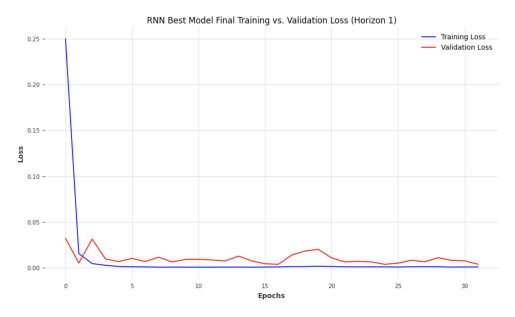

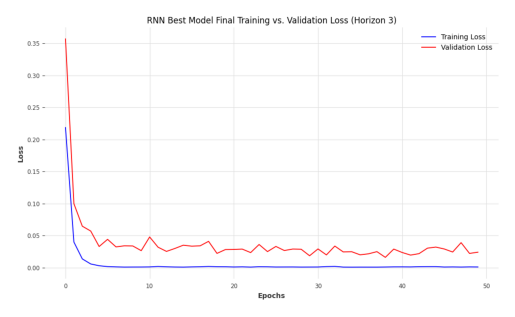

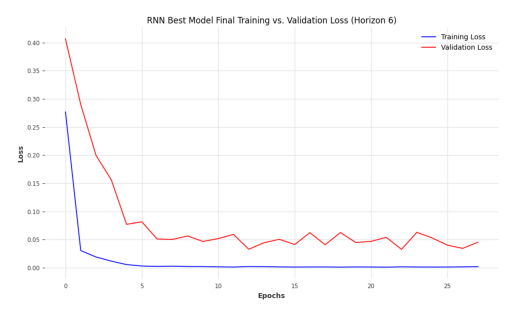

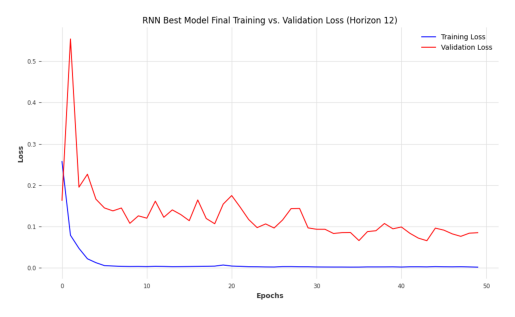

In [33]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path

# Paths to the saved plot images for each horizon
plot_paths = [
    Path(project_root) / "Plots" / "RNN" / "RNN_vs_Loss_H1_TRAIN.png",
    Path(project_root) / "Plots" / "RNN" / "RNN_vs_Loss_H3_TRAIN.png",
    Path(project_root) / "Plots" / "RNN" / "RNN_vs_Loss_H6_TRAIN.png",
    Path(project_root) / "Plots" / "RNN" / "RNN_vs_Loss_H12_TRAIN.png"
]

# Display each plot
for plot_path in plot_paths:
    img = mpimg.imread(plot_path)
    plt.imshow(img)
    plt.axis('off')  # Turn off axes for a cleaner look
    plt.show()


Evaluation Metrics (Test Set):

In [34]:
import numpy as np
import os
from pathlib import Path
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

# === Set Project Root as a Path object ===
project_root = Path(os.path.abspath(os.path.join(os.getcwd(), "..", "..")))

# === Collect metrics for all horizons ===
results = []

for horizon in [1, 3, 6, 12]:
    pred_file = project_root / "Predictions" / f"Horizon{horizon}" / f"RNN1990_horizon_{horizon}.npy"
    
    if not pred_file.exists():
        print(f"Missing: {pred_file}")
        continue
    
    preds = np.load(pred_file)
    y_true, y_pred = preds[:, 0], preds[:, 1]

    # === Metrics ===
    rmse = mean_squared_error(y_true, y_pred)  # Get RMSE directly
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    results.append({
        "Horizon": horizon,
        "RMSE": rmse,
        "MAE": mae,
        "R²": r2
    })

# === Display nicely ===
df_results = pd.DataFrame(results)
print("\nRNN Evaluation Metrics (Test Set):")
print(df_results.to_string(index=False))



RNN Evaluation Metrics (Test Set):
 Horizon     RMSE      MAE       R²
       1 0.897220 0.759671 0.981898
       3 0.143931 0.301494 0.996942
       6 0.143583 0.301053 0.996602
      12 0.142245 0.296560 0.995569


RMSE and Saving Predictions & Main Execution Function

In [35]:
import os

# Function to load the model with error handling
def load_model(model_save_path, model_invariates, best_model_params, device, model_name):
    best_model_path = os.path.join(model_save_path, f"{model_name}_best.pth")
    
    # Check if the model file exists before loading it
    if not os.path.exists(best_model_path):
        print(f"Model file not found: {best_model_path}")
        return None  # Return None if model file does not exist
    
    model = RNNModel(**model_invariates, **best_model_params).to(device)
    
    # Try loading the model with strict=False to allow shape mismatches
    model.load_state_dict(torch.load(best_model_path), strict=False)
    
    model.eval()
    return model


In [36]:
# Function to trim the last N values of predictions and save the file
def trim_and_save_predictions(predictions_path, n_trim=48):
    rnn_preds = np.load(predictions_path)
    rnn_preds_trimmed = rnn_preds[-n_trim:]
    np.save(predictions_path, rnn_preds_trimmed)
    print(f"Trimmed RNN_exog.npy to {len(rnn_preds_trimmed)} values and saved.")

# Main execution function for predictions
def predict_and_evaluate(model_save_path, model_invariates, best_model_params, val_loader, scaler, device, project_root, horizon):
    # Load the RNN model
    model = load_model(model_save_path, model_invariates, best_model_params, device, f"RNN_exog_Optuna_H{horizon}")

    # Make predictions and evaluate
    y_pred_original, y_val_original = make_evaluation_predictions(
        model, val_loader, device=device, y_scaler=scaler, y_scaler_features=['y']
    )

    # --- Debug check ---
    print(f"Preds shape: {y_pred_original.shape}, Labels shape: {y_val_original.shape}")

    # --- Align shapes if necessary ---
    min_len = min(len(y_val_original), len(y_pred_original))
    y_val_original = y_val_original[:min_len]
    y_pred_original = y_pred_original[:min_len]

    # Calculate evaluation metrics
    metrics = calc_metrics_arrays(y_val_original, y_pred_original, model_names=['RNN_exog'])
    print('Metrics on validation predictions:')
    display(metrics)

    # Save predictions
    pred_save_path = os.path.join(project_root, "Predictions", f"RNN.npy")
    np.save(pred_save_path, y_pred_original)
    print(f"Predictions saved to: {pred_save_path}")

# Assuming these variables are already defined: model_save_path, best_params, val_loader, scaler, feature_cols, device, project_root, horizon
predict_and_evaluate(model_save_path, model_invariates, best_model_params, val_loader, scaler, device, project_root, horizon)


Preds shape: (900,), Labels shape: (900,)
Metrics on validation predictions:


,RMSE,MAE,r2
RNN_exog,4.571265,3.483783,0.501207


Predictions saved to: c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Predictions\RNN.npy


Plots: Forecast vs Actual PCE (Horizon 1, 3, 6, 12)

In [37]:
from pathlib import Path
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_rnn_vs_actual(y_true, y_pred, title="RNN vs Actual PCE", time_index=None, save_path=None, smoothing_window=6):
    """
    Plot actual vs predicted PCE with optional smoothing and save.
    """
    plt.figure(figsize=(14, 6))

    # Convert to Series for smoothing
    y_true_series = pd.Series(y_true, index=time_index).rolling(window=smoothing_window, center=True, min_periods=1).mean()
    y_pred_series = pd.Series(y_pred, index=time_index).rolling(window=smoothing_window, center=True, min_periods=1).mean()

    # Plot
    plt.plot(time_index, y_true_series, label='Actual PCE (Smoothed)', color='black', linewidth=2, alpha=0.8)
    plt.plot(time_index, y_pred_series, label='RNN Prediction (Smoothed)', color='skyblue', linewidth=2, linestyle='--', alpha=0.8)

    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("PCE")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path)
        print(f"Saved plot to: {save_path}")
    else:
        plt.show()

# ==== TRAINING VISUALIZATION PER HORIZON ====
def plot_train_forecasts_per_horizon(project_root, feature_cols):
    train_file = Path(project_root) / "Data" / "Train" / "train1990s.csv"
    df = pd.read_csv(train_file)
    df['ds'] = pd.to_datetime(df['observation_date'], format='%m/%Y')
    pce_train_series = df.set_index('ds')['fred_PCEPI']

    for horizon in [1, 3, 6, 12]:
        path = Path(project_root) / "Predictions" / f"Horizon{horizon}" / f"RNN1990_horizon_{horizon}.npy"
        if not path.exists():
            print(f"Missing prediction file: {path}")
            continue

        preds = np.load(path)
        half = preds.shape[1] // 2
        if preds.shape[1] % 2 != 0:
            print(f"Unexpected shape: {preds.shape}. Trimming extra columns.")
            preds = preds[:, :half*2]  # Trim to even number of columns
        y_true, y_pred = preds[:, :half], preds[:, half:]

        # Use just the first step from each
        y_true_first = y_true[:, 0] if y_true.ndim > 1 else y_true
        y_pred_first = y_pred[:, 0] if y_pred.ndim > 1 else y_pred

        if preds.shape[1] != 2 * horizon:
            print(f"Unexpected number of columns in predictions for horizon {horizon}: {preds.shape[1]}")
            continue  # Skip and handle differently if necessary

        # Only use the first step of the true and predicted values
        y_true, y_pred = preds[:, 0], preds[:, horizon]  # horizon-th col is first predicted step
        n = len(y_true)
        time_index = pce_train_series.index[-n:]

        save_path = Path(project_root) / "Plots" / "RNN" / f"RNN_vs_PCE_H{horizon}_TRAIN.png"
        plot_rnn_vs_actual(y_true, y_pred, f"RNN Forecast vs Actual PCE (Horizon {horizon})", time_index, save_path)

        print(f"y_val_orig shape: {y_val_orig.shape}, y_pred_orig shape: {y_pred_orig.shape}")


Saved plot to: c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Plots\RNN\RNN_vs_PCE_H1_TRAIN.png
y_val_orig shape: (75, 12), y_pred_orig shape: (75, 12)
Saved plot to: c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Plots\RNN\RNN_vs_PCE_H3_TRAIN.png
y_val_orig shape: (75, 12), y_pred_orig shape: (75, 12)
Saved plot to: c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Plots\RNN\RNN_vs_PCE_H6_TRAIN.png
y_val_orig shape: (75, 12), y_pred_orig shape: (75, 12)
Saved plot to: c:\Sandra D\aUNI24-25\group_proj\versions code\22.04\COMP5530M-Group-Project-Inflation-Forecasting\Plots\RNN\RNN_vs_PCE_H12_TRAIN.png
y_val_orig shape: (75, 12), y_pred_orig shape: (75, 12)


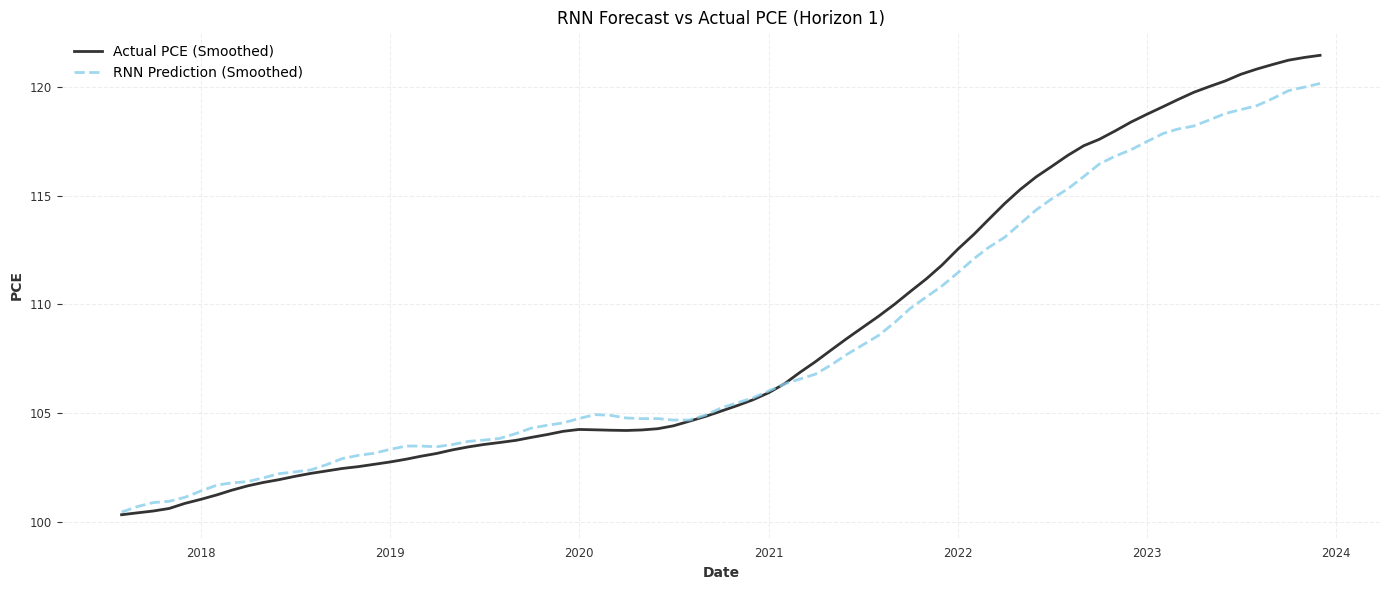

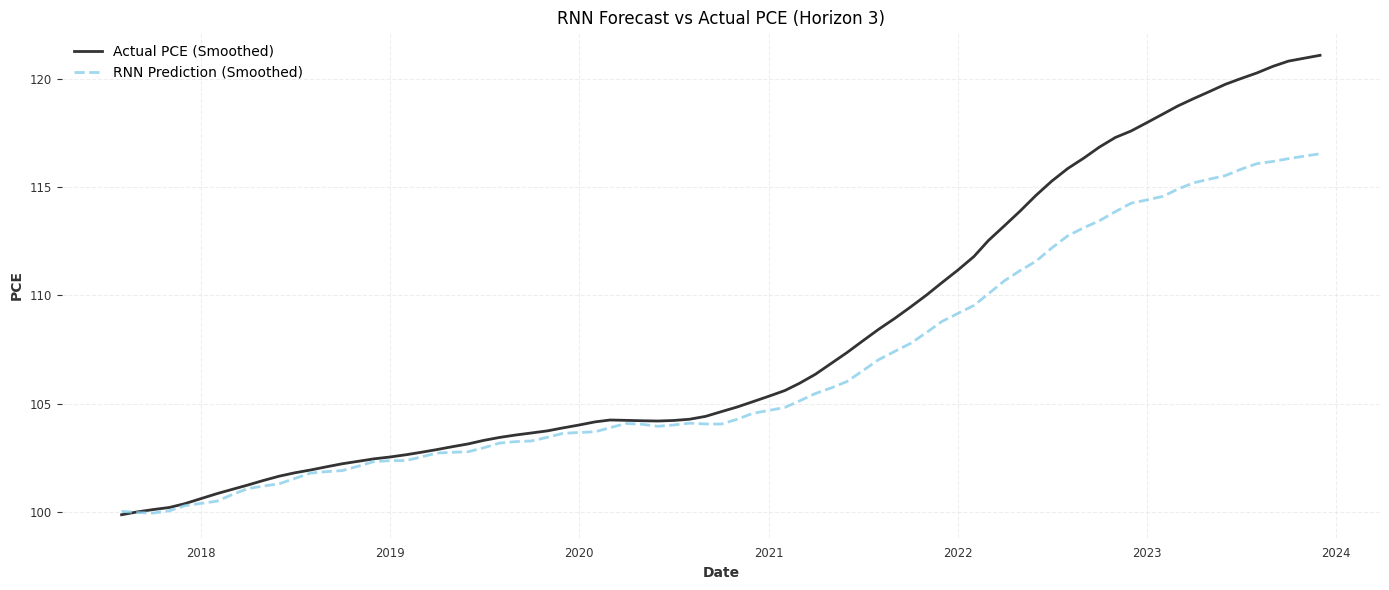

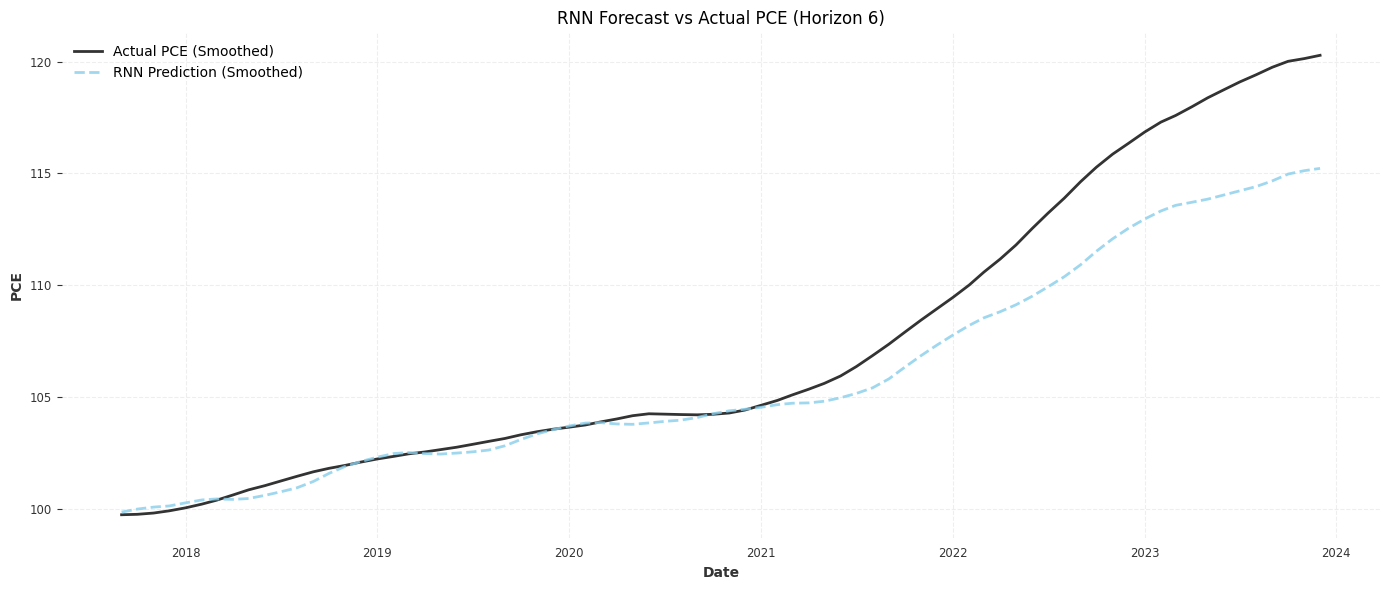

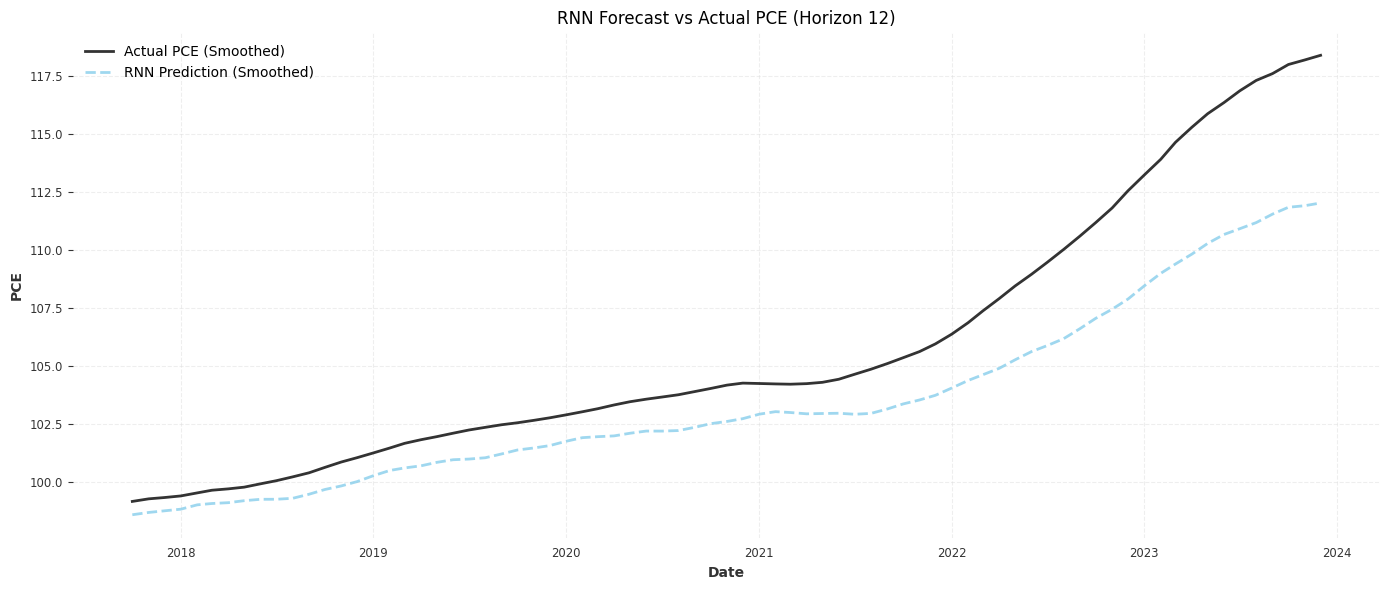

In [38]:
# Now you can call the plotting functions
plot_train_forecasts_per_horizon(project_root, feature_cols)